# Load library 

In [1]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import pandas as pd
import numpy as np
import scipy.signal as signal
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from cw_radar import *
from psg import *
import importlib
import constants
import os
importlib.reload(constants)

from constants import PSG_FILE_PATH_5, XML_FILE_PATH_5, RADAR_FILE_PATH_5


## Define functions

In [2]:

def extract_timestamps_from_csv(csv_path):
    # Read start and end times from the CSV file
    with open(csv_path, 'r') as f:
        lines = f.readlines()
        start_time_str = [line for line in lines if 'Capture start time' in line][0].split(' - ')[1].strip()
        end_time_str = [line for line in lines if 'Capture end time' in line][0].split(' - ')[1].strip()
        start_time = datetime.strptime(start_time_str, '%a %b %d %H:%M:%S %Y')
        end_time = datetime.strptime(end_time_str, '%a %b %d %H:%M:%S %Y')
    return start_time, end_time

In [3]:
def one_hot_encode(df_psg, df_xml, encode_type='stage'):
    """
    One-hot encode events or sleep stages and integrate into the PSG DataFrame.

    Parameters:
    - df_psg: DataFrame containing the PSG data.
    - df_xml: XMLProcessor object containing event and sleep stage data.
    - encode_type: str, either 'stage' or 'event' to specify what to encode.

    Returns:
    - DataFrame: PSG DataFrame with one-hot encoded columns integrated.
    """
    if encode_type == 'stage':
        df_data = df_xml.sleep_stages
        time_window = 30
        unique_items = df_data['Sleep Stage'].unique()
        time_column = 'Start Time'
    elif encode_type == 'event':
        df_data = df_xml.events
        time_window = 1
        unique_items = df_data['Name'].unique()
        time_column = 'Start'
    else:
        raise ValueError("Invalid encode_type. Must be 'stage' or 'event'.")

    # Create an empty DataFrame with the same index as df_psg
    one_hot_df = pd.DataFrame(index=df_psg.index)
    time_window = timedelta(seconds=time_window)
    
    # Create one-hot encoded columns for each unique item
    for item in unique_items:
        one_hot_df[item] = 0

    # Fill in the one-hot encoded values based on times
    for _, row in df_data.iterrows():
        start_time = row[time_column]
        
        if encode_type == 'stage':
            end_time = start_time + time_window
            item = row['Sleep Stage']
            mask = (df_psg.index >= start_time) & (df_psg.index < end_time)

        else:  # encode_type == 'event'
            end_time = row['End']
            item = row['Name']
            mask = (df_psg.index >= start_time - time_window) & (df_psg.index < end_time + time_window) # label window: 1s before and after the event
        
        one_hot_df.loc[mask, item] = 1

    return one_hot_df

def integrate(df_psg, df_xml):
    # One-hot encode events and sleep stages
    events_one_hot = one_hot_encode(df_psg, df_xml, encode_type='event')
    stages_one_hot = one_hot_encode(df_psg, df_xml, encode_type='stage')

    # Integrate the one-hot encoded DataFrames into the PSG DataFrame
    return pd.concat([df_psg, stages_one_hot, events_one_hot], axis=1)


In [4]:
def lowpass_filter(fs, sig, highcut, order=4):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='lowpass')
    filtered_signal = signal.filtfilt(b, a, sig)
    return filtered_signal

def align_to_common_time_grid(psg_resampled, radar_resampled, freq_hz=64):
    """
    Aligns two resampled dataframes to a common time grid.

    Parameters:
    psg_resampled (pd.DataFrame): The first resampled dataframe.
    radar_resampled (pd.DataFrame): The second resampled dataframe.
    freq_hz (int): The frequency for the common time grid in Hz. Default is 64Hz.

    Returns:
    pd.DataFrame, pd.DataFrame: The aligned dataframes.
    """
    # Convert frequency from Hz to milliseconds
    freq_ms = f'{1000 / freq_hz}ms'

    # Define a common time grid (using the minimum and maximum timestamps)
    common_time_index = pd.date_range(
        start=max(psg_resampled.index.min(), radar_resampled.index.min()), 
        end=min(psg_resampled.index.max(), radar_resampled.index.max()), 
        freq=freq_ms  # Adjust frequency as necessary
    )

    # Reindex and interpolate both dataframes to this common time grid
    psg_aligned = psg_resampled.reindex(common_time_index, method='nearest')
    radar_aligned = radar_resampled.reindex(common_time_index, method='nearest')

    return psg_aligned, radar_aligned

def segment_and_label(df, segment_sec=10, freq_hz=64):
    """
    Segments and labels the given DataFrame based on given time window.
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to be segmented and labeled.
    - segment_sec (int): The duration of each segment in seconds. Default is 10.
    - freq_hz (int): The frequency of the data in Hz. Default is 64.
    Returns:
    - segmented_df (pandas.DataFrame): The segmented and labeled DataFrame.
    """
    # Initialize list to store segmented data
    segmented_data = []
    segment_size = segment_sec * freq_hz
    
    # Define columns for sleep stages and sleep events
    sleep_stages = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 
                    'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
    sleep_events = ['Mixed Apnea', 'Limb Movement (Left)', 'Limb Movement (Right)', 'SpO2 desaturation', 
                    'Hypopnea', 'PLM (Left)', 'PLM (Right)', 'SpO2 artifact', 'Arousal (ARO SPONT)', 
                    'Arousal (ARO PLM)', 'Arousal (ARO Limb)', 'Arousal (ARO RES)', 'Central Apnea', 
                    'Obstructive Apnea']
    
    # Loop over the DataFrame in chunks of segment_size
    for start in range(0, len(df), segment_size):
        # Get current segment
        segment = df.iloc[start:start + segment_size]
        
        # Calculate mean of continuous signals
        continuous_data = segment[['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2']].mean().to_dict()
        
        # Determine the dominant sleep stage (most frequent one)
        sleep_stage_counts = segment[sleep_stages].sum()
        dominant_sleep_stage = sleep_stage_counts.idxmax() if sleep_stage_counts.max() > 0 else 'No Stage'
        
        # Determine the dominant sleep event (most frequent one)
        sleep_event_counts = segment[sleep_events].sum()
        dominant_sleep_event = sleep_event_counts.idxmax() if sleep_event_counts.max() > 0 else 'No Event'
        
        # Get Start Time and End Time, trimmed to whole seconds
        start_time = segment.index[0].floor('s')
        end_time = segment.index[-1].floor('s')
        
        # Compile the data for this segment
        segment_data = {'Start Time': start_time, 'End Time': end_time, **continuous_data, 
                        'Dominant Sleep Stage': dominant_sleep_stage, 'Dominant Sleep Event': dominant_sleep_event}
        segmented_data.append(segment_data)
    
    # Convert segmented data to DataFrame
    segmented_df = pd.DataFrame(segmented_data)
    return segmented_df

def segment_and_label_as_nd_cubes(df, segment_sec=10, freq_hz=64, label_type='stage', input_signals=['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2']):
    """
    Segments the given DataFrame into n-dimensional cubes for each segment and assigns labels based on label_type.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to be segmented.
    - segment_sec (int): The duration of each segment in seconds. Default is 10.
    - freq_hz (int): The frequency of the data in Hz. Default is 64.
    - label_type (str): The type of label to attach ('stage' for sleep stage, 'event' for sleep event). Default is 'stage'.
    
    Returns:
    - X (numpy.ndarray): A 3D array (n-dimensional cube) representing the data for each segment.
    - y (numpy.ndarray): An array of labels for each segment.
    """
    # Number of data points per segment
    segment_size = segment_sec * freq_hz
    
    # Define columns for sleep stages and sleep events
    sleep_stages = ['Movement Time (MT)', 'Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 
                    'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
    sleep_events = ['Mixed Apnea', 'Limb Movement (Left)', 'Limb Movement (Right)', 'SpO2 desaturation', 
                    'Hypopnea', 'PLM (Left)', 'PLM (Right)', 'SpO2 artifact', 'Arousal (ARO SPONT)', 
                    'Arousal (ARO PLM)', 'Arousal (ARO Limb)', 'Arousal (ARO RES)', 'Central Apnea', 
                    'Obstructive Apnea']
    
    # Initialize lists to store the segmented data and labels
    X = []
    y = []

    # Loop over the DataFrame in chunks of segment_size
    for start in range(0, len(df), segment_size):
        # Get current segment
        segment = df.iloc[start:start + segment_size]
        
        # Check if segment size is not less than required (especially for the last segment)
        if len(segment) < segment_size:
            continue
        
        # Create a 2D array (segment_size x number_of_features) for the current segment
        segment_array = segment[input_signals].values
        
        # Append the array to X
        X.append(segment_array)
        
        # Determine the label based on label_type
        if label_type == 'stage':
            # Determine the dominant sleep stage (most frequent one)
            sleep_stage_counts = segment[sleep_stages].sum()
            dominant_sleep_stage = sleep_stage_counts.idxmax() if sleep_stage_counts.max() > 0 else 'No Stage'
            y.append(dominant_sleep_stage)
        elif label_type == 'event':
            # Determine the dominant sleep event (most frequent one)
            sleep_event_counts = segment[sleep_events].sum()
            dominant_sleep_event = sleep_event_counts.idxmax() if sleep_event_counts.max() > 0 else 'No Event'
            y.append(dominant_sleep_event)
        else:
            raise ValueError("Invalid label_type. Expected 'stage' or 'event'.")
    
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [5]:
def segment_and_label_as_nd_cubes(df, segment_sec=10, freq_hz=64, label_type='stage', input_signals=['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2']):
    """
    Segments the given DataFrame into n-dimensional cubes for each segment and assigns labels based on label_type.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to be segmented.
    - segment_sec (int): The duration of each segment in seconds. Default is 10.
    - freq_hz (int): The frequency of the data in Hz. Default is 64.
    - label_type (str): The type of label to attach ('stage' for sleep stage, 'event' for sleep event). Default is 'stage'.
    
    Returns:
    - X (numpy.ndarray): A 3D array (n-dimensional cube) representing the data for each segment.
    - y (numpy.ndarray): An array of labels for each segment.
    """
    # Number of data points per segment
    segment_size = segment_sec * freq_hz
    
    # Define columns for sleep stages and sleep events
    sleep_stages = ['Wakefulness (W)', 'NREM Sleep Stage 1 (N1)', 'REM Sleep', 
                    'NREM Sleep Stage 2 (N2)', 'NREM Sleep Stage 3 (N3)']
    sleep_events = ['Mixed Apnea', 'Limb Movement (Left)', 'Limb Movement (Right)', 'SpO2 desaturation', 
                    'Hypopnea', 'PLM (Left)', 'PLM (Right)', 'SpO2 artifact', 'Arousal (ARO SPONT)', 
                    'Arousal (ARO PLM)', 'Arousal (ARO Limb)', 'Arousal (ARO RES)', 
                    'Obstructive Apnea']
    
    # Initialize lists to store the segmented data and labels
    X = []
    y = []

    # Loop over the DataFrame in chunks of segment_size
    for start in range(0, len(df), segment_size):
        # Get current segment
        segment = df.iloc[start:start + segment_size]
        
        # Check if segment size is not less than required (especially for the last segment)
        if len(segment) < segment_size:
            continue
        
        # Create a 2D array (segment_size x number_of_features) for the current segment
        segment_array = segment[input_signals].values
        
        # Append the array to X
        X.append(segment_array)
        
        # Determine the label based on label_type
        if label_type == 'stage':
            # Determine the dominant sleep stage (most frequent one)
            sleep_stage_counts = segment[sleep_stages].sum()
            dominant_sleep_stage = sleep_stage_counts.idxmax() if sleep_stage_counts.max() > 0 else 'No Stage'
            y.append(dominant_sleep_stage)
        elif label_type == 'event':
            # Determine the dominant sleep event (most frequent one)
            sleep_event_counts = segment[sleep_events].sum()
            dominant_sleep_event = sleep_event_counts.idxmax() if sleep_event_counts.max() > 0 else 'No Event'
            y.append(dominant_sleep_event)
        else:
            raise ValueError("Invalid label_type. Expected 'stage' or 'event'.")
    
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

import numpy as np
import matplotlib.pyplot as plt

def plot_fft(signal, sample_rate, title):
    """
    Plots the FFT of a given signal and returns the frequency and amplitude of the highest point.

    Parameters:
    signal (np.array): The input signal.
    sample_rate (float): The sample rate of the signal.
    title (str): The title of the plot.

    Returns:
    tuple: The frequency and amplitude of the highest point in the FFT plot.
    """
    # Remove the DC component
    signal = signal - np.mean(signal)
    
    # Compute the FFT
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/sample_rate)

    # Find the highest point in the FFT plot
    positive_freqs = fft_freq[:len(fft_freq)//2]
    positive_amplitudes = np.abs(fft_result[:len(fft_result)//2])
    max_index = np.argmax(positive_amplitudes)
    max_freq = positive_freqs[max_index]
    max_amplitude = positive_amplitudes[max_index]

    # Plot the FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(positive_freqs, positive_amplitudes)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1)  # Limit the plot to the 0 to 5 Hz range
    plt.grid(True)
    plt.show()

    return max_freq, max_amplitude



# 2025-02-26

## Load data

In [6]:
# Load PSG data
psg_processor = PSGDataProcessor(PSG_FILE_PATH_5)
psg_processor.load_data()

# Load radar data
radar_sample_rate = 1002
cw_processor = CWDataProcessor(RADAR_FILE_PATH_5, radar_sample_rate)
cw_processor.load_data()

# Load XML data
xml_processor = XMLProcessor(XML_FILE_PATH_5, psg_processor.start_datetime)
xml_processor.load()

Extracting EDF parameters from /opt/data/private/ZhouWenren/SleepLab/psg/data/2025-02-26/PSG2025022631A任红兵.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/opt/data/private/ZhouWenren/SleepLab/psg/psg_data_extraction.py:41: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo, Sum
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)
/opt/data/private/ZhouWenren/SleepLab/psg/psg_data_extraction.py:41: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)
/opt/data/private/ZhouWenren/SleepLab/psg/psg_data_extraction.py:41: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  self.data = mne.io.read_raw_edf(self.file_path, preload=True)


Reading 0 ... 30085119  =      0.000 ... 29379.999 secs...


Sampling Rate: 1024.0
Channel Names: ['E1-M2', 'E2-M2', 'Chin 1-Chin 2', 'Chin 3-Chin 2', 'F3-M2', 'F4-M1', 'C3-M2', 'C4-M1', 'O1-M2', 'O2-M1', 'RIP ECG', 'SpO2', 'Nasal Pressure', 'Therm', 'Thor', 'Abdo', 'Sum', 'Leg/L', 'Leg/R', 'Snore', 'PositionSen']
Start Datetime: 2025-02-26 22:00:10
End Datetime: 2025-02-27 06:09:49.999023
Start time: 2025-02-26 23:39:10
End time: 2025-02-27 07:45:13
Sample rate: 1002 Hz
                       Name  Actual Start (sec)  Duration  \
0     Limb Movement (Right)                34.4       5.7   
1      Limb Movement (Left)               421.4       0.7   
2                PLM (Left)               428.9       2.0   
3                    Unsure               461.4      16.6   
4               PLM (Right)               507.3       9.4   
...                     ...                 ...       ...   
1097             PLM (Left)             29228.1       1.1   
1098            PLM (Right)             29228.9       0.6   
1099            PLM (Right)         

In [7]:
# Extract data between two timestamps
start_datetime = psg_processor.start_datetime
end_datetime = psg_processor.end_datetime
print(f"Start Timestamp: {start_datetime}, End Timestamp: {end_datetime}")  # Print the start and end timestamps of the extracted data
bio_list = ['RIP ECG', 'Thor', 'Abdo', 'SpO2', 'Nasal Pressure', 'Leg/L', 'Leg/R', 'E1-M2', 'E2-M2', 'PositionSen']
psg_date_segment = psg_processor.extract_segment_by_timestamp(data_types=bio_list)

radar_data_subset = extract_data_subset(cw_processor.data, start_datetime, end_datetime)
processed_sig = cw_processor.process_signal(radar_data_subset)


Start Timestamp: 2025-02-26 22:00:10, End Timestamp: 2025-02-27 06:09:49.999023
30085118
2025-02-26 22:00:10


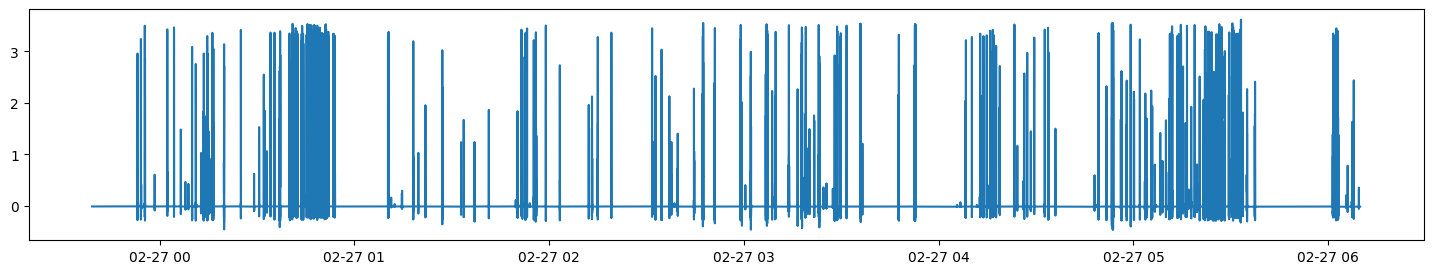

In [8]:
plt.plot(processed_sig['processed_signal'])

In [9]:
from scipy import signal

psg_resampled = resample_data(psg_date_segment, original_freq=psg_processor.sampling_rate, target_freq=64)

radar_resampled = resample_data(processed_sig, original_freq=radar_sample_rate, target_freq=64)
radar_resampled['processed_signal'] = lowpass_filter(radar_sample_rate, radar_resampled['processed_signal'], 5, order=4)

# Reindex and interpolate both dataframes to this common time grid
psg_aligned, radar_aligned = align_to_common_time_grid(psg_resampled, radar_resampled, freq_hz=64)


In [10]:
# rsp_signals, rsp_info = nk.rsp_process(psg_aligned['Thor'], sampling_rate=64, report="text")
# ecg_signals, ecg_info = nk.ecg_process(psg_aligned['ECG'], sampling_rate=64)


In [11]:
merged_aligned_df = psg_aligned.copy()
# rsp_signals.index = psg_aligned.index
# merged_aligned_df.insert(0, 'RSP_Rate', rsp_signals['RSP_Rate'])
# ecg_signals.index = psg_aligned.index
# merged_aligned_df.insert(0, 'ECG_Rate', ecg_signals['ECG_Rate'])
merged_aligned_df.insert(0, 'processed_signal', radar_aligned)

# Integrate the XML data with the merged aligned DataFrame
merged_df = integrate(merged_aligned_df, xml_processor)
print(merged_df.head())

                            processed_signal   RIP ECG      Thor      Abdo  \
2025-02-26 23:39:10.746241         -0.007154 -0.000081  0.515809  0.323357   
2025-02-26 23:39:10.761866         -0.007282 -0.000142  0.518405  0.324953   
2025-02-26 23:39:10.777491         -0.007410 -0.000209  0.515055  0.322935   
2025-02-26 23:39:10.793116         -0.007538 -0.000283  0.499301  0.312140   
2025-02-26 23:39:10.808741         -0.007666 -0.000348  0.471230  0.292222   

                                 SpO2  Nasal Pressure         Leg/L  \
2025-02-26 23:39:10.746241  97.085530       -0.003144 -3.001927e-08   
2025-02-26 23:39:10.761866  97.085807       -0.002896  1.491621e-07   
2025-02-26 23:39:10.777491  97.086083       -0.002431 -5.515376e-08   
2025-02-26 23:39:10.793116  97.086088       -0.002669  1.404012e-07   
2025-02-26 23:39:10.808741  97.085529       -0.002576 -5.846983e-08   

                                   Leg/R     E1-M2         E2-M2  ...  \
2025-02-26 23:39:10.746241 -1.1

### Save the merged DataFrame to a file

In [12]:
# Define the file path and get the directory path and filename
psg_file_path = PSG_FILE_PATH_5
dir_path, filename = os.path.split(psg_file_path)
modified_filename = 'full_merged_' + filename

# Save as HDF5 file for efficiency and compactness
save_path = os.path.join(dir_path, modified_filename + '.h5')
merged_df.to_hdf(save_path, key='merged_df', mode='w')
print(f"HDF5 file saved at: {save_path}")

HDF5 file saved at: /opt/data/private/ZhouWenren/SleepLab/psg/data/2025-02-26/full_merged_PSG2025022631A任红兵.edf.h5


### Load the merged data from the saved Pickle file

##### Basic

In [13]:
# Define the file path and get the directory path and filename
psg_file_path = PSG_FILE_PATH_5
dir_path, filename = os.path.split(psg_file_path)
modified_filename = 'full_merged_' + filename

# Load as HDF5 file for efficiency and compactness
load_path = os.path.join(dir_path, modified_filename + '.h5')

In [14]:
import pandas as pd

# Load the merged DataFrame from the saved HDF5 file
merged_df = pd.read_hdf(load_path, key='merged_df')

# Display the first few rows of the DataFrame
print(merged_df.head())

                            processed_signal   RIP ECG      Thor      Abdo  \
2025-02-26 23:39:10.746241         -0.007154 -0.000081  0.515809  0.323357   
2025-02-26 23:39:10.761866         -0.007282 -0.000142  0.518405  0.324953   
2025-02-26 23:39:10.777491         -0.007410 -0.000209  0.515055  0.322935   
2025-02-26 23:39:10.793116         -0.007538 -0.000283  0.499301  0.312140   
2025-02-26 23:39:10.808741         -0.007666 -0.000348  0.471230  0.292222   

                                 SpO2  Nasal Pressure         Leg/L  \
2025-02-26 23:39:10.746241  97.085530       -0.003144 -3.001927e-08   
2025-02-26 23:39:10.761866  97.085807       -0.002896  1.491621e-07   
2025-02-26 23:39:10.777491  97.086083       -0.002431 -5.515376e-08   
2025-02-26 23:39:10.793116  97.086088       -0.002669  1.404012e-07   
2025-02-26 23:39:10.808741  97.085529       -0.002576 -5.846983e-08   

                                   Leg/R     E1-M2         E2-M2  ...  \
2025-02-26 23:39:10.746241 -1.1

In [15]:
merged_df.columns

Index(['processed_signal', 'RIP ECG', 'Thor', 'Abdo', 'SpO2', 'Nasal Pressure',
       'Leg/L', 'Leg/R', 'E1-M2', 'E2-M2', 'PositionSen', 'Wakefulness (W)',
       'NREM Sleep Stage 1 (N1)', 'NREM Sleep Stage 2 (N2)', 'REM Sleep',
       'Limb Movement (Right)', 'Limb Movement (Left)', 'PLM (Left)', 'Unsure',
       'PLM (Right)', 'Arousal (ARO SPONT)', 'Hypopnea', 'Arousal (ARO RES)',
       'SpO2 desaturation', 'Obstructive Apnea', 'Arousal (ARO PLM)'],
      dtype='object')

In [16]:
# Check if 'SpO2 artifact' column exists before filtering
if 'SpO2 artifact' in merged_df.columns:
    filtered_df = merged_df[merged_df['SpO2 artifact'] != 1]
    merged_df = filtered_df
else:
    print("'SpO2 artifact' column does not exist in the DataFrame.")
print(merged_df.head())

'SpO2 artifact' column does not exist in the DataFrame.
                            processed_signal   RIP ECG      Thor      Abdo  \
2025-02-26 23:39:10.746241         -0.007154 -0.000081  0.515809  0.323357   
2025-02-26 23:39:10.761866         -0.007282 -0.000142  0.518405  0.324953   
2025-02-26 23:39:10.777491         -0.007410 -0.000209  0.515055  0.322935   
2025-02-26 23:39:10.793116         -0.007538 -0.000283  0.499301  0.312140   
2025-02-26 23:39:10.808741         -0.007666 -0.000348  0.471230  0.292222   

                                 SpO2  Nasal Pressure         Leg/L  \
2025-02-26 23:39:10.746241  97.085530       -0.003144 -3.001927e-08   
2025-02-26 23:39:10.761866  97.085807       -0.002896  1.491621e-07   
2025-02-26 23:39:10.777491  97.086083       -0.002431 -5.515376e-08   
2025-02-26 23:39:10.793116  97.086088       -0.002669  1.404012e-07   
2025-02-26 23:39:10.808741  97.085529       -0.002576 -5.846983e-08   

                                   Leg/R     E1-

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the StandardScaler and MinMaxScaler
scaler = StandardScaler()
# scaler_minmax = MinMaxScaler()

# Standardize the 'processed_signal' and 'Thor' columns
merged_df[['processed_signal', 'Thor']] = scaler.fit_transform(merged_df[['processed_signal', 'Thor']])

# Apply MinMaxScaler to rescale the standardized data
# merged_df[['processed_signal', 'Thor']] = scaler_minmax.fit_transform(merged_df[['processed_signal', 'Thor']])

merged_df.rename(columns={'processed_signal': 'breath'}, inplace=True)
merged_df.rename(columns={'Pressure': 'Airflow'}, inplace=True)

##### Old dataframe

In [18]:

def segment_and_label_as_nd_cubes(df, segment_sec=10, freq_hz=64, label_type='stage', input_signals=['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2'], stage_list=None, event_list=None):
    """
    Segments the given DataFrame into n-dimensional cubes for each segment and assigns labels based on label_type.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data to be segmented.
    - segment_sec (int): The duration of each segment in seconds. Default is 10.
    - freq_hz (int): The frequency of the data in Hz. Default is 64.
    - label_type (str): The type of label to attach ('stage' for sleep stage, 'event' for sleep event). Default is 'stage'.
    
    Returns:
    - X (numpy.ndarray): A 3D array (n-dimensional cube) representing the data for each segment.
    - y (numpy.ndarray): An array of labels for each segment.
    """
    # Number of data points per segment
    segment_size = segment_sec * freq_hz
    
    # Define columns for sleep stages and sleep events
    sleep_stages = stage_list
    sleep_events = event_list
    
    # Initialize lists to store the segmented data and labels
    X = []
    y = []

    # Loop over the DataFrame in chunks of segment_size
    for start in range(0, len(df), segment_size):
        # Get current segment
        segment = df.iloc[start:start + segment_size]
        
        # Check if segment size is not less than required (especially for the last segment)
        if len(segment) < segment_size:
            continue
        
        # Create a 2D array (segment_size x number_of_features) for the current segment
        segment_array = segment[input_signals].values
        
        # Append the array to X
        X.append(segment_array)
        
        # Determine the label based on label_type
        if label_type == 'stage':
            # Determine the dominant sleep stage (most frequent one)
            sleep_stage_counts = segment[sleep_stages].sum()
            dominant_sleep_stage = sleep_stage_counts.idxmax() if sleep_stage_counts.max() > 0 else 'No Stage'
            y.append(dominant_sleep_stage)
        elif label_type == 'event':
            # Determine the dominant sleep event (most frequent one)
            sleep_event_counts = segment[sleep_events].sum()
            dominant_sleep_event = sleep_event_counts.idxmax() if sleep_event_counts.max() > 0 else 'No Event'
            y.append(dominant_sleep_event)
        else:
            raise ValueError("Invalid label_type. Expected 'stage' or 'event'.")
    
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [19]:
# Example usage:
# Define columns for continuous data
continuous_columns = ['breath', 'ECG', 'Thor', 'Abdo', 'SpO2', 'Airflow', 'Leg/L', 'Leg/R', 'E1-M2', 'E2-M2']
stage_list = xml_processor.sleep_stages['Sleep Stage'].unique()
event_list = xml_processor.events['Name'].unique()

# Apply the function to your DataFrame with 'stage' label
X_stage, y_stage = segment_and_label_as_nd_cubes(merged_df, segment_sec=30, input_signals = continuous_columns, label_type='stage', stage_list=stage_list, event_list=event_list)

# Apply the function to your DataFrame with 'event' label
X_event, y_event = segment_and_label_as_nd_cubes(merged_df, segment_sec=15, freq_hz=64, input_signals = continuous_columns, label_type='event', stage_list=stage_list, event_list=event_list)

print("Shape of X_stage:", X_stage.shape)  # Should be (number of segments, segment_size, number of features)
print("Shape of y_stage:", y_stage.shape)  # Should be (number of segments,)
print("Example label for 'stage' (y_stage[0]):", y_stage[0])

print("Shape of X_event:", X_event.shape)  # Should be (number of segments, segment_size, number of features)
print("Shape of y_event:", y_event.shape)  # Should be (number of segments,)
print("Example label for 'event' (y_event[0]):", y_event[0])

KeyError: "['ECG', 'Airflow'] not in index"

##### New dataframe

In [20]:
input_signals = ['breath', 'RIP ECG', 'Thor', 'Abdo', 'SpO2', 'Nasal Pressure']
# input_signals = ['breath', 'Thor']

In [21]:
import pandas as pd
import numpy as np

def segment_and_label_as_dataframe(
    df, 
    segment_sec=10, 
    freq_hz=64, 
    label_type='stage', 
    stage_list=None,
    event_list=None,
    input_signals=['breath', 'ECG', 'Thor', 'Abdo', 'SpO2']
):
    """
    Segments the given DataFrame in steps of segment_size and stores each segment
    as a row in the resulting DataFrame. Each column contains a 1D array corresponding
    to that segment of the signal. The last column is the label (stage or event).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to be segmented.
    segment_sec : int, optional
        The duration of each segment in seconds (default=10).
    freq_hz : int, optional
        The frequency of the data in Hz (default=64).
    label_type : str, optional
        The type of label to attach ('stage' for sleep stage, 'event' for sleep event).
        (default='stage')
    input_signals : list, optional
        The list of columns in `df` corresponding to signals. (default=['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2'])
    
    Returns:
    --------
    segmented_df : pandas.DataFrame
        A DataFrame where each row corresponds to one segment:
            - Each input signal column will contain a 1D numpy array of length `segment_size`.
            - The last column, 'label', contains the assigned label for that segment.
        The shape of the output DataFrame is
        [num_segments, len(input_signals) + 1].
    """
    
    # Number of data points per segment
    segment_size = segment_sec * freq_hz
    
    # Define columns for sleep stages and events
    sleep_stages = stage_list
    sleep_events = event_list
    
    data_rows = []
    
    # Loop over the DataFrame in steps of 'segment_size'
    for start_idx in range(0, len(df), segment_size):
        segment = df.iloc[start_idx : start_idx + segment_size]
        
        # If the segment is smaller than segment_size (e.g., the last chunk), skip it
        if len(segment) < segment_size:
            break
        
        # Prepare a row where each column is the segment for that signal
        row_data = []
        for signal_col in input_signals:
            # Store the entire 1D array of the signal chunk
            row_data.append(segment[signal_col].values)
        
        # Determine the label
        if label_type == 'stage':
            # Sum each stage column, pick the one with highest sum (dominant stage)
            sleep_stage_counts = segment[sleep_stages].sum()
            dominant_sleep_stage = (
                sleep_stage_counts.idxmax() 
                if sleep_stage_counts.max() > 0 
                else 'No Stage'
            )
            label = dominant_sleep_stage
        
        elif label_type == 'event':
            # Sum each event column, pick the one with highest sum (dominant event)
            sleep_event_counts = segment[sleep_events].sum()
            dominant_sleep_event = (
                sleep_event_counts.idxmax() 
                if sleep_event_counts.max() > 0 
                else 'No Event'
            )
            label = dominant_sleep_event
        
        else:
            raise ValueError("Invalid label_type. Expected 'stage' or 'event'.")
        
        # Append the label to the row data
        row_data.append(label)
        
        # Finally, add this row to our list of segmented data
        data_rows.append(row_data)
    
    # Create column names: each input signal plus the final 'label'
    columns = input_signals + ['label']
    
    # Build a DataFrame: shape => [num_segments, len(input_signals) + 1]
    segmented_df = pd.DataFrame(data_rows, columns=columns)
    
    return segmented_df


In [22]:
stage_list = xml_processor.sleep_stages['Sleep Stage'].unique()
event_list = xml_processor.events['Name'].unique()

# Call the function to get your segmented DataFrame:
segmented_df = segment_and_label_as_dataframe(
    merged_df,
    segment_sec=10,
    freq_hz=64,
    label_type='event',
    stage_list=stage_list,
    event_list=event_list,
    input_signals=input_signals
)

segmented_df


,breath,RIP ECG,Thor,Abdo,SpO2,Nasal Pressure,label
0,"[-0.06718467315878576, -0.06838858049289834, -...","[-8.104525862505447e-05, -0.000141845500019779...","[0.09693110739801258, 0.10257167127313062, 0.0...","[0.3233570337875076, 0.3249534287070924, 0.322...","[97.0855298798265, 97.08580673853787, 97.08608...","[-0.00314365377963919, -0.002896461272583563, ...",Obstructive Apnea
1,"[-0.1259730155831282, -0.12597327869611233, -0...","[0.00024516626575312947, 0.0001405422482158610...","[0.8387640440478119, 0.9050528897873997, 0.985...","[0.6484845795517312, 0.6647178302246235, 0.681...","[96.2920505891745, 96.29098465352695, 96.29077...","[0.0011146586953714576, 0.0008107004369410766,...",Arousal (ARO RES)
2,"[-0.12599775071920033, -0.12599777508430232, -...","[0.00026098207644780944, 0.0002393878422385357...","[0.17889693870282744, 0.10426714241543324, -0....","[0.9812667227637785, 0.9561800743707958, 0.925...","[95.04995947735263, 95.0460108537757, 95.04589...","[-0.05000000006483415, -0.05000000006239076, -...",Obstructive Apnea
3,"[-0.12601396224550185, -0.1260139865115604, -0...","[0.0006466636361389892, 4.4016675270912565e-05...","[-1.0239656715575092, -1.0251011284048617, -1....","[-3.3390078319712963e-07, 0.000708314647247209...","[95.26512681180783, 95.26559349571288, 95.2657...","[-0.04998482515067174, -0.05003751903495698, -...",Obstructive Apnea
4,"[-0.12603017204717493, -0.12603019631345805, -...","[0.00016324792562369875, 0.0001068436630729386...","[-1.0239657523725403, -1.0248780321056041, -1....","[0.207844576125903, 0.2191507463788262, 0.2248...","[97.21826993747258, 97.22728930253673, 97.2381...","[-0.004467247136540083, -0.004072737390755961,...",Obstructive Apnea
...,...,...,...,...,...,...,...
2338,"[-0.16386014438600185, -0.1638601686523759, -0...","[9.663884214112336e-05, 3.994377975723768e-06,...","[1.1467214190492878, 1.149117658176385, 1.1515...","[1.000708630742308, 0.9999999701962695, 0.9992...","[96.85472792049848, 96.85511593931325, 96.8554...","[0.029668564435079734, 0.028040981399521197, 0...",No Event
2339,"[-0.16387635437491416, -0.16387637864956145, -...","[0.0002594999564547894, 0.00010698792028388267...","[-1.021974441906138, -1.0239651509732883, -1.0...","[0.03533651171776871, 0.03558036784269939, 0.0...","[96.85462902321252, 96.85511255964121, 96.8554...","[-0.04999999999270905, -0.04999999999231081, -...",No Event
2340,"[-0.1638933545649087, -0.1638933972622163, -0....","[-2.0644247012899238e-05, -3.684369711489115e-...","[-1.0268866061154267, -1.0239653512238542, -1....","[-0.0007851790365247359, 7.555911772643369e-08...","[96.57913428396903, 96.58197315967165, 96.5867...","[0.04999999997097768, 0.049999999972888204, 0....",No Event
2341,"[-0.1665161288012982, -0.16653566346895937, -0...","[0.00019823428833812314, 0.0001941540319687786...","[1.1494475268299573, 1.1491178582097559, 1.148...","[1.0018453218148275, 0.9999999446164645, 0.998...","[96.81467257195233, 96.81543911580167, 96.8160...","[0.043898566964352126, 0.010883797314847128, -...",No Event


In [23]:
# Display basic DataFrame information
print(f"DataFrame shape: {segmented_df.shape}")
print(segmented_df.iloc[0].shape)
print(segmented_df.iloc[0][0].shape)
print(f"Number of segments: {len(segmented_df)}")
print(f"Columns: {segmented_df.columns.tolist()}")
print("\nDataFrame index info:", segmented_df.index)
# Print unique labels
print("\nUnique labels:", segmented_df['label'].unique())



DataFrame shape: (2343, 7)
(7,)
(640,)
Number of segments: 2343
Columns: ['breath', 'RIP ECG', 'Thor', 'Abdo', 'SpO2', 'Nasal Pressure', 'label']

DataFrame index info: RangeIndex(start=0, stop=2343, step=1)

Unique labels: ['Obstructive Apnea' 'Arousal (ARO RES)' 'No Event' 'Limb Movement (Left)'
 'Hypopnea' 'SpO2 desaturation' 'Arousal (ARO SPONT)'
 'Limb Movement (Right)' 'PLM (Left)' 'PLM (Right)' 'Arousal (ARO PLM)']


/tmp/ipykernel_1592509/4150431942.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(segmented_df.iloc[0][0].shape)


In [24]:
# Save the segmented DataFrame to the same file as merged_df with key 'segmented_data'
segmented_df.to_hdf(load_path, key='segmented_df', mode='a')
print(f"HDF file saved at: {load_path}")
print(f"Creating HDF5 file with numpy version: {np.__version__}")


/tmp/ipykernel_1592509/3682465861.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['breath', 'RIP ECG', 'Thor', 'Abdo', 'SpO2', 'Nasal Pressure', 'label'], dtype='object')]

  segmented_df.to_hdf(load_path, key='segmented_df', mode='a')


HDF file saved at: /opt/data/private/ZhouWenren/SleepLab/psg/data/2025-02-26/full_merged_PSG2025022631A任红兵.edf.h5
Creating HDF5 file with numpy version: 1.24.4


In [25]:
# Current
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, find_peaks, hilbert, butter, filtfilt
from datetime import timedelta
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def is_valid_data(values, min_length=2, min_std=1e-8):
    return len(values) >= min_length and np.std(values) >= min_std

def calculate_mean(values):
    return np.mean(values) if len(values) > 0 else np.nan

def calculate_std(values):
    return np.std(values) if len(values) > 0 else np.nan

def calculate_windowed_std(values, window_size=128):
    if len(values) < window_size:
        return np.std(values) if len(values) > 1 else np.nan  # Use global std if insufficient data
    
    windowed_std = [np.std(values[i:i+window_size]) for i in range(len(values) - window_size + 1)]
    return np.std(windowed_std)

def calculate_windowed_entropy(values, window_size=128):
    if len(values) < window_size:
        if len(values) > 1: # Use global std if insufficient data
            histogram, _ = np.histogram(np.std(values), bins='auto', density=True) 
            return entropy(histogram)
    else:
        windowed_std = [
            np.std(values[i:i+window_size])
            for i in range(len(values) - window_size + 1)
        ]
        histogram, _ = np.histogram(windowed_std, bins='auto', density=True)
        return entropy(histogram)

def calculate_min(values):
    return np.min(values) if len(values) > 0 else np.nan

def calculate_max(values):
    return np.max(values) if len(values) > 0 else np.nan

def calculate_median(values):
    return np.median(values) if len(values) > 0 else np.nan

def calculate_skewness(values):
    if not is_valid_data(values, min_length=3):
        return np.nan
    return skew(values)

def calculate_kurtosis(values):
    if not is_valid_data(values, min_length=4):
        return np.nan
    return kurtosis(values)

def calculate_rms(values):
    return np.sqrt(np.mean(np.square(values))) if len(values) > 0 else np.nan

def calculate_rms_filtered(values, fs = 64, freq_band = (0.1, 0.5)):
    """
    Calculate the RMS of a signal after filtering for a specific frequency band.

    Parameters:
    - values (array-like): Input signal values.
    - fs (float): Sampling frequency of the signal.
    - freq_band (tuple): Frequency band for filtering as (low_freq, high_freq).

    Returns:
    - float: RMS value of the filtered signal, or NaN if the input is invalid.
    """
    padlen = 27
    if len(values) == 0 or len(values) <= padlen or fs <= 0 or not (isinstance(freq_band, tuple) and len(freq_band) == 2):
        return np.nan

    # Design a bandpass filter
    low, high = freq_band
    nyquist = 0.5 * fs
    low = low / nyquist
    high = high / nyquist

    # Check frequency band validity
    if low <= 0 or high >= 1 or low >= high:
        return np.nan

    # Butterworth filter design
    b, a = butter(N=4, Wn=[low, high], btype='band')

    # Apply the filter
    filtered_values = filtfilt(b, a, values)

    # Calculate RMS of the filtered signal
    rms_value = np.sqrt(np.mean(np.square(filtered_values)))
    return rms_value

def calculate_iqr(values):
    if len(values) > 0:
        return np.percentile(values, 75) - np.percentile(values, 25)
    return np.nan

def calculate_line_length(values):
    return 10 * 64 * np.sum(np.abs(np.diff(values))) / (len(values) - 1) if len(values) > 1 else np.nan

def calculate_variance_of_amplitude(values):
    if not is_valid_data(values, min_length=2):
        return np.nan
    return np.var(values)

def calculate_slope_of_amplitude_changes(values):
    diff_values = np.diff(values)
    return np.mean(diff_values) if len(diff_values) > 0 else np.nan

def calculate_amplitude_envelope(values):
    if len(values) == 0:
        return np.nan
    analytic_signal = hilbert(values)
    amplitude_envelope = np.abs(analytic_signal)
    return np.mean(amplitude_envelope)

def calculate_zero_crossing_rate(values):
    return 64 * 10 * ((values[:-1] * values[1:]) < 0).sum() / len(values) if len(values) > 1 else np.nan

def calculate_threshold_zero_crossing_rate(values, threshold_fraction=0.1):
    if len(values) <= 1:
        return np.nan
    max_amplitude = np.max(np.abs(values))
    threshold = max_amplitude * threshold_fraction
    crossing_count = ((values[:-1] < -threshold) & (values[1:] >= -threshold)) | \
                     ((values[:-1] > threshold) & (values[1:] <= threshold))
    return 64 * 10 * np.sum(crossing_count) / len(values)

def calculate_threshold_zero_crossing_rate_adaptive(values, window_size=100, threshold_fraction=0.1):
    if len(values) <= 1 or len(values) < window_size:
        return np.nan
    zcr = []
    for i in range(0, len(values) - window_size + 1, window_size):
        window = values[i:i+window_size]
        threshold = np.max(np.abs(window)) * threshold_fraction
        crossings = ((window[:-1] < -threshold) & (window[1:] >= -threshold)) | \
                    ((window[:-1] > threshold) & (window[1:] <= threshold))
        zcr.append(np.sum(crossings) / window_size)
    return np.mean(zcr)

def calculate_autocorrelation(values):
    values = np.array(values)
    if len(values) < 2 or np.std(values) < 1e-8:
        return np.nan
    autocorr = np.corrcoef(values[:-1], values[1:])[0, 1]
    return autocorr if not np.isnan(autocorr) else np.nan

def calculate_autocorrelation_multi_lag(values, max_lag=320):
    if len(values) <= max_lag:
        return np.nan
    autocorrs = [np.corrcoef(values[:-lag], values[lag:])[0, 1] for lag in range(192, max_lag+1)]
    autocorrs = [ac for ac in autocorrs if not np.isnan(ac)]
    return np.mean(autocorrs) if autocorrs else np.nan

# def find_pos_neg_peaks(values, prominence=0.3, distance=128, height=0.8, width=50):
# def find_pos_neg_peaks(values, prominence=0.1, distance=64, height=0.3, width=50):
def find_pos_neg_peaks(values, prominence=0, distance=1, height=0, width=0):
    peaks_pos, properties_pos = find_peaks(values, prominence=prominence, distance=distance, height=height, width=width)
    peaks_neg, properties_neg = find_peaks(-values, prominence=prominence, distance=distance, height=height, width=width)
    peaks = np.concatenate((peaks_pos, peaks_neg), axis=0)
    properties = {**properties_pos, **properties_neg}
    return peaks, properties

def calculate_peak_to_peak(values):
    values = np.array(values)
    return np.ptp(values) if len(values) > 0 else np.nan

def calculate_number_of_peaks(values):
    # Find peaks with specified prominence and minimum distance between peaks
    peaks, properties = find_pos_neg_peaks(values)

    # Calculate the number of peaks normalized by the signal length
    return 10 * 64 * len(peaks) / (len(values) - 1)

def calculate_peak_prominence(values):
    # peaks, properties = find_peaks(values, prominence=1)
    peaks, properties = find_pos_neg_peaks(values)

    return np.mean(properties['prominences']) if len(peaks) > 0 else np.nan

def calculate_peak_width(values):
    peaks, properties = find_pos_neg_peaks(values)

    return np.mean(properties['widths']) if 'widths' in properties and len(peaks) > 0 else np.nan

def calculate_peak_to_peak_variability(values):
    peaks, properties = find_pos_neg_peaks(values)
    
    # Calculate distances between consecutive peaks
    if len(peaks) < 2:
        return np.nan  # Not enough peaks to calculate variability
    
    peak_to_peak_distances = np.diff(peaks)
    
    # Calculate variability (standard deviation of distances)
    return np.std(peak_to_peak_distances)

def calculate_power_spectral_density(values, sampling_rate=64.0, window='hamming'):
    if len(values) < 1:
        return np.nan
    nperseg = min(256, len(values))
    if nperseg < 1:
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg, window=window)
    return np.sum(Pxx)

def calculate_band_power(values, sampling_rate=64.0, bands=[(0.1, 0.5), (0.5, 1)], window='hamming'):
    if len(values) < 1:
        # return [np.nan] * len(bands)
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=min(256, len(values)), window=window)
    band_powers = []
    for (low, high) in bands:
        idx_band = np.logical_and(f >= low, f <= high)
        band_power = np.trapz(Pxx[idx_band], f[idx_band])
        band_powers.append(band_power)
    return band_powers[0]

def calculate_spectral_entropy(values, sampling_rate=64.0, window='hamming'):
    if len(values) < 1:
        return np.nan
    nperseg = min(256, len(values))
    if nperseg < 1:
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg, window=window)
    
    # Total power
    total_power = np.sum(Pxx)
    # Spectral Entropy
    normalized_psd = Pxx / total_power if total_power > 0 else np.zeros_like(Pxx)
    spectral_entropy = entropy(normalized_psd, base=2)
    return spectral_entropy

def calculate_shannon_entropy(values):
    if len(values) == 0:
        return np.nan
    hist, _ = np.histogram(values, bins='fd', density=True)  # 'fd' is the Freedman-Diaconis rule
    hist = hist[hist > 0]
    hist_sum = hist.sum()
    if hist_sum == 0:
        return np.nan
    return -np.sum(hist * np.log(hist)) / hist_sum

def calculate_dominant_frequency(values, sampling_rate=64.0, window='hamming'):
    if len(values) == 0:
        return np.nan
    
    nperseg = min(256, len(values))
    try:
        f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg, window=window)
        if len(Pxx) == 0:
            return np.nan
        dominant_freq = f[np.argmax(Pxx)]
        return dominant_freq
    except Exception as e:
        # Log the exception if needed
        return np.nan

def calculate_wavelet_coefficients(values, wavelet='harr', level=3):
    if len(values) == 0:
        return np.nan
    # Dynamic level adjustment
    max_level = int(np.floor(np.log2(len(values))))
    level = min(max_level, level)
    if level < 1:
        return np.nan  # Insufficient length for even one level
    try:
        coeffs = pywt.wavedec(values, wavelet, level=level)
        # Example: Return the mean of the approximation coefficients at the highest level
        return np.mean(coeffs[0]) if len(coeffs[0]) > 0 else np.nan
    except Exception as e:
        # Log the exception if needed
        return np.nan
    
def calculate_wavelet_sum(values, wavelet='harr', level=5):
    if len(values) == 0:
        return np.nan
    # Dynamic level adjustment
    max_level = int(np.floor(np.log2(len(values))))
    level = min(max_level, level)
    if level < 1:
        return np.nan  # Insufficient length for even one level
    try:
        coeffs = pywt.wavedec(values, wavelet, level=level)
        # Example: Return the mean of the approximation coefficients at the highest level
        return sum(np.sum(np.abs(c)) / len(c) for c in coeffs if len(c) > 0)
    except Exception as e:
        # Log the exception if needed
        return np.nan


FEATURE_FUNCTIONS = {
    'Mean': calculate_mean,
    'Std': calculate_std,
    'WindowStd': calculate_windowed_std,
    'WindowEntropy': calculate_windowed_entropy,
    'Min': calculate_min,
    'Max': calculate_max,
    'Median': calculate_median,
    'Skewness': calculate_skewness,
    'Kurtosis': calculate_kurtosis,
    'RMS': calculate_rms,
    'RMS_filtered': calculate_rms_filtered,
    'IQR': calculate_iqr,
    'LineLength': calculate_line_length,
    'Variance': calculate_variance_of_amplitude,
    'Slope': calculate_slope_of_amplitude_changes,
    'ZeroCrossingRate': calculate_zero_crossing_rate,
    'ThresholdZCR': calculate_threshold_zero_crossing_rate,
    'Autocorrelation': calculate_autocorrelation,
    'AutocorrelationLagged': calculate_autocorrelation_multi_lag,
    'PeakToPeak': calculate_peak_to_peak,
    'NumPeaks': calculate_number_of_peaks,
    'PeakProminence': calculate_peak_prominence,
    'PeakWidth': calculate_peak_width,
    'PeakVariance': calculate_peak_to_peak_variability,
    'PowerSpectralDensity': calculate_power_spectral_density,
    'BandPower': calculate_band_power,
    'SpectralEntropy': calculate_spectral_entropy,
    'ShannonEntropy': calculate_shannon_entropy,
    'DominantFrequency': calculate_dominant_frequency,
    'WaveletCoeff': calculate_wavelet_coefficients,
    'WaveletSum': calculate_wavelet_sum,
    'AmplitudeEnvelope': calculate_amplitude_envelope
    # Add more features as needed
}


In [26]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

def batch_compute_features(
    segmented_df, 
    signal_list, 
    feature_dict, 
    label_col='label',    # or 'Label' if that's what it's called in your DataFrame
    n_jobs=1
):
    """
    Batch compute the features for each signal in each row of segmented_df using
    the provided feature_dict and return a new DataFrame.

    Parameters
    ----------
    segmented_df : pd.DataFrame
        The DataFrame produced by your segmentation function. It contains:
            - multiple signal columns (each as a 1D np.array)
            - a label column (e.g. 'label')
    signal_list : list of str
        The list of signal columns in segmented_df for which you want to compute features.
    feature_dict : dict
        A dictionary mapping feature names to feature functions:
            {
                'Mean': calculate_mean,
                'Std': calculate_std,
                ...
            }
    label_col : str, optional
        Name of the column in segmented_df that contains your label (default='label').
    n_jobs : int, optional
        Number of CPU cores to use for parallel processing (default=1). Use -1 for all cores.

    Returns
    -------
    features_df : pd.DataFrame
        A new DataFrame where each row corresponds to one record (segment), and
        each column corresponds to a feature of a particular signal.
        The final column is the label taken from segmented_df.
    """
    def compute_features_for_row(row):
        """
        Compute all desired features for a single row of segmented_df.
        Return a dict where keys = 'signal_featureName', value = feature_value.
        """
        row_features = {}

        # For each signal in signal_list, compute all features in feature_dict
        for signal_col in signal_list:
            values = row[signal_col]  # This is a 1D np.array
            for feat_name, feat_func in feature_dict.items():
                col_name = f"{signal_col}_{feat_name}"
                row_features[col_name] = feat_func(values)

        # Attach the label as the last column (we'll rename it to "Label" if desired)
        row_features["Label"] = row[label_col]

        return row_features

    # Parallel (or serial) execution over the rows of segmented_df
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_features_for_row)(row)
        for _, row in segmented_df.iterrows()
    )

    # Convert the list of dicts into a DataFrame
    features_df = pd.DataFrame(results)

    return features_df


In [27]:
# Suppose you already have:
#    segmented_df  <- DataFrame with columns like 'processed_signal', 'ECG', 'label', etc.
#    FEATURE_FUNCTIONS  <- dict mapping feature names to feature functions.

# signal_list = ['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2']
signal_list = input_signals

# Compute features (single-threaded):
features_df = batch_compute_features(
    segmented_df=segmented_df,
    signal_list=signal_list,
    feature_dict=FEATURE_FUNCTIONS,
    label_col='label',  # or 'Label' if that's what your segmented_df uses
    # n_jobs=1
    n_jobs=-1     # Or compute features using all CPU cores in parallel
)

# Now, `features_df` will have columns like:
# ['processed_signal_Mean', 'processed_signal_Std', 'processed_signal_Min', ...,
#  'ECG_Mean', 'ECG_Std', 'ECG_Min', ..., 'Label']

# Check the new DataFrame
print(features_df.shape)
print(features_df.head())


/root/miniconda3/envs/torch2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/torch2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/torch2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/torch2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/torch2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/torch2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: 

(2343, 193)
   breath_Mean  breath_Std  breath_WindowStd  breath_WindowEntropy  \
0    -0.124091    0.009683      3.426776e-03              1.906933   
1    -0.125990    0.000005      4.659104e-07              2.633556   
2    -0.126006    0.000005      2.827713e-10              2.452983   
3    -0.126022    0.000005      2.882869e-10              2.374517   
4    -0.126038    0.000005      2.892508e-10              2.372082   

   breath_Min  breath_Max  breath_Median  breath_Skewness  breath_Kurtosis  \
0   -0.133971   -0.067185      -0.125973         3.821022        15.458218   
1   -0.125998   -0.125973      -0.125990         0.554164         0.419181   
2   -0.126014   -0.125998      -0.126006         0.000016        -1.199953   
3   -0.126030   -0.126014      -0.126022        -0.000047        -1.199995   
4   -0.126046   -0.126030      -0.126038         0.000099        -1.200070   

   breath_RMS  ...  Nasal Pressure_PeakVariance  \
0    0.124469  ...                    53.393903

## Plotting the signals

In [28]:
obstructive_apnea_events = xml_processor.events[xml_processor.events['Name'] == 'Obstructive Apnea']
obstructive_apnea_events

,Name,Actual Start (sec),Duration,Start,End,Input
32,Obstructive Apnea,2065.35,22.65,2025-02-26 22:34:35.350,2025-02-26 22:34:58.000,Nasal Pressure
34,Obstructive Apnea,2132.50,29.50,2025-02-26 22:35:42.500,2025-02-26 22:36:12.000,Nasal Pressure
38,Obstructive Apnea,2258.70,24.76,2025-02-26 22:37:48.700,2025-02-26 22:38:13.460,Nasal Pressure
60,Obstructive Apnea,2555.20,31.20,2025-02-26 22:42:45.200,2025-02-26 22:43:16.400,Nasal Pressure
66,Obstructive Apnea,2628.50,36.20,2025-02-26 22:43:58.500,2025-02-26 22:44:34.700,Nasal Pressure
...,...,...,...,...,...,...
1045,Obstructive Apnea,28388.90,51.40,2025-02-27 05:53:18.900,2025-02-27 05:54:10.300,Nasal Pressure
1050,Obstructive Apnea,28465.90,48.40,2025-02-27 05:54:35.900,2025-02-27 05:55:24.300,Nasal Pressure
1052,Obstructive Apnea,28536.60,58.10,2025-02-27 05:55:46.600,2025-02-27 05:56:44.700,Nasal Pressure
1054,Obstructive Apnea,28612.70,50.70,2025-02-27 05:57:02.700,2025-02-27 05:57:53.400,Nasal Pressure


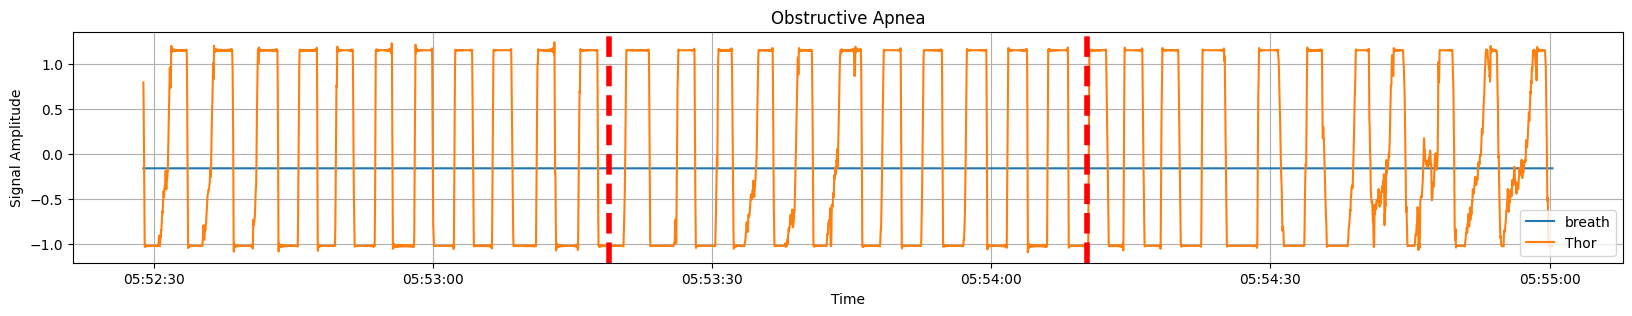

In [29]:
from datetime import datetime

idx = 216
start_datetime = obstructive_apnea_events.iloc[idx]['Start'] - pd.Timedelta(seconds=50)
end_datetime = obstructive_apnea_events.iloc[idx]['End'] + pd.Timedelta(seconds=50)
# Find subset of merged_df with index between start_datetime and end_datetime
obstructive_apnea_df = merged_df[(merged_df.index >= start_datetime) & (merged_df.index <= end_datetime)]

# Plot the aligned signals
plt.figure(figsize=(20, 3))
plt.plot(obstructive_apnea_df['breath'], label='breath')
plt.plot(obstructive_apnea_df['Thor'], label='Thor')
# plt.plot(radar_resampled, label='Low pass Filtered Radar Signal')
plt.xlabel('Time')
plt.ylabel('Signal Amplitude')
plt.title('Obstructive Apnea')
plt.legend()
plt.grid(True)

# Draw red vertical lines at specific timestamps
plt.axvline(x= obstructive_apnea_events.iloc[idx]['Start'], color='r', linestyle='--', linewidth=4)
plt.axvline(x= obstructive_apnea_events.iloc[idx]['End'], color='r', linestyle='--', linewidth=4)

In [30]:
def visualize_events_in_window(xml_processor, merged_df, target_event_type=None, idx=None, 
                             padding_seconds=None, start_time=None, end_time=None,
                             event_list=None):
    """
    Visualizes events within a specified time window with flexible behavior depending on parameters.
    
    Behavior modes:
    1. No parameters: Visualizes all events across the entire merged_df timespan
    2. Only start_time/end_time: Visualizes all events in the specified window
    3. target_event_type only: Highlights all events of specified type
    4. idx, target_event_type, padding_seconds: Focuses on a specific event (original behavior)
    
    Parameters:
    -----------
    xml_processor : XMLProcessor
        The XMLProcessor object containing the events data
    merged_df : pandas.DataFrame
        DataFrame with time-indexed signals to plot
    target_event_type : str, optional
        The type of event to highlight (e.g., 'Obstructive Apnea')
    idx : int, optional
        Index of the specific event in the filtered events list
    padding_seconds : int, optional
        Number of seconds to pad before and after the main event
    start_time : datetime, optional
        Start time of the window to visualize
    end_time : datetime, optional
        End time of the window to visualize
    event_list : list, optional
        List of event names to filter for (only these event types will be shown)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Apply event type filtering if event_list is provided
    if event_list is not None:
        all_events = xml_processor.events.copy()
        filtered_events = all_events[all_events['Name'].isin(event_list)]
        
        if filtered_events.empty:
            print(f"Warning: No events found with names: {event_list}")
            print(f"Available event types: {all_events['Name'].unique()}")
            # Continue with all events if filter would result in empty set
            working_events = all_events
        else:
            working_events = filtered_events
            print(f"Filtered to show only these event types: {event_list}")
    else:
        working_events = xml_processor.events
    
    # Determine the time window based on inputs
    if idx is not None and target_event_type is not None and padding_seconds is not None:
        # Scenario 4: Specific event with padding (original behavior)
        target_events = working_events[working_events['Name'] == target_event_type]
        
        if target_events.empty:
            raise ValueError(f"No events of type '{target_event_type}' found after filtering")
        
        if idx >= len(target_events):
            raise ValueError(f"Index {idx} is out of bounds for events of type '{target_event_type}' (max index: {len(target_events)-1})")
            
        # Get the target event
        target_event = target_events.iloc[idx]
        target_idx = target_events.index[idx]  # Store the actual index for reference
        
        # Define the padded window
        start_datetime = target_event['Start'] - pd.Timedelta(seconds=padding_seconds)
        end_datetime = target_event['End'] + pd.Timedelta(seconds=padding_seconds)
        
        title = f'Events Window: Target {target_event_type} (Index: {target_idx})'
        
    elif start_time is not None and end_time is not None:
        # Scenario 2: Custom time window
        start_datetime = start_time
        end_datetime = end_time
        target_idx = None
        
        title = f'Events between {start_datetime.strftime("%Y-%m-%d %H:%M:%S")} and {end_datetime.strftime("%Y-%m-%d %H:%M:%S")}'
        
    else:
        # Scenario 1: Full dataset range
        start_datetime = merged_df.index.min()
        end_datetime = merged_df.index.max()
        target_idx = None
        
        title = 'All Events in Dataset'
    
    # Find subset of merged_df within the time window
    window_df = merged_df[(merged_df.index >= start_datetime) & (merged_df.index <= end_datetime)]
    
    if window_df.empty:
        raise ValueError(f"No data found in the specified time range: {start_datetime} to {end_datetime}")
    
    # Find ALL events (of filtered types) within the time window
    all_window_events = working_events[
        (working_events['Start'] >= start_datetime) & 
        (working_events['End'] <= end_datetime)
    ].copy()
    
    if all_window_events.empty:
        print(f"No events found in the time window {start_datetime} to {end_datetime}")
        # Plot the signals anyway, but without events
        fig, ax = plt.subplots(figsize=(20, 4))
        for column in ['breath', 'Thor']:
            if column in window_df.columns:
                ax.plot(window_df.index, window_df[column], label=column)
        ax.set_xlabel('Time')
        ax.set_ylabel('Signal Amplitude')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        return fig
    
    # Add a column to identify the target event (if any)
    if target_idx is not None:
        all_window_events['is_target'] = all_window_events.index == target_idx
    else:
        all_window_events['is_target'] = False
    
    # Add a column to identify target event type (for Scenario 3)
    if target_event_type is not None:
        all_window_events['is_target_type'] = all_window_events['Name'] == target_event_type
    else:
        all_window_events['is_target_type'] = False
    
    # Sort events by start time
    all_window_events = all_window_events.sort_values('Start')
    
    # Get unique event types in the window
    event_types = all_window_events['Name'].unique()
    
    # Create a color map for different event types
    import matplotlib.colors as mcolors
    
    # Choose colors for event types
    other_colors = list(mcolors.TABLEAU_COLORS.values())
    color_map = {event_type: other_colors[i % len(other_colors)] 
                for i, event_type in enumerate(event_types)}
    
    # Print information about events in chronological order
    print(f"\n{'='*100}")
    
    if target_idx is not None:
        print(f"All events within the padded window ({padding_seconds}s before and after)")
        print(f"Target event: {target_event_type} (Index: {target_idx})")
    else:
        print(f"All events within the time window: {start_datetime} to {end_datetime}")
    
    if event_list is not None:
        print(f"Filtered to only include these event types: {event_list}")
    
    print(f"{'='*100}")
    print(f"{'Index':<10} {'Event Type':<25} {'Start Time':<25} {'End Time':<25} {'Duration (s)':<15} {'Is Target':<10}")
    print(f"{'-'*100}")
    
    for i, event in all_window_events.iterrows():
        duration = (event['End'] - event['Start']).total_seconds()
        target_marker = "* TARGET *" if event['is_target'] else ""
        print(f"{i:<10} {event['Name']:<25} {event['Start']!s:<25} {event['End']!s:<25} {duration:<15.2f} {target_marker:<10}")
    
    print(f"{'='*100}")
    print(f"Total events in window: {len(all_window_events)}")
    print(f"Event types present: {', '.join(event_types)}")
    print(f"{'='*100}\n")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(20, 4))
    
    # Plot the signals
    for column in ['breath', 'Thor']:
        if column in window_df.columns:
            ax.plot(window_df.index, window_df[column], label=column)
    
    # Create legend handles for event types
    from matplotlib.lines import Line2D
    legend_elements = []
    
    # Draw events on the plot
    for event_type in event_types:
        events_of_this_type = all_window_events[all_window_events['Name'] == event_type]
        
        # Get color for this event type
        color = color_map[event_type]
        
        # Use same line style and width for all event types
        linewidth = 1.5
        linestyle = '--'
        alpha_value = 0.5
        
        # Add to legend once per event type
        legend_elements.append(Line2D([0], [0], color=color, lw=linewidth, 
                                    linestyle=linestyle, 
                                    label=f"{event_type} ({len(events_of_this_type)})"))
        
        # Draw each event of this type
        for i, event in events_of_this_type.iterrows():
            is_target_instance = event['is_target']
            is_target_type = event['is_target_type']
            
            # All events have the same style
            line_width = linewidth
            span_alpha = alpha_value
            
            # Draw vertical lines at start and end
            ax.axvline(x=event['Start'], color=color, linestyle=linestyle, linewidth=line_width)
            ax.axvline(x=event['End'], color=color, linestyle=linestyle, linewidth=line_width)
            
            # Add spans
            ax.axvspan(event['Start'], event['End'], alpha=span_alpha, color=color)
            
            # Add event index text with appropriate styling
            mid_time = event['Start'] + (event['End'] - event['Start'])/2
            y_pos = 0.1 if event_type == target_event_type else 0.05
            
            # Style based on if it's the target instance or target type
            if is_target_instance:
                # Target instance (specific event)
                ax.text(mid_time, y_pos, f"{i}", transform=ax.get_xaxis_transform(), 
                       ha='center', va='bottom', fontsize=10, color='red', weight='bold',
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
            elif is_target_type and target_idx is None:
                # For scenario 3: Highlight all events of target type
                ax.text(mid_time, y_pos, f"{i}", transform=ax.get_xaxis_transform(), 
                       ha='center', va='bottom', fontsize=9, color='red', weight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
            else:
                # Normal events
                ax.text(mid_time, y_pos, f"{i}", transform=ax.get_xaxis_transform(), 
                       ha='center', va='bottom', fontsize=8, 
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    # Set plot labels and properties
    ax.set_xlabel('Time')
    ax.set_ylabel('Signal Amplitude')
    ax.set_title(title + (" (filtered)" if event_list is not None else ""))
    
    # Add signal traces to legend
    for column in ['breath', 'Thor']:
        if column in window_df.columns:
            legend_elements.append(Line2D([0], [0], color=ax.get_lines()[-2 if 'breath' in window_df.columns and 'Thor' in window_df.columns else -1].get_color(), 
                                         lw=2, label=column))
    
    # Place legend outside the plot
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1), 
              borderaxespad=0, fontsize=10)
    
    ax.grid(True)
    
    # Format time axis
    plt.gcf().autofmt_xdate()
    
    # Add information about the time window
    time_window = (end_datetime - start_datetime).total_seconds()
    plt.figtext(0.3, 0.98, f"Time Window: {time_window:.0f} seconds", 
                ha="center", fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # If we have a target event, add info about its duration
    if target_idx is not None:
        event_duration = (target_event['End'] - target_event['Start']).total_seconds()
        plt.figtext(0.15, 0.98, f"Target Duration: {event_duration:.2f}s", 
                    ha="center", fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # Add more spacing at the top for the annotations
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    return fig

In [31]:
print(merged_df.index[0])
print(merged_df.index[-1])

2025-02-26 23:39:10.746241
2025-02-27 06:09:49.980616


In [32]:
xml_processor.events[xml_processor.events['Name'] == 'Obstructive Apnea']

,Name,Actual Start (sec),Duration,Start,End,Input
32,Obstructive Apnea,2065.35,22.65,2025-02-26 22:34:35.350,2025-02-26 22:34:58.000,Nasal Pressure
34,Obstructive Apnea,2132.50,29.50,2025-02-26 22:35:42.500,2025-02-26 22:36:12.000,Nasal Pressure
38,Obstructive Apnea,2258.70,24.76,2025-02-26 22:37:48.700,2025-02-26 22:38:13.460,Nasal Pressure
60,Obstructive Apnea,2555.20,31.20,2025-02-26 22:42:45.200,2025-02-26 22:43:16.400,Nasal Pressure
66,Obstructive Apnea,2628.50,36.20,2025-02-26 22:43:58.500,2025-02-26 22:44:34.700,Nasal Pressure
...,...,...,...,...,...,...
1045,Obstructive Apnea,28388.90,51.40,2025-02-27 05:53:18.900,2025-02-27 05:54:10.300,Nasal Pressure
1050,Obstructive Apnea,28465.90,48.40,2025-02-27 05:54:35.900,2025-02-27 05:55:24.300,Nasal Pressure
1052,Obstructive Apnea,28536.60,58.10,2025-02-27 05:55:46.600,2025-02-27 05:56:44.700,Nasal Pressure
1054,Obstructive Apnea,28612.70,50.70,2025-02-27 05:57:02.700,2025-02-27 05:57:53.400,Nasal Pressure


Filtered to show only these event types: ['Obstructive Apnea', 'Limb Movement (Right)', 'Limb Movement (Left)', 'PLM (Left)', 'PLM (Right)']

All events within the time window: 2025-02-27 05:55:00 to 2025-02-27 06:00:00
Filtered to only include these event types: ['Obstructive Apnea', 'Limb Movement (Right)', 'Limb Movement (Left)', 'PLM (Left)', 'PLM (Right)']
Index      Event Type                Start Time                End Time                  Duration (s)    Is Target 
----------------------------------------------------------------------------------------------------
1052       Obstructive Apnea         2025-02-27 05:55:46.600000 2025-02-27 05:56:44.700000 58.10                     
1054       Obstructive Apnea         2025-02-27 05:57:02.700000 2025-02-27 05:57:53.400000 50.70                     
1057       Obstructive Apnea         2025-02-27 05:58:09       2025-02-27 05:58:43.500000 34.50                     
1060       PLM (Right)               2025-02-27 05:59:32.500000 20

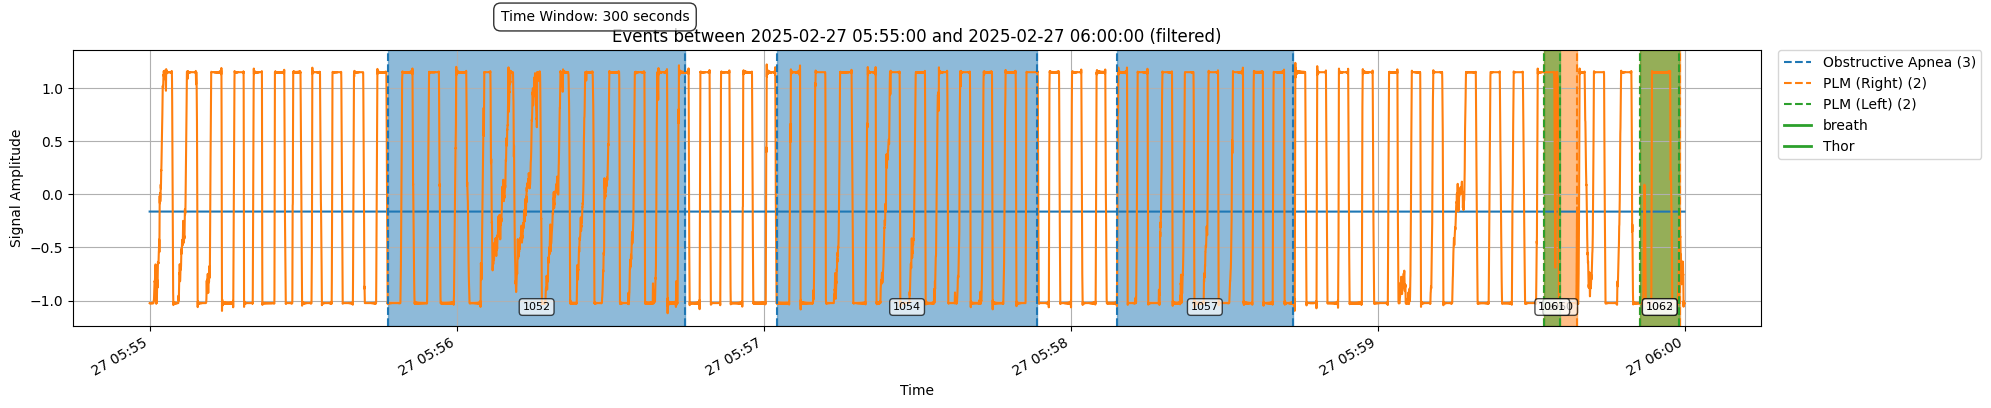

In [33]:
# # Show only Obstructive Apnea and Central Apnea events across all data
# fig = visualize_events_in_window(
#     xml_processor=xml_processor,
#     merged_df=merged_df,
#     event_list=['Obstructive Apnea', 'Central Apnea']
# )

# Combined: Show only Obstructive Apnea and Mixed Apnea in a specific time window
fig = visualize_events_in_window(
    xml_processor=xml_processor,
    merged_df=merged_df,
    start_time=pd.Timestamp('2025-02-27 5:55:00'),
    end_time=pd.Timestamp('2025-02-27 6:00:00'),
    event_list=['Obstructive Apnea', 'Limb Movement (Right)', 'Limb Movement (Left)', 'PLM (Left)', 'PLM (Right)']
)

# # Combined: Focus on a specific Obstructive Apnea, but also show any neighboring
# # Hypopnea events in the padded window
# fig = visualize_events_in_window(
#     xml_processor=xml_processor,
#     merged_df=merged_df,
#     target_event_type='Obstructive Apnea',
#     idx=100,
#     padding_seconds=80,
#   event_list=['Obstructive Apnea', 'Limb Movement (Right)', 'Limb Movement (Left)', 'PLM (Left)', 'PLM (Right)',
#             'Arousal (ARO SPONT)', 'Arousal (ARO RES)', 'Arousal (ARO PLM)'])

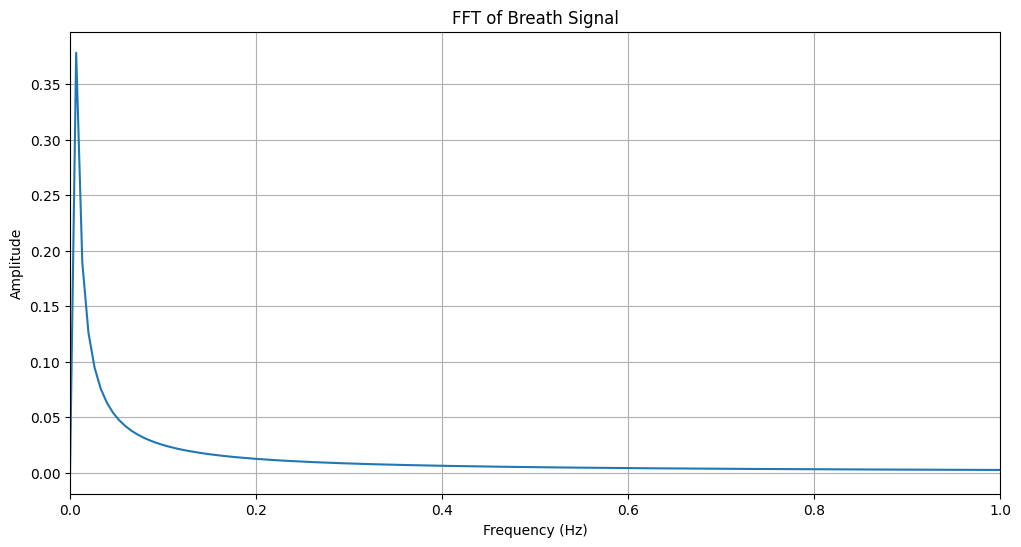

Highest point in FFT of Breath Signal: Frequency = 0.006604747162022704 Hz, Amplitude = 0.3784624986774577


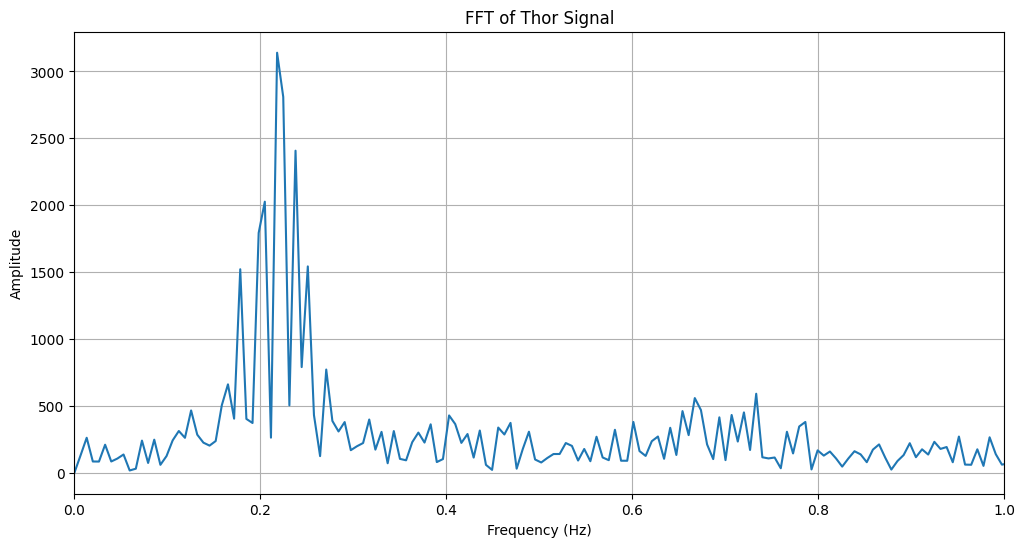

Highest point in FFT of Thor Signal: Frequency = 0.2179566563467492 Hz, Amplitude = 3139.992061159504


In [34]:
# Example usage
sample_rate = 64  # Replace with the actual sample rate of your data

# Run FFT analysis on 'breath' column
breath_max_freq, breath_max_amplitude = plot_fft(obstructive_apnea_df['breath'].values, sample_rate, 'FFT of Breath Signal')
print(f"Highest point in FFT of Breath Signal: Frequency = {breath_max_freq} Hz, Amplitude = {breath_max_amplitude}")

# Run FFT analysis on 'Thor' column
thor_max_freq, thor_max_amplitude = plot_fft(obstructive_apnea_df['Thor'].values, sample_rate, 'FFT of Thor Signal')
print(f"Highest point in FFT of Thor Signal: Frequency = {thor_max_freq} Hz, Amplitude = {thor_max_amplitude}")

##### Plotting the signals for each occurrence of a specific event type

In [57]:
event_counts = xml_processor.events['Name'].value_counts()
print(event_counts)

Name
Arousal (ARO RES)        225
Obstructive Apnea        221
SpO2 desaturation        166
Limb Movement (Right)    102
Arousal (ARO SPONT)       98
Hypopnea                  77
PLM (Left)                75
Limb Movement (Left)      67
PLM (Right)               67
Arousal (ARO PLM)          3
Unsure                     1
Name: count, dtype: int64


256


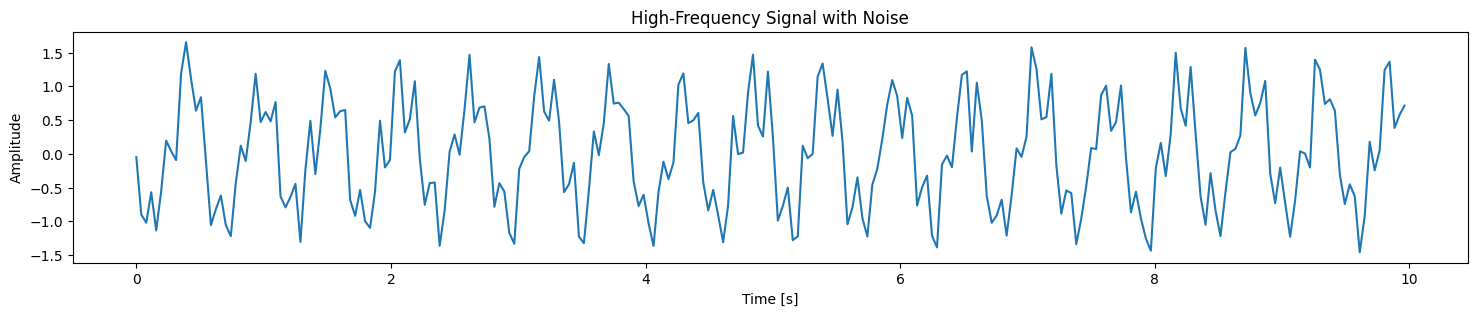

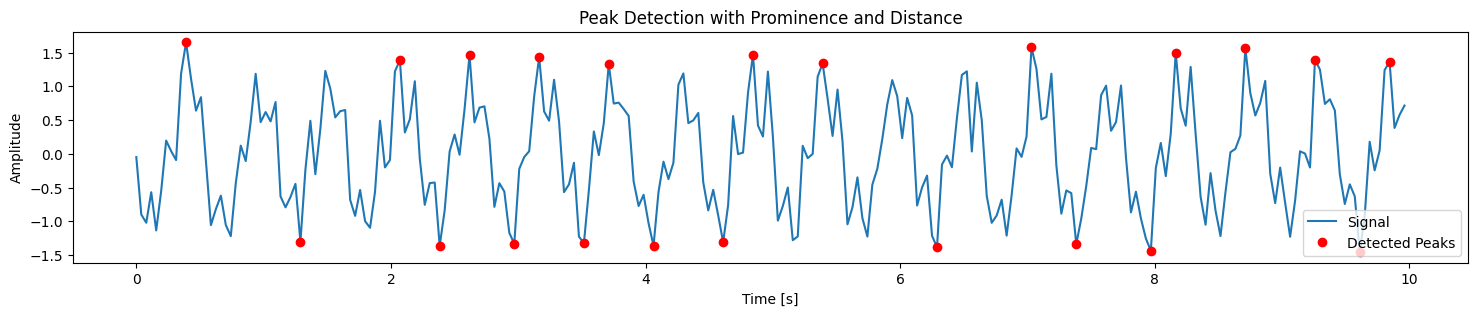

Detected peaks at indices: [ 10  53  67  81  95 124 138 180 209 223 237 252  33  61  76  90 104 118
 161 189 204 246]
Peak properties: {'peak_heights': array([1.65389249, 1.38694641, 1.4672767 , 1.43342926, 1.33084211,
       1.46942901, 1.33942553, 1.57855451, 1.49844992, 1.56954668,
       1.39514271, 1.36340905]), 'prominences': array([2.78820086, 2.69158953, 2.83033089, 2.7657692 , 2.65504254,
       2.83348491, 2.61841973, 2.96368209, 2.71609654, 3.00494119,
       2.62322283, 0.97976293]), 'left_bases': array([  4,  33,  61,  76,  90, 104, 132, 161, 204, 204, 232, 246]), 'right_bases': array([246,  61, 104, 104, 104, 161, 161, 246, 218, 246, 246, 253])}


In [58]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Generate a synthetic high-frequency signal with two large peaks and noise
fs = 256  # Sampling frequency (high-frequency)
t = np.linspace(0, 10, fs, endpoint=False)  # Time vector
signal1 = np.sin(3 * np.pi * 50 * t) + 0.5 * np.sin(3 * np.pi * 200 * t)  # Combination of two sine waves
print(len(signal1))
# Add some noise
signal1 += 0.2 * np.random.normal(size=t.shape)

# Plot the signal to visualize
plt.plot(t, signal1)
plt.title('High-Frequency Signal with Noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Use find_peaks with prominence and distance
prominence_value = 0.8  # Minimum prominence required for peak detection
distance_value = 10  # Minimum distance between consecutive peaks (in samples)
height = 1.3  # Minimum height of peaks

peaks, properties = find_peaks(signal1, prominence=prominence_value, distance=distance_value, height=height)
peaks2, properties2 = find_peaks(-signal1, prominence=prominence_value, distance=distance_value, height=height)

peaks = np.concatenate((peaks, peaks2), axis=0)

# Plot the results
plt.plot(t, signal1, label='Signal')
plt.plot(t[peaks], signal1[peaks], 'ro', label='Detected Peaks')
plt.title('Peak Detection with Prominence and Distance')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the detected peaks
print("Detected peaks at indices:", peaks)
print("Peak properties:", properties)


Breath Peak Widths: []
Thor Peak Widths: [122.56554065 132.4502413  109.86191809 111.18250329 131.70972369
 110.33355807 108.20750353 137.76013777 124.56919895 122.20753434
 126.41331436 126.46911664 140.57849827 137.98147636 132.64574214
 143.20050622 106.69657167 119.66578513 121.8304103  105.27980203
 118.73848875 135.43368745 130.52049418]


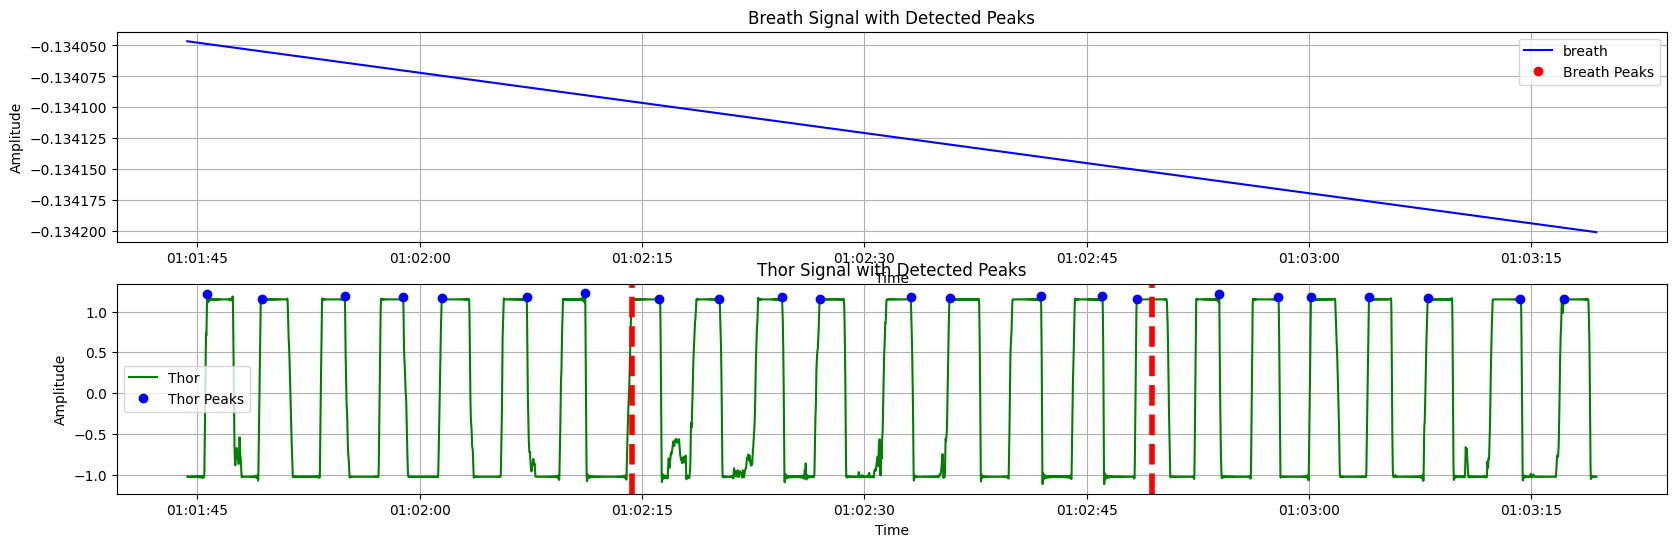

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from datetime import datetime

# Sample datetime range and dataframe filtering (assuming merged_df exists)
index = 100  # Define the index to use for setting the data point
sec = 30 # seconds
start_datetime = obstructive_apnea_events.iloc[index]['Start'] - pd.Timedelta(seconds=sec)  # Use the start time from obstructive_apnea_events with 10 sec padding
end_datetime = obstructive_apnea_events.iloc[index]['End'] + pd.Timedelta(seconds=sec)  # Use the end time from obstructive_apnea_events with 10 sec padding


# Find subset of merged_df with index between start_datetime and end_datetime
obstructive_apnea_df = merged_df[(merged_df.index >= start_datetime) & (merged_df.index <= end_datetime)]

# Identify peaks for 'breath' and 'Thor' signals
breath_peaks, properties1 = find_peaks(obstructive_apnea_df['breath'], prominence=0.3, distance=128, height=0.9, width=50)
thor_peaks, properties2 = find_peaks(obstructive_apnea_df['Thor'], prominence=0.3, distance=128, height=0.9, width=50)

# Print the peak widths
print("Breath Peak Widths:", properties1['widths'])
print("Thor Peak Widths:", properties2['widths'])

# Plot the aligned signals
plt.figure(figsize=(20, 6))

# Plot 'breath' signal and its detected peaks
plt.subplot(2, 1, 1)
plt.plot(obstructive_apnea_df['breath'], label='breath', color='b')
plt.plot(obstructive_apnea_df.index[breath_peaks], obstructive_apnea_df['breath'].iloc[breath_peaks], 'ro', label='Breath Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Breath Signal with Detected Peaks')
plt.legend()
plt.grid(True)

# Plot 'Thor' signal and its detected peaks
plt.subplot(2, 1, 2)
plt.plot(obstructive_apnea_df['Thor'], label='Thor', color='g')
plt.plot(obstructive_apnea_df.index[thor_peaks], obstructive_apnea_df['Thor'].iloc[thor_peaks], 'bo', label='Thor Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Thor Signal with Detected Peaks')
plt.legend()
plt.grid(True)

# Plot the events with red vertical lin
# Draw red vertical lines at specific timestamps
plt.axvline(x= obstructive_apnea_events.iloc[index]['Start'], color='r', linestyle='--', linewidth=4)
plt.axvline(x= obstructive_apnea_events.iloc[index]['End'], color='r', linestyle='--', linewidth=4)

#### Lag Time Analysis

In [50]:
obstructive_apnea_events = xml_processor.events[xml_processor.events['Name'] == 'Obstructive Apnea']
obstructive_apnea_events

,Name,Actual Start (sec),Duration,Start,End,Input
32,Obstructive Apnea,2065.35,22.65,2025-02-26 22:34:35.350,2025-02-26 22:34:58.000,Nasal Pressure
34,Obstructive Apnea,2132.50,29.50,2025-02-26 22:35:42.500,2025-02-26 22:36:12.000,Nasal Pressure
38,Obstructive Apnea,2258.70,24.76,2025-02-26 22:37:48.700,2025-02-26 22:38:13.460,Nasal Pressure
60,Obstructive Apnea,2555.20,31.20,2025-02-26 22:42:45.200,2025-02-26 22:43:16.400,Nasal Pressure
66,Obstructive Apnea,2628.50,36.20,2025-02-26 22:43:58.500,2025-02-26 22:44:34.700,Nasal Pressure
...,...,...,...,...,...,...
1045,Obstructive Apnea,28388.90,51.40,2025-02-27 05:53:18.900,2025-02-27 05:54:10.300,Nasal Pressure
1050,Obstructive Apnea,28465.90,48.40,2025-02-27 05:54:35.900,2025-02-27 05:55:24.300,Nasal Pressure
1052,Obstructive Apnea,28536.60,58.10,2025-02-27 05:55:46.600,2025-02-27 05:56:44.700,Nasal Pressure
1054,Obstructive Apnea,28612.70,50.70,2025-02-27 05:57:02.700,2025-02-27 05:57:53.400,Nasal Pressure


Calculated lag time: -15.406 seconds (-986 samples)
Time lag: -15.406 seconds
Lag in samples: -986
Maximum correlation coefficient: 16.529


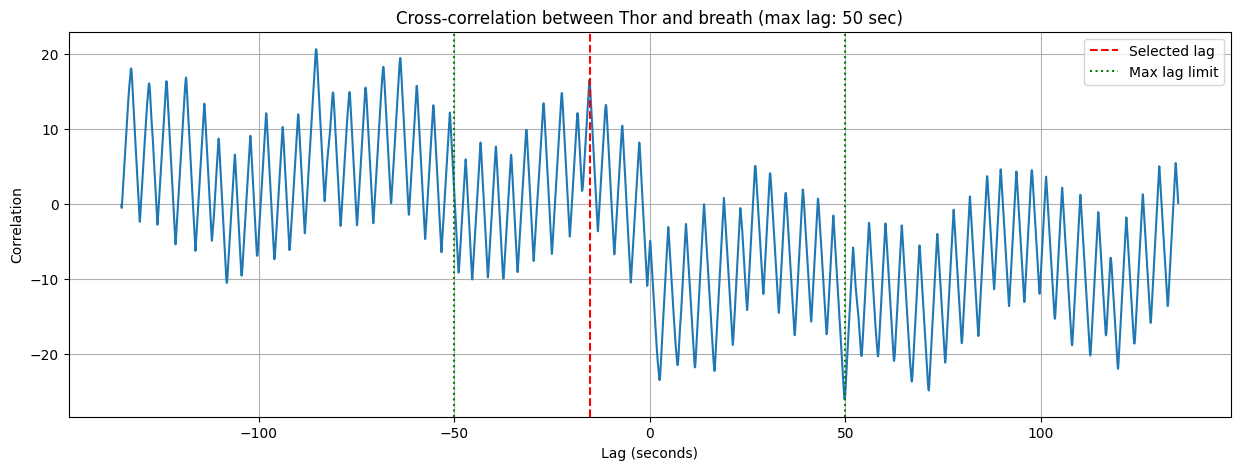

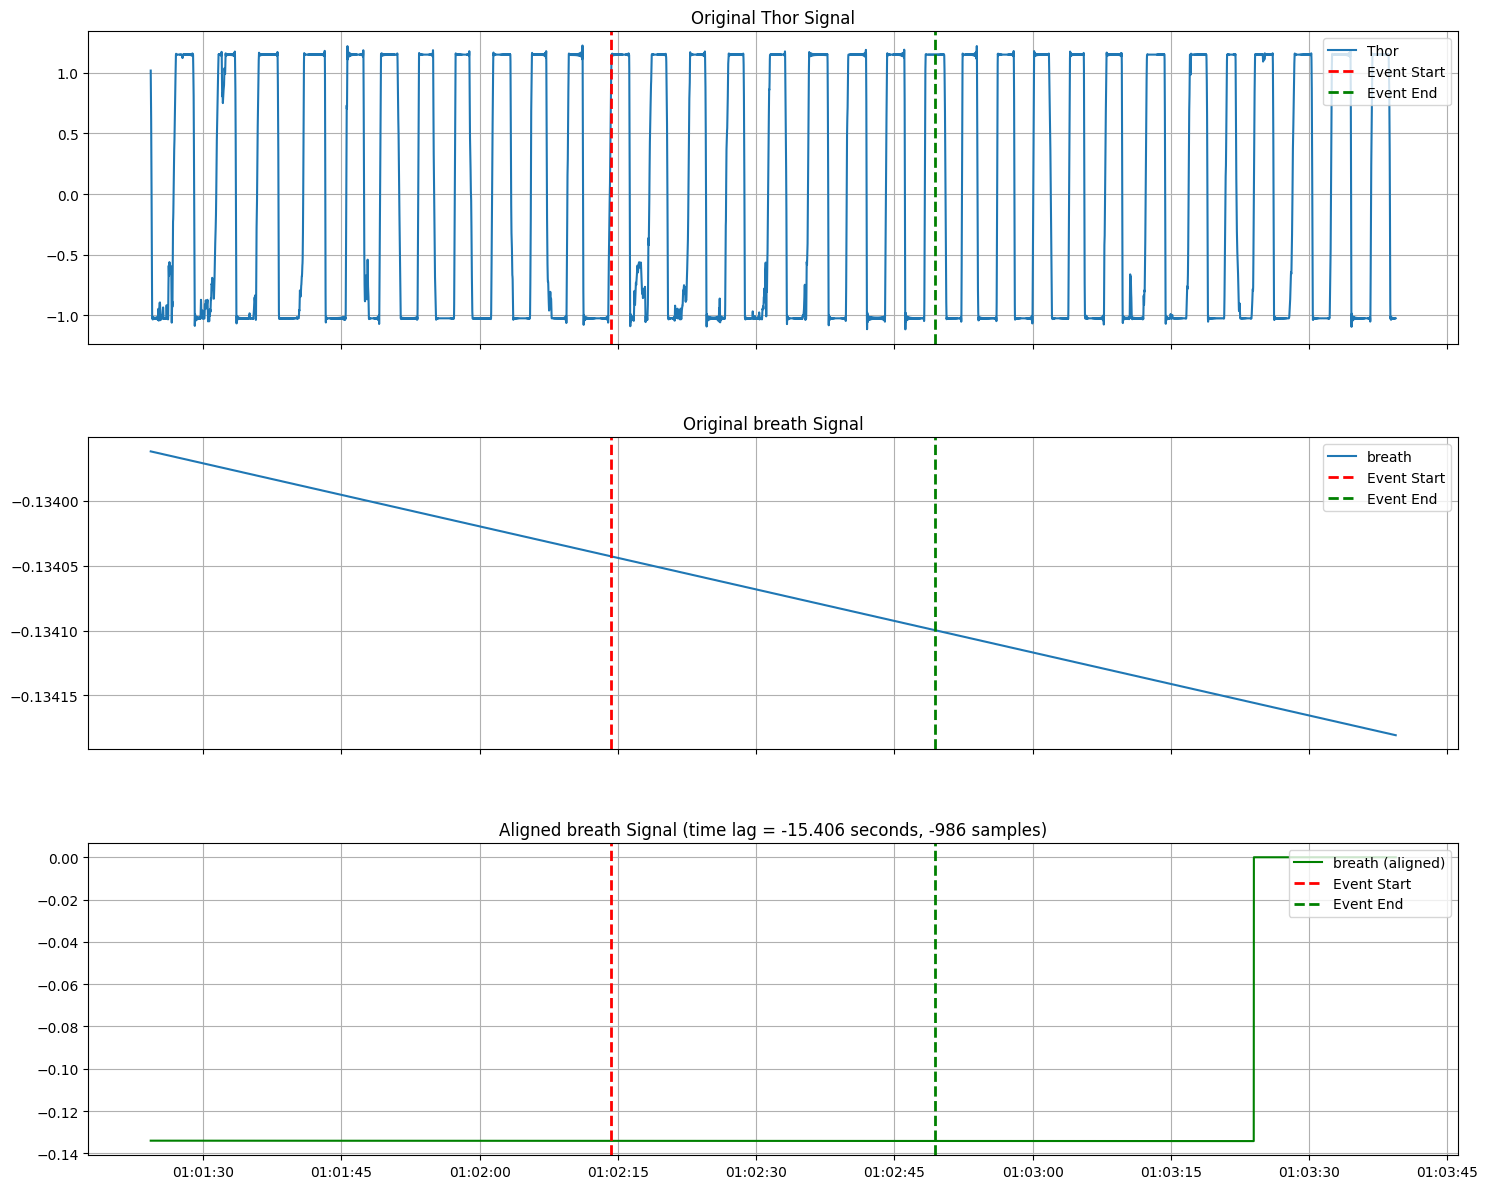

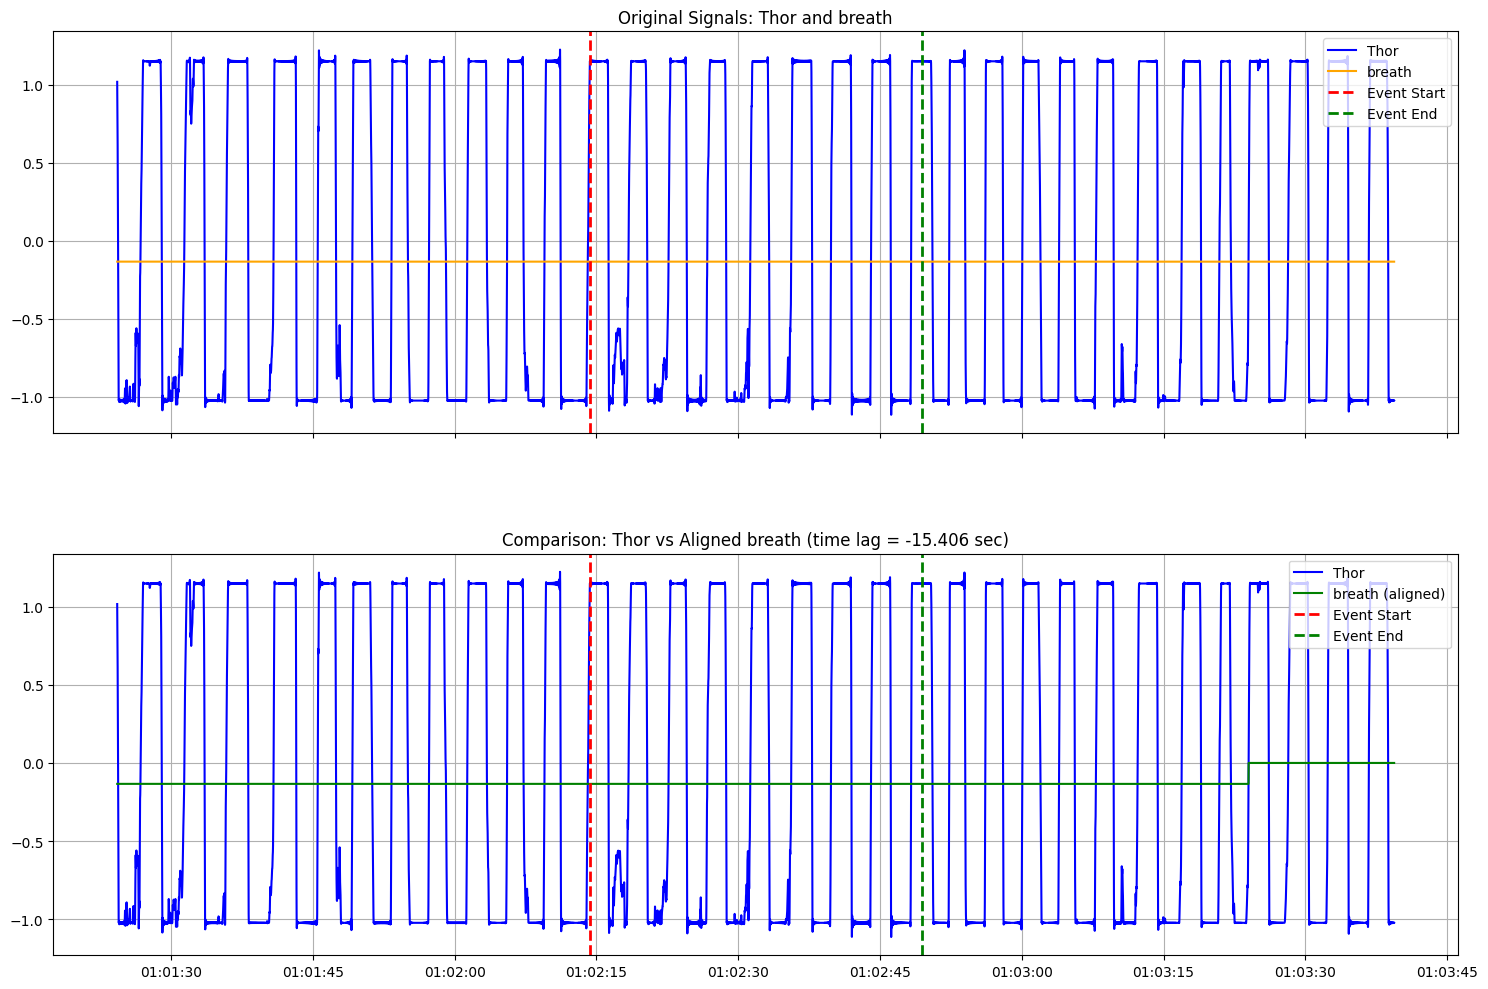

In [51]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import pandas as pd

def analyze_time_lag(merged_df, events_df, index, sec=50, signal1='Thor', signal2='breath', 
                    sampling_rate=64, max_lag_seconds=50, fixed_lag_time=None):
    """
    Analyze the time lag between two signals using cross-correlation.
    Shows both separate vertical plots and combined plots.
    
    Parameters:
    merged_df: DataFrame containing the signals
    events_df: DataFrame containing event times with 'Start' and 'End' columns
    index: index of the event to analyze in events_df
    sec: seconds of padding before and after the event (default 50)
    signal1, signal2: names of the signals to compare
    sampling_rate: Hz (default 64 for your case)
    max_lag_seconds: maximum lag time to consider in seconds (default 50)
    fixed_lag_time: optional, if provided uses this lag time in seconds instead of calculating it
    
    Returns:
    lag_time: time lag in seconds
    lag_samples: lag in number of samples
    correlation: correlation coefficient
    """
    # Calculate start and end datetime
    start_datetime = events_df.iloc[index]['Start'] - pd.Timedelta(seconds=sec)
    end_datetime = events_df.iloc[index]['End'] + pd.Timedelta(seconds=sec)
    
    # Find subset of merged_df with index between start_datetime and end_datetime
    df = merged_df[(merged_df.index >= start_datetime) & (merged_df.index <= end_datetime)]
    
    # Get the signals
    s1 = df[signal1].values
    s2 = df[signal2].values
    
    # Compute cross-correlation
    correlation = signal.correlate(s1, s2, mode='full')
    lags = signal.correlation_lags(len(s1), len(s2), mode='full')
    
    # Process based on whether fixed lag is provided
    if fixed_lag_time is not None:
        # Convert fixed lag time to samples
        lag_samples = int(fixed_lag_time * sampling_rate)
        lag_time = fixed_lag_time
        
        # Find the corresponding correlation value
        # Find the index in lags array that is closest to lag_samples
        closest_lag_idx = np.argmin(np.abs(lags - lag_samples))
        max_correlation = correlation[closest_lag_idx]
        
        print(f"Using fixed lag time: {lag_time:.3f} seconds ({lag_samples} samples)")
    else:
        # Convert max_lag_seconds to samples
        max_lag_samples = int(max_lag_seconds * sampling_rate)
        
        # Create a mask for lags within our range
        valid_lags_mask = np.abs(lags) <= max_lag_samples
        
        # Apply mask to both lags and correlation
        valid_lags = lags[valid_lags_mask]
        valid_correlation = correlation[valid_lags_mask]
        
        # Find the lag with maximum correlation within the valid range
        max_corr_idx = np.argmax(valid_correlation)
        lag_samples = valid_lags[max_corr_idx]
        lag_time = lag_samples / sampling_rate
        max_correlation = valid_correlation[max_corr_idx]
        
        print(f"Calculated lag time: {lag_time:.3f} seconds ({lag_samples} samples)")
    
    # Create aligned version of second signal
    if lag_samples > 0:
        s2_aligned = np.pad(s2[:-lag_samples], (lag_samples, 0), mode='constant')
    else:
        s2_aligned = np.pad(s2[-lag_samples:], (0, -lag_samples), mode='constant')
    
    # FIGURE 1: Cross-correlation plot
    plt.figure(figsize=(15, 5))
    plt.plot(lags/sampling_rate, correlation)
    plt.axvline(x=lag_time, color='r', linestyle='--', label='Selected lag')
    
    if fixed_lag_time is None:
        # Add vertical lines showing the range we're considering
        plt.axvline(x=-max_lag_seconds, color='g', linestyle=':', label='Max lag limit')
        plt.axvline(x=max_lag_seconds, color='g', linestyle=':')
        title_suffix = f"(max lag: {max_lag_seconds} sec)"
    else:
        title_suffix = f"(fixed lag: {fixed_lag_time} sec)"
    
    plt.title(f'Cross-correlation between {signal1} and {signal2} {title_suffix}')
    plt.xlabel('Lag (seconds)')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.legend()
    
    # FIGURE 2: Separate vertical plots
    fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    
    # Plot first original signal
    ax1.plot(df.index, s1, label=signal1)
    ax1.set_title(f'Original {signal1} Signal')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    # Add event lines
    ax1.axvline(x=events_df.iloc[index]['Start'], color='r', linestyle='--', linewidth=2, label='Event Start')
    ax1.axvline(x=events_df.iloc[index]['End'], color='g', linestyle='--', linewidth=2, label='Event End')
    ax1.legend(loc='upper right')
    
    # Plot second original signal
    ax2.plot(df.index, s2, label=signal2)
    ax2.set_title(f'Original {signal2} Signal')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    # Add event lines
    ax2.axvline(x=events_df.iloc[index]['Start'], color='r', linestyle='--', linewidth=2, label='Event Start')
    ax2.axvline(x=events_df.iloc[index]['End'], color='g', linestyle='--', linewidth=2, label='Event End')
    ax2.legend(loc='upper right')
    
    # Plot aligned second signal
    ax3.plot(df.index, s2_aligned, label=f'{signal2} (aligned)', color='green')
    ax3.set_title(f'Aligned {signal2} Signal (time lag = {lag_time:.3f} seconds, {lag_samples} samples)')
    ax3.legend(loc='upper right')
    ax3.grid(True)
    # Add event lines
    ax3.axvline(x=events_df.iloc[index]['Start'], color='r', linestyle='--', linewidth=2, label='Event Start')
    ax3.axvline(x=events_df.iloc[index]['End'], color='g', linestyle='--', linewidth=2, label='Event End')
    ax3.legend(loc='upper right')
    
    # Format x-axis to show time properly if index is datetime
    if isinstance(df.index, pd.DatetimeIndex):
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add space between subplots
    
    # FIGURE 3: Combined plots showing both signals together
    fig3, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Plot both original signals on the same subplot
    ax1.plot(df.index, s1, label=signal1, color='blue')
    ax1.plot(df.index, s2, label=signal2, color='orange')
    ax1.set_title(f'Original Signals: {signal1} and {signal2}')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    # Add event lines
    ax1.axvline(x=events_df.iloc[index]['Start'], color='r', linestyle='--', linewidth=2, label='Event Start')
    ax1.axvline(x=events_df.iloc[index]['End'], color='g', linestyle='--', linewidth=2, label='Event End')
    ax1.legend(loc='upper right')
    
    # Plot original signal 1 and aligned signal 2 on same subplot
    ax2.plot(df.index, s1, label=signal1, color='blue')
    ax2.plot(df.index, s2_aligned, label=f'{signal2} (aligned)', color='green')
    ax2.set_title(f'Comparison: {signal1} vs Aligned {signal2} (time lag = {lag_time:.3f} sec)')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    # Add event lines
    ax2.axvline(x=events_df.iloc[index]['Start'], color='r', linestyle='--', linewidth=2, label='Event Start')
    ax2.axvline(x=events_df.iloc[index]['End'], color='g', linestyle='--', linewidth=2, label='Event End')
    ax2.legend(loc='upper right')
    
    # Format x-axis to show time properly if index is datetime
    if isinstance(df.index, pd.DatetimeIndex):
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add space between subplots
    
    return lag_time, lag_samples, max_correlation

# Example usage
fixed_lag = 32.375
lag_time, lag_samples, correlation = analyze_time_lag(merged_df, obstructive_apnea_events, 
                                                     index=100, sec=50)

print(f"Time lag: {lag_time:.3f} seconds")
print(f"Lag in samples: {lag_samples}")
print(f"Maximum correlation coefficient: {correlation:.3f}")

In [52]:
def shift_breath_column(df, lag_time_seconds):
    """
    Shifts the 'breath' column ahead by lag_time_seconds and returns 
    a dataframe with only the overlapping rows.
    
    Parameters:
    df: DataFrame with datetime index
    lag_time_seconds: Time in seconds to shift the breath column
    
    Returns:
    DataFrame with breath column shifted and only overlapping rows
    """
    # Create a copy of the original dataframe
    result_df = df.copy()
    
    # Calculate the time delta for shifting
    time_delta = pd.Timedelta(seconds=lag_time_seconds)
    
    # Extract the breath column
    breath_series = df['breath'].copy()
    
    # Shift the index forward by the time delta (this shifts the data earlier)
    breath_series.index = breath_series.index - time_delta
    
    # Create a new dataframe with just the shifted breath column
    shifted_breath_df = pd.DataFrame({'breath_shifted': breath_series})
    
    # Merge the original dataframe with the shifted breath dataframe on the index
    merged_result = pd.merge(result_df, shifted_breath_df, 
                            left_index=True, right_index=True, 
                            how='inner')  # inner join keeps only overlapping rows
    
    # Replace the original breath column with the shifted one
    merged_result['breath'] = merged_result['breath_shifted']
    
    # Drop the temporary column
    merged_result = merged_result.drop('breath_shifted', axis=1)
    
    return merged_result

# Example: Shift the breath column by 2.5 seconds
lag_time = fixed_lag  # in seconds
aligned_df = shift_breath_column(merged_df, lag_time)

# Check the shapes to see how many rows were kept
print(f"Original shape: {merged_df.shape}")
print(f"Aligned shape: {aligned_df.shape}")

Original shape: (1500112, 26)
Aligned shape: (1498040, 26)


In [53]:
merged_df = aligned_df

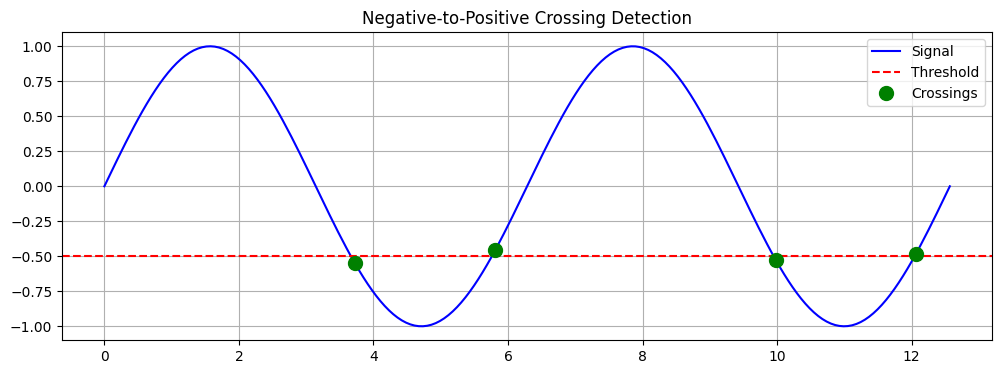

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample signal
t = np.linspace(0, 4*np.pi, 200)
sig = np.sin(t)
threshold = 0.5

# Show crossing detection
plt.figure(figsize=(12, 4))
plt.plot(t, sig, 'b-', label='Signal')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')

# Highlight crossings
crossings1 = ((sig[:-1] < -threshold) & (sig[1:] >= -threshold))
crossings2 = ((sig[:-1] > -threshold) & (sig[1:] <= -threshold))
crossings = crossings1 | crossings2

plt.plot(t[1:][crossings], sig[1:][crossings], 'go', 
         markersize=10, label='Crossings')

plt.grid(True)
plt.legend()
plt.title('Negative-to-Positive Crossing Detection')
plt.show()

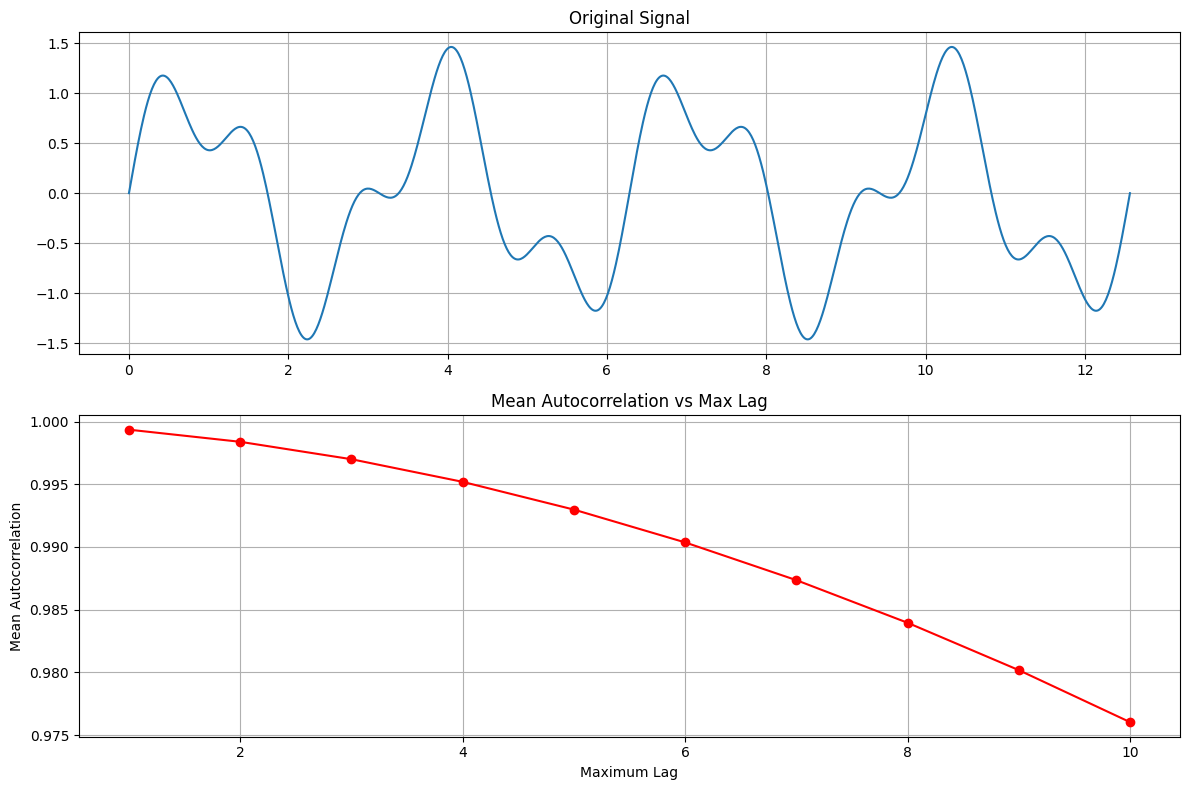

Autocorrelation values:
Max lag 1: 0.999
Max lag 2: 0.998
Max lag 3: 0.997
Max lag 4: 0.995
Max lag 5: 0.993
Max lag 6: 0.990
Max lag 7: 0.987
Max lag 8: 0.984
Max lag 9: 0.980
Max lag 10: 0.976


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate sample signal
t = np.linspace(0, 4*np.pi, 1000)
sig = np.sin(2*t) + 0.5*np.sin(5*t)

# 2. Original function
def calculate_autocorrelation_multi_lag(values, max_lag=10):
    # Return NaN if signal too short
    if len(values) <= max_lag:
        return np.nan
    
    # Calculate autocorrelation for each lag
    autocorrs = [np.corrcoef(values[:-lag], values[lag:])[0, 1] 
                 for lag in range(1, max_lag+1)]
    
    # Filter out NaN values
    autocorrs = [ac for ac in autocorrs if not np.isnan(ac)]
    
    # Return mean autocorrelation
    return np.mean(autocorrs) if autocorrs else np.nan

# 3. Demonstrate usage
lags = range(1, 11)
auto_corrs = []

for lag in lags:
    result = calculate_autocorrelation_multi_lag(sig, lag)
    auto_corrs.append(result)

# 4. Visualize
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(t, sig)
plt.title('Original Signal')
plt.grid(True)

plt.subplot(212)
plt.plot(lags, auto_corrs, 'ro-')
plt.title('Mean Autocorrelation vs Max Lag')
plt.xlabel('Maximum Lag')
plt.ylabel('Mean Autocorrelation')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print numeric results
print("Autocorrelation values:")
for lag, corr in zip(lags, auto_corrs):
    print(f"Max lag {lag}: {corr:.3f}")

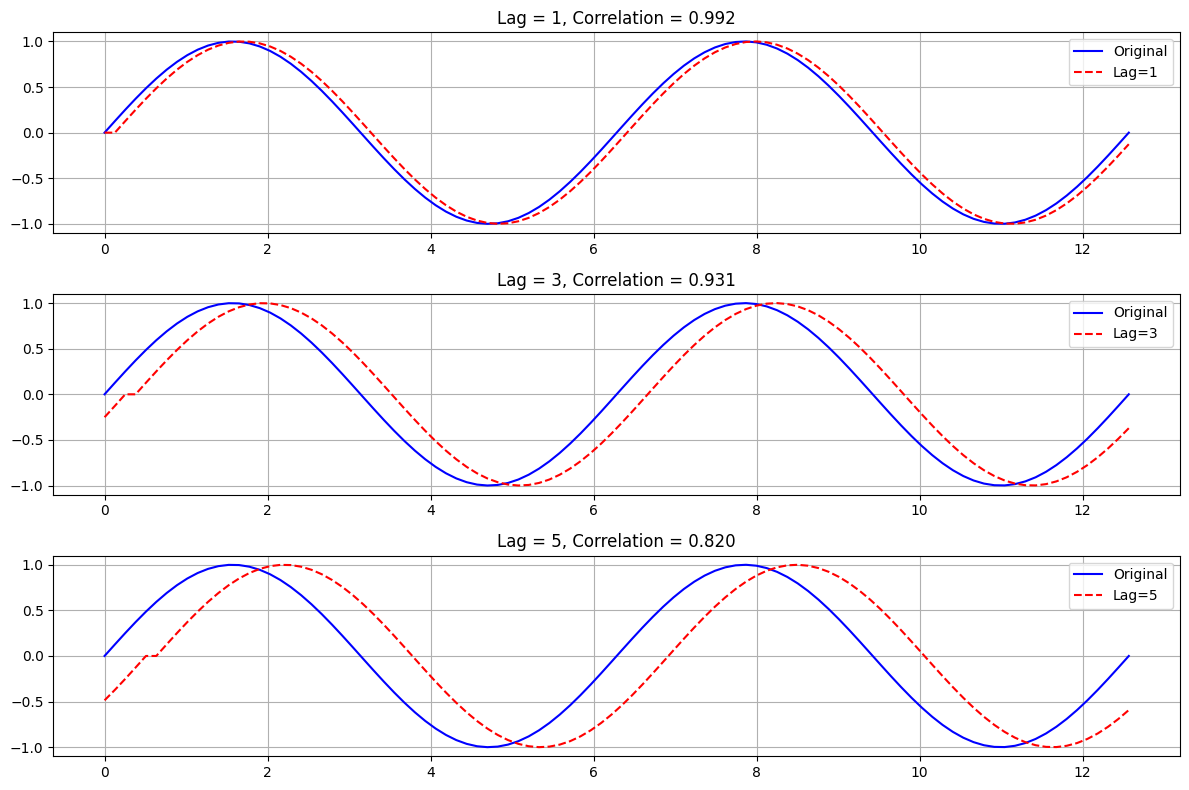

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample signal
t = np.linspace(0, 4*np.pi, 100)
sig = np.sin(t)

# Show original vs lagged signals for different lags
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

for i, lag_value in enumerate([1, 3, 5]):
    # Original signal
    axs[i].plot(t, sig, 'b-', label='Original')
    
    # Lagged signal
    lagged_signal = np.roll(sig, lag_value)
    axs[i].plot(t, lagged_signal, 'r--', label=f'Lag={lag_value}')
    
    # Calculate correlation
    corr = np.corrcoef(sig[:-lag_value], sig[lag_value:])[0,1]
    axs[i].set_title(f'Lag = {lag_value}, Correlation = {corr:.3f}')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

Breath Peak Widths: []
Thor Peak Widths: [122.56554065 132.4502413  109.86191809 111.18250329 131.70972369
 110.33355807 108.20750353 137.76013777 124.56919895 122.20753434
 126.41331436 126.46911664 140.57849827 137.98147636 132.64574214
 143.20050622 106.69657167 119.66578513 121.8304103  105.27980203
 118.73848875 135.43368745 130.52049418]


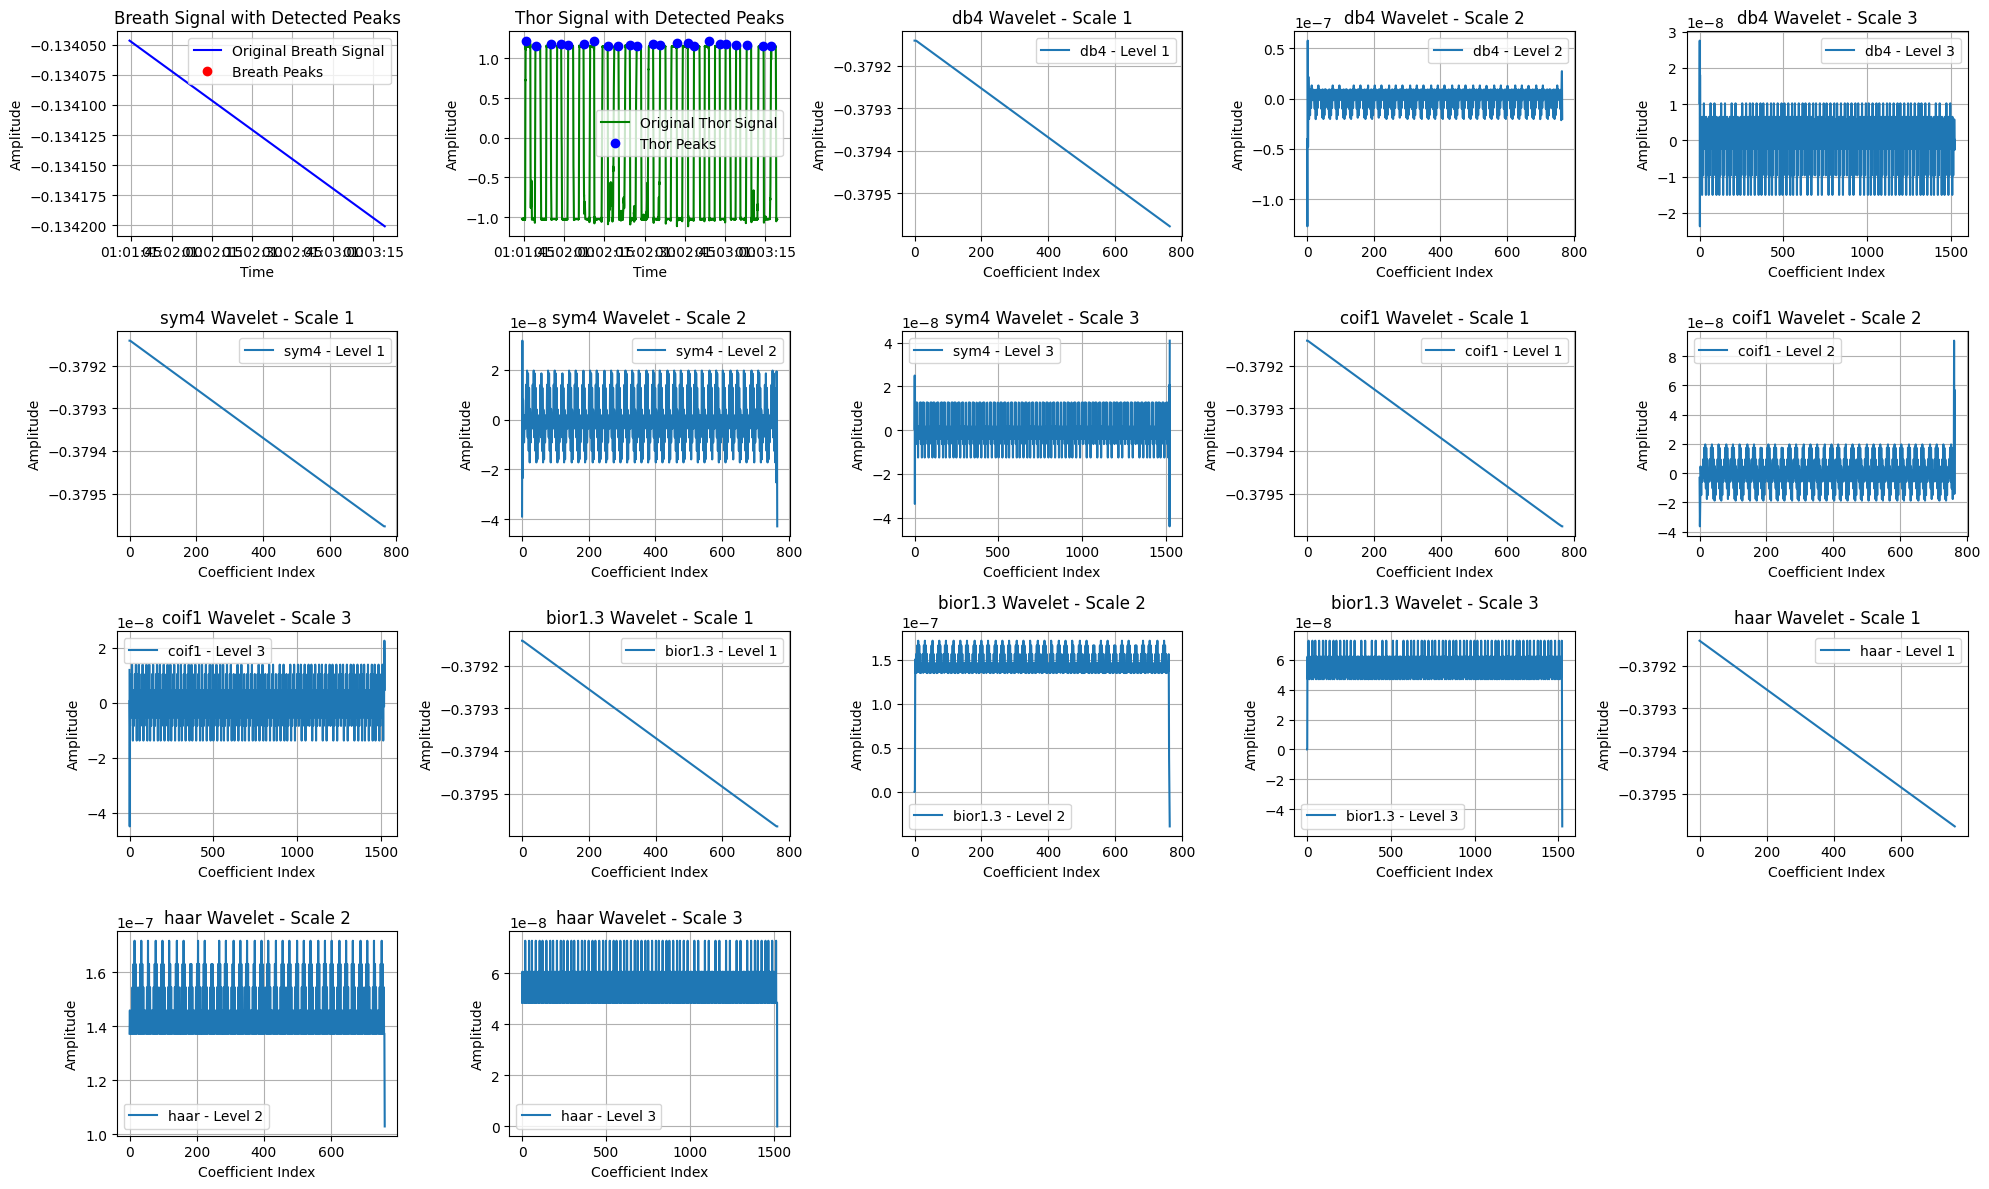

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks
from datetime import datetime

# Sample datetime range and dataframe filtering (assuming merged_df exists)
index = 100  # Define the index to use for setting the data point
start_datetime = obstructive_apnea_events.iloc[index]['Start'] - pd.Timedelta(seconds=30)  # Use the start time from obstructive_apnea_events with 10 sec padding
end_datetime = obstructive_apnea_events.iloc[index]['End'] + pd.Timedelta(seconds=30)  # Use the end time from obstructive_apnea_events with 10 sec padding

# Find subset of merged_df with index between start_datetime and end_datetime
obstructive_apnea_df = merged_df[(merged_df.index >= start_datetime) & (merged_df.index <= end_datetime)]

# Identify peaks for 'breath' and 'Thor' signals
breath_peaks, properties1 = find_peaks(obstructive_apnea_df['breath'], prominence=0.3, distance=128, height=0.9, width=50)
thor_peaks, properties2 = find_peaks(obstructive_apnea_df['Thor'], prominence=0.3, distance=128, height=0.9, width=50)

# Print the peak widths
print("Breath Peak Widths:", properties1['widths'])
print("Thor Peak Widths:", properties2['widths'])

# Define a function to compute wavelet coefficients for a signal
def process_with_wavelet(signal, wavelet_name, levels):
    coeffs = pywt.wavedec(signal, wavelet_name, level=levels)
    return coeffs

# Wavelets and levels
wavelets = ['db4', 'sym4', 'coif1', 'bior1.3', 'haar']
levels = 3

# Total number of subplots
n_wavelets = len(wavelets)
total_plots = n_wavelets * levels + 2  # 2 for the original signals
n_cols = n_wavelets
n_rows = int(np.ceil(total_plots / n_cols))

# Plot the signals and wavelet coefficients
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

# Plot original 'breath' signal
axes[0].plot(obstructive_apnea_df['breath'], label='Original Breath Signal', color='b')
axes[0].plot(obstructive_apnea_df.index[breath_peaks], obstructive_apnea_df['breath'].iloc[breath_peaks], 'ro', label='Breath Peaks')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Breath Signal with Detected Peaks')
axes[0].legend()
axes[0].grid(True)

# Plot original 'Thor' signal
axes[1].plot(obstructive_apnea_df['Thor'], label='Original Thor Signal', color='g')
axes[1].plot(obstructive_apnea_df.index[thor_peaks], obstructive_apnea_df['Thor'].iloc[thor_peaks], 'bo', label='Thor Peaks')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Thor Signal with Detected Peaks')
axes[1].legend()
axes[1].grid(True)

# Plot wavelet coefficients
plot_idx = 2  # Start after original signals
for wavelet_name in wavelets:
    coeffs = process_with_wavelet(obstructive_apnea_df['breath'], wavelet_name, levels)
    
    for j, coeff in enumerate(coeffs[:levels], 1):  # Plot up to the defined levels
        axes[plot_idx].plot(coeff, label=f'{wavelet_name} - Level {j}')
        axes[plot_idx].set_xlabel('Coefficient Index')
        axes[plot_idx].set_ylabel('Amplitude')
        axes[plot_idx].set_title(f'{wavelet_name} Wavelet - Scale {j}')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        plot_idx += 1

# Hide unused subplots
for ax in axes[plot_idx:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Old feature functions

In [63]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, find_peaks, hilbert, butter, filtfilt
from datetime import timedelta
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def is_valid_data(values, min_length=2, min_std=1e-8):
    return len(values) >= min_length and np.std(values) >= min_std

def calculate_mean(values):
    return np.mean(values) if len(values) > 0 else np.nan

def calculate_std(values):
    return np.std(values) if len(values) > 0 else np.nan

def calculate_min(values):
    return np.min(values) if len(values) > 0 else np.nan

def calculate_max(values):
    return np.max(values) if len(values) > 0 else np.nan

def calculate_median(values):
    return np.median(values) if len(values) > 0 else np.nan

def calculate_skewness(values):
    if not is_valid_data(values, min_length=3):
        return np.nan
    return skew(values)

def calculate_kurtosis(values):
    if not is_valid_data(values, min_length=4):
        return np.nan
    return kurtosis(values)

def calculate_zero_crossing_rate(values):
    return ((values[:-1] * values[1:]) < 0).sum() / len(values) if len(values) > 1 else np.nan

def calculate_threshold_zero_crossing_rate(values, threshold_fraction=0.1):
    if len(values) <= 1:
        return np.nan
    max_amplitude = np.max(np.abs(values))
    threshold = max_amplitude * threshold_fraction
    crossing_count = ((values[:-1] < -threshold) & (values[1:] >= -threshold)) | \
                     ((values[:-1] > threshold) & (values[1:] <= threshold))
    return np.sum(crossing_count) / len(values)

def calculate_autocorrelation(values):
    values = np.array(values)
    if len(values) < 2:
        return np.nan
    autocorr = np.corrcoef(values[:-1], values[1:])[0, 1]
    return autocorr if not np.isnan(autocorr) else np.nan

def calculate_peak_to_peak(values):
    values = np.array(values)
    return np.ptp(values) if len(values) > 0 else np.nan

def calculate_variance_of_amplitude(values):
    if not is_valid_data(values, min_length=2):
        return np.nan
    return np.var(values)

def calculate_slope_of_amplitude_changes(values):
    diff_values = np.diff(values)
    return np.mean(diff_values) if len(diff_values) > 0 else np.nan

def calculate_number_of_peaks(values):
    peaks, _ = find_peaks(values)
    return 10*64*len(peaks) / (len(values) - 1)

def calculate_peak_prominence(values):
    peaks, properties = find_peaks(values, prominence=1)
    return np.mean(properties['prominences']) if len(peaks) > 0 else np.nan

def calculate_peak_width(values):
    peaks, properties = find_peaks(values, prominence=1)
    return np.mean(properties['widths']) if 'widths' in properties and len(peaks) > 0 else np.nan

def calculate_power_spectral_density(values, sampling_rate=64.0):
    if len(values) < 1:
        return np.nan
    nperseg = min(256, len(values))
    if nperseg < 1:
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg)
    return np.sum(Pxx)

def calculate_shannon_entropy(values):
    hist, _ = np.histogram(values, bins=30, density=True)
    hist = hist[hist > 0]
    hist_sum = hist.sum()
    if hist_sum == 0:
        return np.nan
    return -np.sum(hist * np.log(hist)) / hist_sum

def calculate_line_length(values):
    return 100*np.sum(np.abs(np.diff(values))) / (len(values) - 1) if len(values) > 1 else np.nan

def calculate_rms(values):
    return np.sqrt(np.mean(np.square(values))) if len(values) > 0 else np.nan

def calculate_iqr(values):
    if len(values) > 0:
        return np.percentile(values, 75) - np.percentile(values, 25)
    return np.nan

def calculate_dominant_frequency(values, sampling_rate=64.0):
    if len(values) == 0:
        return np.nan
    try:
        f, Pxx = welch(values, fs=sampling_rate)
        if len(Pxx) == 0:
            return np.nan
        dominant_freq = f[np.argmax(Pxx)]
        return dominant_freq
    except Exception as e:
        # Log the exception if needed
        return np.nan

def calculate_wavelet_coefficients(values, wavelet='db4', level=5):
    if len(values) == 0:
        return np.nan
    try:
        coeffs = pywt.wavedec(values, wavelet, level=level)
        # Example: Return the mean of the approximation coefficients at the highest level
        return np.mean(coeffs[0]) if len(coeffs[0]) > 0 else np.nan
    except Exception as e:
        # Log the exception if needed
        return np.nan

def calculate_amplitude_envelope(values):
    if len(values) == 0:
        return np.nan
    analytic_signal = hilbert(values)
    amplitude_envelope = np.abs(analytic_signal)
    return calculate_mean(amplitude_envelope)

FEATURE_FUNCTIONS = {
    'Mean': calculate_mean,
    'Std': calculate_std,
    'Min': calculate_min,
    'Max': calculate_max,
    'Median': calculate_median,
    'Skewness': calculate_skewness,
    'Kurtosis': calculate_kurtosis,
    'ZeroCrossingRate': calculate_zero_crossing_rate,
    'ThresholdZCR': calculate_threshold_zero_crossing_rate,
    'Autocorrelation': calculate_autocorrelation,
    'PeakToPeak': calculate_peak_to_peak,
    'Variance': calculate_variance_of_amplitude,
    'Slope': calculate_slope_of_amplitude_changes,
    'NumPeaks': calculate_number_of_peaks,
    'PeakProminence': calculate_peak_prominence,
    'PeakWidth': calculate_peak_width,
    'PowerSpectralDensity': calculate_power_spectral_density,
    'ShannonEntropy': calculate_shannon_entropy,
    'LineLength': calculate_line_length,
    'RMS': calculate_rms,
    'IQR': calculate_iqr,
    'DominantFrequency': calculate_dominant_frequency,
    'WaveletCoeff': calculate_wavelet_coefficients,
    'AmplitudeEnvelope': calculate_amplitude_envelope
    # Add more features as needed
}

def process_single_event(event_row, df_subset, signal_list, sampling_rate, padding_seconds):
    start_time = event_row['Start']
    end_time = event_row['End']
    padded_start_time = start_time - timedelta(seconds=padding_seconds)
    padded_end_time = end_time + timedelta(seconds=padding_seconds)

    relevant_data = df_subset[(df_subset.index >= padded_start_time) & (df_subset.index <= padded_end_time)]
    exact_data = df_subset[(df_subset.index >= start_time) & (df_subset.index <= end_time)]
    head_data = df_subset[(df_subset.index >= padded_start_time) & (df_subset.index < start_time)]
    tail_data = df_subset[(df_subset.index > end_time) & (df_subset.index <= padded_end_time)]
    head_tail_data = pd.concat([head_data, tail_data])

    occurrence_entry = {
        'Start': start_time,
        'End': end_time,
        'Padded_Start': padded_start_time,
        'Padded_End': padded_end_time,
        'Time': relevant_data.index
    }

    for signal in signal_list:
        occurrence_entry[signal] = relevant_data[signal].values
        occurrence_entry[f'Exact_{signal}'] = exact_data[signal].values
        occurrence_entry[f'Head_Tail_{signal}'] = head_tail_data[signal].values

    stats_entry = {}
    for signal in signal_list:
        exact_values = occurrence_entry.get(f'Exact_{signal}', [])
        head_tail_values = occurrence_entry.get(f'Head_Tail_{signal}', [])

        stats_entry[signal] = {
            'Exact': {feature: func(exact_values) for feature, func in FEATURE_FUNCTIONS.items()},
            'Head_Tail': {feature: func(head_tail_values) for feature, func in FEATURE_FUNCTIONS.items()}
        }

    return occurrence_entry, stats_entry

def prepare_structured_data_parallel(merged_df, events_df, signal_list, sampling_rate=1.0, padding_seconds=30, n_jobs=-1):
    structured_data = {}
    df_subset = merged_df[signal_list]

    for event_type in events_df['Name'].unique():
        event_occurrences = events_df[events_df['Name'] == event_type]

        results = Parallel(n_jobs=n_jobs)(
            delayed(process_single_event)(
                event_row, df_subset, signal_list, sampling_rate, padding_seconds
            ) for _, event_row in event_occurrences.iterrows()
        )

        occurrences_list, stats_list = zip(*results) if results else ([], [])

        structured_data[event_type] = {
            'Occurrences': list(occurrences_list),
            'Stats': list(stats_list)
        }

    return structured_data

def analyze_and_plot_event_data(structured_data, event_type, signal_list, max_plots=5):
    if event_type not in structured_data:
        print(f"Event type '{event_type}' not found in structured_data.")
        return

    event_data = structured_data[event_type]['Occurrences']
    stats = structured_data[event_type]['Stats']

    for i, (occurrence, stat_entry) in enumerate(zip(event_data, stats)):
        if i >= max_plots:
            print(f"Reached maximum number of plots ({max_plots}).")
            break

        start_time = occurrence['Start']
        end_time = occurrence['End']
        signals = signal_list
        num_signals = len(signals)
        fig, axes = plt.subplots(num_signals, 2, figsize=(18, 5 * num_signals))
        if num_signals == 1:
            axes = np.array([axes])  # Ensure axes is 2D

        for j, signal in enumerate(signals):
            ax_signal, ax_box = axes[j]
            signal_data = occurrence.get(signal, [])
            time_data = occurrence['Time']
            exact_values = occurrence.get(f'Exact_{signal}', [])
            head_tail_values = occurrence.get(f'Head_Tail_{signal}', [])

            if len(time_data) != len(signal_data):
                continue

            # Plot Signal
            ax_signal.plot(time_data, signal_data, label=signal)
            ax_signal.axvline(x=start_time, color='r', linestyle='--', linewidth=2, label='Start')
            ax_signal.axvline(x=end_time, color='r', linestyle='--', linewidth=2, label='End')
            ax_signal.set_title(f'{event_type} - {signal} (# {i + 1})')
            ax_signal.set_xlabel('Time')
            ax_signal.set_ylabel(f'{signal} Value')
            ax_signal.legend()

            # Feature Stats
            exact_stats = stat_entry[signal]['Exact']
            exact_textstr = '\n'.join([f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}"
                                       for k, v in exact_stats.items()])
            exact_props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
            ax_signal.text(0.05, 0.95, exact_textstr, transform=ax_signal.transAxes, fontsize=9,
                           verticalalignment='top', bbox=exact_props)

            head_tail_stats = stat_entry[signal]['Head_Tail']
            head_tail_textstr = '\n'.join([f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}"
                                          for k, v in head_tail_stats.items()])
            head_tail_props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
            ax_signal.text(0.95, 0.95, head_tail_textstr, transform=ax_signal.transAxes, fontsize=9,
                           verticalalignment='top', horizontalalignment='right', bbox=head_tail_props)

            # Box Plot
            if len(exact_values) > 0 and len(head_tail_values) > 0:
                ax_box.boxplot([exact_values, head_tail_values], labels=['Exact', 'Head_Tail'])
                ax_box.set_title(f'{event_type} - {signal} Box Plot (# {i + 1})')
                ax_box.set_ylabel(f'{signal} Value')
            else:
                ax_box.text(0.5, 0.5, 'Not enough data for box plot',
                            horizontalalignment='center', verticalalignment='center')
                ax_box.set_title(f'{event_type} - {signal} Box Plot (# {i + 1})')
                ax_box.set_ylabel(f'{signal} Value')

        plt.tight_layout()
        plt.show()


In [ ]:
# Example usage
signal_list = ['breath', 'Thor', 'Nasal Pressure', 'SpO2']
structured_data = prepare_structured_data_parallel(merged_df, xml_processor.events, signal_list, sampling_rate=64, padding_seconds=30, n_jobs=-1)

In [ ]:
# Example usage
plot_list = ['breath', 'Thor']

analyze_and_plot_event_data(
    structured_data=structured_data,
    event_type='Mixed Apnea',
    signal_list=plot_list,
    max_plots=5
)

#### Current feature functions

In [253]:
# Current
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, find_peaks, hilbert, butter, filtfilt
from datetime import timedelta
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def is_valid_data(values, min_length=2, min_std=1e-8):
    return len(values) >= min_length and np.std(values) >= min_std

def calculate_mean(values):
    return np.mean(values) if len(values) > 0 else np.nan

def calculate_std(values):
    return np.std(values) if len(values) > 0 else np.nan

def calculate_windowed_std(values, window_size=128):
    if len(values) < window_size:
        return np.std(values) if len(values) > 1 else np.nan  # Use global std if insufficient data
    
    windowed_std = [np.std(values[i:i+window_size]) for i in range(len(values) - window_size + 1)]
    return np.std(windowed_std)

def calculate_windowed_entropy(values, window_size=128):
    if len(values) < window_size:
        if len(values) > 1: # Use global std if insufficient data
            histogram, _ = np.histogram(np.std(values), bins='auto', density=True) 
            return entropy(histogram)
    else:
        windowed_std = [
            np.std(values[i:i+window_size])
            for i in range(len(values) - window_size + 1)
        ]
        histogram, _ = np.histogram(windowed_std, bins='auto', density=True)
        return entropy(histogram)

def calculate_min(values):
    return np.min(values) if len(values) > 0 else np.nan

def calculate_max(values):
    return np.max(values) if len(values) > 0 else np.nan

def calculate_median(values):
    return np.median(values) if len(values) > 0 else np.nan

def calculate_skewness(values):
    if not is_valid_data(values, min_length=3):
        return np.nan
    return skew(values)

def calculate_kurtosis(values):
    if not is_valid_data(values, min_length=4):
        return np.nan
    return kurtosis(values)

def calculate_rms(values):
    return np.sqrt(np.mean(np.square(values))) if len(values) > 0 else np.nan

def calculate_rms_filtered(values, fs = 64, freq_band = (0.1, 0.5)):
    """
    Calculate the RMS of a signal after filtering for a specific frequency band.

    Parameters:
    - values (array-like): Input signal values.
    - fs (float): Sampling frequency of the signal.
    - freq_band (tuple): Frequency band for filtering as (low_freq, high_freq).

    Returns:
    - float: RMS value of the filtered signal, or NaN if the input is invalid.
    """
    padlen = 27
    if len(values) == 0 or len(values) <= padlen or fs <= 0 or not (isinstance(freq_band, tuple) and len(freq_band) == 2):
        return np.nan

    # Design a bandpass filter
    low, high = freq_band
    nyquist = 0.5 * fs
    low = low / nyquist
    high = high / nyquist

    # Check frequency band validity
    if low <= 0 or high >= 1 or low >= high:
        return np.nan

    # Butterworth filter design
    b, a = butter(N=4, Wn=[low, high], btype='band')

    # Apply the filter
    filtered_values = filtfilt(b, a, values)

    # Calculate RMS of the filtered signal
    rms_value = np.sqrt(np.mean(np.square(filtered_values)))
    return rms_value

def calculate_iqr(values):
    if len(values) > 0:
        return np.percentile(values, 75) - np.percentile(values, 25)
    return np.nan

def calculate_line_length(values):
    return 10 * 64 * np.sum(np.abs(np.diff(values))) / (len(values) - 1) if len(values) > 1 else np.nan

def calculate_variance_of_amplitude(values):
    if not is_valid_data(values, min_length=2):
        return np.nan
    return np.var(values)

def calculate_slope_of_amplitude_changes(values):
    diff_values = np.diff(values)
    return np.mean(diff_values) if len(diff_values) > 0 else np.nan

def calculate_amplitude_envelope(values):
    if len(values) == 0:
        return np.nan
    analytic_signal = hilbert(values)
    amplitude_envelope = np.abs(analytic_signal)
    return np.mean(amplitude_envelope)

def calculate_zero_crossing_rate(values):
    return 64 * 10 * ((values[:-1] * values[1:]) < 0).sum() / len(values) if len(values) > 1 else np.nan

def calculate_threshold_zero_crossing_rate(values, threshold_fraction=0.1):
    if len(values) <= 1:
        return np.nan
    max_amplitude = np.max(np.abs(values))
    threshold = max_amplitude * threshold_fraction
    crossing_count = ((values[:-1] < -threshold) & (values[1:] >= -threshold)) | \
                     ((values[:-1] > threshold) & (values[1:] <= threshold))
    return 64 * 10 * np.sum(crossing_count) / len(values)

def calculate_threshold_zero_crossing_rate_adaptive(values, window_size=100, threshold_fraction=0.1):
    if len(values) <= 1 or len(values) < window_size:
        return np.nan
    zcr = []
    for i in range(0, len(values) - window_size + 1, window_size):
        window = values[i:i+window_size]
        threshold = np.max(np.abs(window)) * threshold_fraction
        crossings = ((window[:-1] < -threshold) & (window[1:] >= -threshold)) | \
                    ((window[:-1] > threshold) & (window[1:] <= threshold))
        zcr.append(np.sum(crossings) / window_size)
    return np.mean(zcr)

def calculate_autocorrelation(values):
    values = np.array(values)
    if len(values) < 2 or np.std(values) < 1e-8:
        return np.nan
    autocorr = np.corrcoef(values[:-1], values[1:])[0, 1]
    return autocorr if not np.isnan(autocorr) else np.nan

def calculate_autocorrelation_multi_lag(values, max_lag=320):
    if len(values) <= max_lag:
        return np.nan
    autocorrs = [np.corrcoef(values[:-lag], values[lag:])[0, 1] for lag in range(192, max_lag+1)]
    autocorrs = [ac for ac in autocorrs if not np.isnan(ac)]
    return np.mean(autocorrs) if autocorrs else np.nan

# def find_pos_neg_peaks(values, prominence=0.3, distance=128, height=0.8, width=50):
# def find_pos_neg_peaks(values, prominence=0.1, distance=64, height=0.3, width=50):
def find_pos_neg_peaks(values, prominence=0, distance=1, height=0, width=0):
    peaks_pos, properties_pos = find_peaks(values, prominence=prominence, distance=distance, height=height, width=width)
    peaks_neg, properties_neg = find_peaks(-values, prominence=prominence, distance=distance, height=height, width=width)
    peaks = np.concatenate((peaks_pos, peaks_neg), axis=0)
    properties = {**properties_pos, **properties_neg}
    return peaks, properties

def calculate_peak_to_peak(values):
    values = np.array(values)
    return np.ptp(values) if len(values) > 0 else np.nan

def calculate_number_of_peaks(values):
    # Find peaks with specified prominence and minimum distance between peaks
    peaks, properties = find_pos_neg_peaks(values)

    # Calculate the number of peaks normalized by the signal length
    return 10 * 64 * len(peaks) / (len(values) - 1)

def calculate_peak_prominence(values):
    # peaks, properties = find_peaks(values, prominence=1)
    peaks, properties = find_pos_neg_peaks(values)

    return np.mean(properties['prominences']) if len(peaks) > 0 else np.nan

def calculate_peak_width(values):
    peaks, properties = find_pos_neg_peaks(values)

    return np.mean(properties['widths']) if 'widths' in properties and len(peaks) > 0 else np.nan

def calculate_peak_to_peak_variability(values):
    peaks, properties = find_pos_neg_peaks(values)
    
    # Calculate distances between consecutive peaks
    if len(peaks) < 2:
        return np.nan  # Not enough peaks to calculate variability
    
    peak_to_peak_distances = np.diff(peaks)
    
    # Calculate variability (standard deviation of distances)
    return np.std(peak_to_peak_distances)

def calculate_power_spectral_density(values, sampling_rate=64.0, window='hamming'):
    if len(values) < 1:
        return np.nan
    nperseg = min(256, len(values))
    if nperseg < 1:
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg, window=window)
    return np.sum(Pxx)

def calculate_band_power(values, sampling_rate=64.0, bands=[(0.1, 0.5), (0.5, 1)], window='hamming'):
    if len(values) < 1:
        # return [np.nan] * len(bands)
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=min(256, len(values)), window=window)
    band_powers = []
    for (low, high) in bands:
        idx_band = np.logical_and(f >= low, f <= high)
        band_power = np.trapz(Pxx[idx_band], f[idx_band])
        band_powers.append(band_power)
    return band_powers[0]

def calculate_spectral_entropy(values, sampling_rate=64.0, window='hamming'):
    if len(values) < 1:
        return np.nan
    nperseg = min(256, len(values))
    if nperseg < 1:
        return np.nan
    f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg, window=window)
    
    # Total power
    total_power = np.sum(Pxx)
    # Spectral Entropy
    normalized_psd = Pxx / total_power if total_power > 0 else np.zeros_like(Pxx)
    spectral_entropy = entropy(normalized_psd, base=2)
    return spectral_entropy

def calculate_shannon_entropy(values):
    if len(values) == 0:
        return np.nan
    hist, _ = np.histogram(values, bins='fd', density=True)  # 'fd' is the Freedman-Diaconis rule
    hist = hist[hist > 0]
    hist_sum = hist.sum()
    if hist_sum == 0:
        return np.nan
    return -np.sum(hist * np.log(hist)) / hist_sum

def calculate_dominant_frequency(values, sampling_rate=64.0, window='hamming'):
    if len(values) == 0:
        return np.nan
    
    nperseg = min(256, len(values))
    try:
        f, Pxx = welch(values, fs=sampling_rate, nperseg=nperseg, window=window)
        if len(Pxx) == 0:
            return np.nan
        dominant_freq = f[np.argmax(Pxx)]
        return dominant_freq
    except Exception as e:
        # Log the exception if needed
        return np.nan

def calculate_wavelet_coefficients(values, wavelet='harr', level=3):
    if len(values) == 0:
        return np.nan
    # Dynamic level adjustment
    max_level = int(np.floor(np.log2(len(values))))
    level = min(max_level, level)
    if level < 1:
        return np.nan  # Insufficient length for even one level
    try:
        coeffs = pywt.wavedec(values, wavelet, level=level)
        # Example: Return the mean of the approximation coefficients at the highest level
        return np.mean(coeffs[0]) if len(coeffs[0]) > 0 else np.nan
    except Exception as e:
        # Log the exception if needed
        return np.nan
    
def calculate_wavelet_sum(values, wavelet='harr', level=5):
    if len(values) == 0:
        return np.nan
    # Dynamic level adjustment
    max_level = int(np.floor(np.log2(len(values))))
    level = min(max_level, level)
    if level < 1:
        return np.nan  # Insufficient length for even one level
    try:
        coeffs = pywt.wavedec(values, wavelet, level=level)
        # Example: Return the mean of the approximation coefficients at the highest level
        return sum(np.sum(np.abs(c)) / len(c) for c in coeffs if len(c) > 0)
    except Exception as e:
        # Log the exception if needed
        return np.nan


FEATURE_FUNCTIONS = {
    'Mean': calculate_mean,
    'Std': calculate_std,
    'WindowStd': calculate_windowed_std,
    'WindowEntropy': calculate_windowed_entropy,
    'Min': calculate_min,
    'Max': calculate_max,
    'Median': calculate_median,
    'Skewness': calculate_skewness,
    'Kurtosis': calculate_kurtosis,
    'RMS': calculate_rms,
    'RMS_filtered': calculate_rms_filtered,
    'IQR': calculate_iqr,
    'LineLength': calculate_line_length,
    'Variance': calculate_variance_of_amplitude,
    'Slope': calculate_slope_of_amplitude_changes,
    'ZeroCrossingRate': calculate_zero_crossing_rate,
    'ThresholdZCR': calculate_threshold_zero_crossing_rate,
    'Autocorrelation': calculate_autocorrelation,
    'AutocorrelationLagged': calculate_autocorrelation_multi_lag,
    'PeakToPeak': calculate_peak_to_peak,
    'NumPeaks': calculate_number_of_peaks,
    'PeakProminence': calculate_peak_prominence,
    'PeakWidth': calculate_peak_width,
    'PeakVariance': calculate_peak_to_peak_variability,
    'PowerSpectralDensity': calculate_power_spectral_density,
    'BandPower': calculate_band_power,
    'SpectralEntropy': calculate_spectral_entropy,
    'ShannonEntropy': calculate_shannon_entropy,
    'DominantFrequency': calculate_dominant_frequency,
    'WaveletCoeff': calculate_wavelet_coefficients,
    'WaveletSum': calculate_wavelet_sum,
    'AmplitudeEnvelope': calculate_amplitude_envelope
    # Add more features as needed
}

def process_single_event(event_row, df_subset, signal_list, sampling_rate, padding_seconds = 30, extra_padding = 5):
    start_time = event_row['Start'] - timedelta(seconds=extra_padding)
    end_time = event_row['End'] + timedelta(seconds=extra_padding)
    padded_start_time = start_time - timedelta(seconds=padding_seconds)
    padded_end_time = end_time + timedelta(seconds=padding_seconds)

    relevant_data = df_subset[(df_subset.index >= padded_start_time) & (df_subset.index <= padded_end_time)]
    exact_data = df_subset[(df_subset.index >= start_time) & (df_subset.index <= end_time)]
    head_data = df_subset[(df_subset.index >= padded_start_time) & (df_subset.index < start_time)]
    tail_data = df_subset[(df_subset.index > end_time) & (df_subset.index <= padded_end_time)]
    head_tail_data = pd.concat([head_data, tail_data])

    occurrence_entry = {
        'Start': start_time,
        'End': end_time,
        'Padded_Start': padded_start_time,
        'Padded_End': padded_end_time,
        'Time': relevant_data.index
    }

    for signal in signal_list:
        occurrence_entry[signal] = relevant_data[signal].values
        occurrence_entry[f'Exact_{signal}'] = exact_data[signal].values
        occurrence_entry[f'Head_Tail_{signal}'] = head_tail_data[signal].values

    stats_entry = {}
    for signal in signal_list:
        exact_values = occurrence_entry.get(f'Exact_{signal}', [])
        head_tail_values = occurrence_entry.get(f'Head_Tail_{signal}', [])

        stats_entry[signal] = {
            'Exact': {feature: func(exact_values) for feature, func in FEATURE_FUNCTIONS.items()},
            'Head_Tail': {feature: func(head_tail_values) for feature, func in FEATURE_FUNCTIONS.items()}
        }

    return occurrence_entry, stats_entry

def prepare_structured_data_parallel(merged_df, events_df, signal_list, sampling_rate=1.0, padding_seconds=30, extra_padding = 5, n_jobs=-1):
    structured_data = {}
    df_subset = merged_df[signal_list]

    for event_type in events_df['Name'].unique():
        event_occurrences = events_df[events_df['Name'] == event_type]

        results = Parallel(n_jobs=n_jobs)(
            delayed(process_single_event)(
                event_row, df_subset, signal_list, sampling_rate, padding_seconds, extra_padding
            ) for _, event_row in event_occurrences.iterrows()
        )

        occurrences_list, stats_list = zip(*results) if results else ([], [])

        structured_data[event_type] = {
            'Occurrences': list(occurrences_list),
            'Stats': list(stats_list)
        }

    return structured_data

def analyze_and_plot_event_data(structured_data, event_type, signal_list, max_plots=5):
    if event_type not in structured_data:
        print(f"Event type '{event_type}' not found in structured_data.")
        return

    event_data = structured_data[event_type]['Occurrences']
    stats = structured_data[event_type]['Stats']

    for i, (occurrence, stat_entry) in enumerate(zip(event_data, stats)):
        if i >= max_plots:
            print(f"Reached maximum number of plots ({max_plots}).")
            break

        start_time = occurrence['Start']
        end_time = occurrence['End']
        signals = signal_list
        num_signals = len(signals)
        fig, axes = plt.subplots(num_signals, 2, figsize=(18, 5 * num_signals))
        if num_signals == 1:
            axes = np.array([axes])  # Ensure axes is 2D

        for j, signal in enumerate(signals):
            ax_signal, ax_box = axes[j]
            signal_data = occurrence.get(signal, [])
            time_data = occurrence['Time']
            exact_values = occurrence.get(f'Exact_{signal}', [])
            head_tail_values = occurrence.get(f'Head_Tail_{signal}', [])

            if len(time_data) != len(signal_data):
                continue

            # Plot Signal
            ax_signal.plot(time_data, signal_data, label=signal)
            ax_signal.axvline(x=start_time, color='r', linestyle='--', linewidth=2, label='Start')
            ax_signal.axvline(x=end_time, color='r', linestyle='--', linewidth=2, label='End')
            ax_signal.set_title(f'{event_type} - {signal} (# {i + 1})')
            ax_signal.set_xlabel('Time')
            ax_signal.set_ylabel(f'{signal} Value')
            ax_signal.legend()

            # Feature Stats
            exact_stats = stat_entry[signal]['Exact']
            exact_textstr = '\n'.join([f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}"
                                       for k, v in exact_stats.items()])
            exact_props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
            ax_signal.text(0.05, 0.95, exact_textstr, transform=ax_signal.transAxes, fontsize=9,
                           verticalalignment='top', bbox=exact_props)

            head_tail_stats = stat_entry[signal]['Head_Tail']
            head_tail_textstr = '\n'.join([f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}"
                                          for k, v in head_tail_stats.items()])
            head_tail_props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
            ax_signal.text(0.95, 0.95, head_tail_textstr, transform=ax_signal.transAxes, fontsize=9,
                           verticalalignment='top', horizontalalignment='right', bbox=head_tail_props)

            # Box Plot
            if len(exact_values) > 0 and len(head_tail_values) > 0:
                ax_box.boxplot([exact_values, head_tail_values], labels=['Exact', 'Head_Tail'])
                ax_box.set_title(f'{event_type} - {signal} Box Plot (# {i + 1})')
                ax_box.set_ylabel(f'{signal} Value')
            else:
                ax_box.text(0.5, 0.5, 'Not enough data for box plot',
                            horizontalalignment='center', verticalalignment='center')
                ax_box.set_title(f'{event_type} - {signal} Box Plot (# {i + 1})')
                ax_box.set_ylabel(f'{signal} Value')

        plt.tight_layout()
        plt.show()


In [ ]:
# Example usage
# signal_list = ['breath', 'ECG_Rate', 'RSP_Rate', 'ECG', 'Thor', 'Airflow', 'SpO2']
signal_list = ['breath', 'Thor', 'Nasal Pressure', 'SpO2']
# signal_list = ['breath', 'Thor']
structured_data = prepare_structured_data_parallel(merged_df, xml_processor.events, signal_list, sampling_rate=64, padding_seconds=300, extra_padding = 0, n_jobs=-1)

In [ ]:
plot_list = ['breath', 'Thor']

analyze_and_plot_event_data(
    structured_data=structured_data,
    event_type='Obstructive Apnea',
    signal_list=plot_list,
    max_plots=5
)

In [ ]:
plot_list = ['breath', 'Thor']

analyze_and_plot_event_data(
    structured_data=structured_data,
    event_type='Hypopnea',
    signal_list=plot_list,
    max_plots=5
)

In [257]:
# # Example usage
# signal_list = ['breath', 'ECG_Rate', 'RSP_Rate', 'ECG', 'Thor', 'Airflow', 'SpO2']
# structured_data = prepare_structured_data(merged_df, xml_processor.events, signal_list, padding_seconds=30)

# # Example usage
# analyze_and_plot_event_data(structured_data,'Central Apnea')

# analyze_and_plot_event_data(structured_data, 'Obstructive Apnea')

## One class classification

### Hypopnea

In [19]:
import pandas as pd
import numpy as np

def create_feature_dataframe(structured_data, event_type, signal_list):
    """
    Create a DataFrame from structured data for a specific event type.

    Each event occurrence will generate two rows:
    1. One for the 'Exact' segment with label True.
    2. One for the 'Head_Tail' segment with label False.

    Parameters:
    - structured_data (dict): The structured data containing feature statistics.
    - event_type (str): The event type to process (e.g., 'Central Apnea').
    - signal_list (list): List of signal names used in feature extraction.

    Returns:
    - features_df (pd.DataFrame): A DataFrame with features and labels.
    """

    # Check if the event_type exists in structured_data
    if event_type not in structured_data:
        raise ValueError(f"Event type '{event_type}' not found in structured_data.")

    # Initialize a list to collect all rows
    rows = []

    # Iterate over each stats_entry corresponding to the event_type
    for stats_entry in structured_data[event_type]['Stats']:
        # Initialize dictionaries for 'Exact' and 'Head_Tail'
        exact_row = {}
        head_tail_row = {}

        # Iterate through each signal in signal_list
        for signal in signal_list:
            # Prefix features with signal name for clarity
            for feature, value in stats_entry[signal]['Exact'].items():
                column_name = f"{signal}_{feature}"
                exact_row[column_name] = value

            for feature, value in stats_entry[signal]['Head_Tail'].items():
                column_name = f"{signal}_{feature}"
                head_tail_row[column_name] = value

        # Assign labels
        exact_row['Label'] = True
        head_tail_row['Label'] = False

        # Append the rows to the list
        rows.append(exact_row)
        rows.append(head_tail_row)

    # Create the DataFrame
    features_df = pd.DataFrame(rows)

    # Generate a list of all possible feature columns based on FEATURE_FUNCTIONS
    all_feature_columns = []
    for signal in signal_list:
        for feature in FEATURE_FUNCTIONS.keys():
            column_name = f"{signal}_{feature}"
            all_feature_columns.append(column_name)

    # Ensure all expected columns are present in the DataFrame
    for col in all_feature_columns:
        if col not in features_df.columns:
            features_df[col] = np.nan  # Assign NaN if the feature is missing

    # Reorder columns: Features first, then Label
    features_df = features_df[all_feature_columns + ['Label']]

    return features_df


In [20]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

Name
Arousal (ARO RES)        225
Obstructive Apnea        221
SpO2 desaturation        166
Limb Movement (Right)    102
Arousal (ARO SPONT)       98
Hypopnea                  77
PLM (Left)                75
Limb Movement (Left)      67
PLM (Right)               67
Arousal (ARO PLM)          3
Unsure                     1
Name: count, dtype: int64

In [21]:
# Define the signals you want to process
# signal_list = ['breath', 'Thor', 'Airflow', 'SpO2']
signal_list = ['breath', 'Thor']

# Specify the event type you want to analyze
event_type = 'Hypopnea'

# Create the feature DataFrame
features_df = create_feature_dataframe(structured_data, event_type, signal_list)

# Display the first few rows
print(features_df.head())


NameError: name 'structured_data' is not defined

##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == True].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == False].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [161]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [162]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


### Obstructive Apnea

In [345]:
import pandas as pd
import numpy as np

def create_feature_dataframe(structured_data, event_type, signal_list):
    """
    Create a DataFrame from structured data for a specific event type.

    Each event occurrence will generate two rows:
    1. One for the 'Exact' segment with label True.
    2. One for the 'Head_Tail' segment with label False.

    Parameters:
    - structured_data (dict): The structured data containing feature statistics.
    - event_type (str): The event type to process (e.g., 'Central Apnea').
    - signal_list (list): List of signal names used in feature extraction.

    Returns:
    - features_df (pd.DataFrame): A DataFrame with features and labels.
    """

    # Check if the event_type exists in structured_data
    if event_type not in structured_data:
        raise ValueError(f"Event type '{event_type}' not found in structured_data.")

    # Initialize a list to collect all rows
    rows = []

    # Iterate over each stats_entry corresponding to the event_type
    for stats_entry in structured_data[event_type]['Stats']:
        # Initialize dictionaries for 'Exact' and 'Head_Tail'
        exact_row = {}
        head_tail_row = {}

        # Iterate through each signal in signal_list
        for signal in signal_list:
            # Prefix features with signal name for clarity
            for feature, value in stats_entry[signal]['Exact'].items():
                column_name = f"{signal}_{feature}"
                exact_row[column_name] = value

            for feature, value in stats_entry[signal]['Head_Tail'].items():
                column_name = f"{signal}_{feature}"
                head_tail_row[column_name] = value

        # Assign labels
        exact_row['Label'] = True
        head_tail_row['Label'] = False

        # Append the rows to the list
        rows.append(exact_row)
        rows.append(head_tail_row)

    # Create the DataFrame
    features_df = pd.DataFrame(rows)

    # Generate a list of all possible feature columns based on FEATURE_FUNCTIONS
    all_feature_columns = []
    for signal in signal_list:
        for feature in FEATURE_FUNCTIONS.keys():
            column_name = f"{signal}_{feature}"
            all_feature_columns.append(column_name)

    # Ensure all expected columns are present in the DataFrame
    for col in all_feature_columns:
        if col not in features_df.columns:
            features_df[col] = np.nan  # Assign NaN if the feature is missing

    # Reorder columns: Features first, then Label
    features_df = features_df[all_feature_columns + ['Label']]

    return features_df


In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [261]:
import pandas as pd
import numpy as np

def create_feature_dataframe(structured_data, event_type, signal_list):
    """
    Create a DataFrame from structured data for a specific event type.

    Each event occurrence will generate two rows:
    1. One for the 'Exact' segment with label True.
    2. One for the 'Head_Tail' segment with label False.

    Parameters:
    - structured_data (dict): The structured data containing feature statistics.
    - event_type (str): The event type to process (e.g., 'Central Apnea').
    - signal_list (list): List of signal names used in feature extraction.

    Returns:
    - features_df (pd.DataFrame): A DataFrame with features and labels.
    """

    # Check if the event_type exists in structured_data
    if event_type not in structured_data:
        raise ValueError(f"Event type '{event_type}' not found in structured_data.")

    # Initialize a list to collect all rows
    rows = []

    # Iterate over each stats_entry corresponding to the event_type
    for stats_entry in structured_data[event_type]['Stats']:
        # Initialize dictionaries for 'Exact' and 'Head_Tail'
        exact_row = {}
        head_tail_row = {}

        # Iterate through each signal in signal_list
        for signal in signal_list:
            # Prefix features with signal name for clarity
            for feature, value in stats_entry[signal]['Exact'].items():
                column_name = f"{signal}_{feature}"
                exact_row[column_name] = value

            for feature, value in stats_entry[signal]['Head_Tail'].items():
                column_name = f"{signal}_{feature}"
                head_tail_row[column_name] = value

        # Assign labels
        exact_row['Label'] = True
        head_tail_row['Label'] = False

        # Append the rows to the list
        rows.append(exact_row)
        rows.append(head_tail_row)

    # Create the DataFrame
    features_df = pd.DataFrame(rows)

    # Generate a list of all possible feature columns based on FEATURE_FUNCTIONS
    all_feature_columns = []
    for signal in signal_list:
        for feature in FEATURE_FUNCTIONS.keys():
            column_name = f"{signal}_{feature}"
            all_feature_columns.append(column_name)

    # Ensure all expected columns are present in the DataFrame
    for col in all_feature_columns:
        if col not in features_df.columns:
            features_df[col] = np.nan  # Assign NaN if the feature is missing

    # Reorder columns: Features first, then Label
    features_df = features_df[all_feature_columns + ['Label']]

    return features_df


In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Define the signals you want to process
# signal_list = ['breath', 'Thor', 'Airflow', 'SpO2']
signal_list = ['breath', 'Thor', 'SpO2', 'Nasal Pressure']
# signal_list = ['breath', 'Thor']

# Specify the event type you want to analyze
event_type = 'Obstructive Apnea'

# Create the feature DataFrame
features_df = create_feature_dataframe(structured_data, event_type, signal_list)

# Display the first few rows
print(features_df.head())


##### Check for Missing Values

In [ ]:
features_df.shape

In [ ]:
# Print the DataFrame
# print(features_df.isnull().sum())
print(features_df.isnull().sum().to_string())

In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == True].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == False].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


##### Anomaly Points Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

print(f"Original data shape: {X.shape}")
print(f"PCA transformed data shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# Step 3: Split the data
X_pca_2d = X_pca[:, :2]

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_2d, y, test_size=0.25, random_state=42, stratify=y
)

# Step 4: Train multiple models

# SVM with RBF kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='f1')
grid_svm.fit(X_train, y_train)
svm_best = grid_svm.best_estimator_
y_pred_svm = svm_best.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1')
grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Neural Network
nn_model = MLPClassifier(random_state=42, max_iter=1000)
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}
grid_nn = GridSearchCV(nn_model, param_grid_nn, cv=5, scoring='f1')
grid_nn.fit(X_train, y_train)
nn_best = grid_nn.best_estimator_
y_pred_nn = nn_best.predict(X_test)

# Step 5: Evaluate models
print("\nSVM Model:")
print(f"Best parameters: {grid_svm.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("\nRandom Forest Model:")
print(f"Best parameters: {grid_rf.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nNeural Network Model:")
print(f"Best parameters: {grid_nn.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nn))



In [446]:
# Step 6: Visualize decision boundaries (for the first 2 PCs)
def plot_decision_boundary(model, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just use the first 2 PCs for visualization
    if X.shape[1] > 2:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], X.shape[1]-2))])
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                          edgecolor='k', s=50, alpha=0.7)
    
    plt.colorbar(scatter, label='Class')
    plt.title(title)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.tight_layout()
    plt.show()
    
def plot_decision_boundary_show_misclassified(model, X, y, title, annotate_points=False):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just use the first 2 PCs for visualization
    if X.shape[1] > 2:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], X.shape[1]-2))])
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Add a small random jitter to help visualize overlapping points
    jitter_amount = 0.08
    X_jittered = X.copy()
    if not annotate_points:
        X_jittered[:, 0] += np.random.uniform(-jitter_amount, jitter_amount, X.shape[0])
        X_jittered[:, 1] += np.random.uniform(-jitter_amount, jitter_amount, X.shape[0])
    
    # Get model predictions
    y_pred = model.predict(X)
    y = np.array(y)  # Ensure y is a numpy array
    
    # Create mask for correctly and incorrectly classified points
    correct_mask = (y_pred == y)
    incorrect_mask = ~correct_mask
    
    # Plot correctly classified points
    if np.any(correct_mask):
        scatter_correct = plt.scatter(X_jittered[correct_mask, 0], X_jittered[correct_mask, 1], 
                                     c=y[correct_mask], cmap='viridis', 
                                     edgecolor='k', s=70, alpha=0.8, label='Correct')
    
    # Plot misclassified points with red rings and larger size
    misclassified_points = []
    if np.any(incorrect_mask):
        scatter_incorrect = plt.scatter(X_jittered[incorrect_mask, 0], X_jittered[incorrect_mask, 1], 
                                       c=y[incorrect_mask], cmap='viridis', 
                                       edgecolor='red', s=100, linewidth=2, alpha=1.0, 
                                       marker='o', label='Misclassified')
        
        # Store information about misclassified points
        misclass_indices = np.where(incorrect_mask)[0]
        for i in misclass_indices:
            misclassified_points.append({
                'index': i,
                'true_class': y[i],
                'pred_class': y_pred[i],
                'coordinates': (X[i, 0], X[i, 1])
            })
    
    # Annotate points with their indices if requested
    if annotate_points:
        for i in range(len(X)):
            ax.annotate(str(i), (X[i, 0] + 0.05, X[i, 1] + 0.05), 
                        fontsize=8, 
                        color='red' if incorrect_mask[i] else 'black')
    
    # Add count of points by class
    unique_classes = np.unique(y)
    class_counts = {cls: np.sum(y == cls) for cls in unique_classes}
    class_info = "Point counts: " + ", ".join([f"Class {cls}: {count}" for cls, count in class_counts.items()])
    ax.text(0.02, 0.02, class_info, transform=ax.transAxes, fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.7))
    
    # Misclassification info
    misclassified = np.sum(incorrect_mask)
    acc = 1 - misclassified/len(y)
    ax.text(0.02, 0.06, f"Accuracy: {acc:.4f} ({misclassified} misclassified out of {len(y)} points)", 
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # Misclassified point details
    if misclassified > 0:
        misclass_indices = np.where(incorrect_mask)[0]
        misclass_text = "Misclassified indices: " + ", ".join([f"{i}" for i in misclass_indices])
        ax.text(0.02, 0.10, misclass_text, transform=ax.transAxes, fontsize=9, 
                bbox=dict(facecolor='mistyrose', alpha=0.7))
        
        # Add a table showing details of misclassified points
        misclass_data = []
        for i in misclass_indices:
            misclass_data.append([i, y[i], y_pred[i], f"({X[i, 0]:.2f}, {X[i, 1]:.2f})"])
        
        # Only show table if there aren't too many misclassified points
        if len(misclass_indices) <= 10:
            table_ax = fig.add_axes([0.65, 0.02, 0.3, 0.2])
            table_ax.axis('off')
            table = table_ax.table(
                cellText=misclass_data,
                colLabels=['Index', 'True', 'Pred', 'Coordinates'],
                loc='center',
                cellLoc='center'
            )
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
    
    # Legend for point types
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                   markersize=10, label='Correct'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                   markeredgecolor='red', markersize=12, markeredgewidth=2, label='Misclassified')
    ]
    ax.legend(handles=handles, loc='upper right')
    
    # Add point count to title
    plt.suptitle(f"{title} - {len(X)} points", fontsize=16)
    
    # Only add colorbar if we have points to show
    if np.any(correct_mask):
        plt.colorbar(scatter_correct, label='Class')
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.tight_layout()
    
    return fig, ax, misclassified_points

In [ ]:
# For visualization purposes only, train models using just 2 PCs
# For visualization purposes, train models using first 3 PCs
X_vis = X_pca[:, :2]  # Use first 3 components for visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y, test_size=0.25, random_state=42, stratify=y
)

# Train simplified models for visualization
svm_vis = SVC(kernel='rbf', C=grid_svm.best_params_['C'], 
             gamma=grid_svm.best_params_['gamma'], random_state=42)
svm_vis.fit(X_train_vis, y_train_vis)

rf_vis = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'],
                              max_depth=grid_rf.best_params_['max_depth'],
                              min_samples_split=grid_rf.best_params_['min_samples_split'],
                              random_state=42)
rf_vis.fit(X_train_vis, y_train_vis)

nn_vis = MLPClassifier(hidden_layer_sizes=grid_nn.best_params_['hidden_layer_sizes'],
                     activation=grid_nn.best_params_['activation'],
                     alpha=grid_nn.best_params_['alpha'],
                     learning_rate=grid_nn.best_params_['learning_rate'],
                     max_iter=1000, random_state=42)
nn_vis.fit(X_train_vis, y_train_vis)

# Plot 3D decision boundaries with the models
plot_decision_boundary_show_misclassified(svm_vis, X_test_vis, y_test_vis, "SVM Decision Boundary (First 3 PCs)")
plot_decision_boundary_show_misclassified(rf_vis, X_test_vis, y_test_vis, "Random Forest Decision Boundary (First 3 PCs)")
plot_decision_boundary_show_misclassified(nn_vis, X_test_vis, y_test_vis, "Neural Network Decision Boundary (First 3 PCs)")


In [ ]:
# Step 1: Extract the misclassified point indices
misclassified_indices = [1, 7, 9, 11]

# Step 2: Look at their PCA values (all identical)
misclassified_pca = X_test_vis[misclassified_indices]
print("PCA values of misclassified points:")
print(misclassified_pca)

# Step 3: Find the corresponding indices in the original dataset
# Since you're using train_test_split with random_state=42, 
# these indices are from X_test_vis, which is a subset of X_vis
# We need to map back to the original dataset

# Assuming test_indices holds the original indices of test data
# If you don't have this, you can recreate the split:
from sklearn.model_selection import train_test_split


test_indices = y_test_vis.index
# Now get the original dataset indices
original_indices = test_indices[misclassified_indices]
print(f"Original dataset indices: {original_indices}")

# Step 4: Get the original features for these points
# Assuming 'X' is your original feature data before PCA
original_features = X.iloc[original_indices]
print("\nOriginal feature values for misclassified points:")
print(original_features)

# Step 5: Compare with correctly classified points of the same class
# Find some correctly classified points of class 'False'
correct_false_indices = [i for i, (pred, true) in enumerate(zip(svm_vis.predict(X_test_vis), y_test_vis)) 
                         if pred == true and true == False]
original_correct_indices = test_indices[correct_false_indices[:4]]  # First 4 correctly classified points
# print original_correct_indices
print("\nOriginal correct indices:")
print(original_correct_indices)

correct_features = X.iloc[original_correct_indices]

print("\nOriginal feature values for CORRECTLY classified points (class=False):")
print(correct_features)

# Step 6: Find feature differences - what makes misclassified points unique?
# Calculate mean values for each group
misclassified_mean = np.mean(original_features, axis=0)
correct_mean = np.mean(correct_features, axis=0)

# Find the features with the largest differences
feature_diff = misclassified_mean - correct_mean
feature_names = X.columns.tolist()  # Use the actual feature names from the original dataset
feature_importance = sorted(zip(feature_names, misclassified_mean, correct_mean, feature_diff), key=lambda x: abs(x[1]), reverse=True)

print("\nFeatures with largest differences (misclassified vs. correctly classified):")
for feature, mis_mean, act_mean, diff in feature_importance[:10]:  # Top 10 different features
    print(f"{feature:<30}: {mis_mean:.4f} {act_mean:.4f} {diff:.4f}")

Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Plot the first three principal components in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot with colors based on the labels
scatter = ax.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    X_pca[:, 2], 
    c=y, 
    cmap='viridis', 
    alpha=0.7,
    s=50  # Marker size
)

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - First Three Principal Components')

# Add a color bar to show the mapping from colors to labels
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Label')

# Improve perspective
ax.view_init(elev=30, azim=20)

plt.tight_layout()
plt.show()

Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [303]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [288]:
# # For visualization purposes only, train models using just 2 PCs
# X_vis = X_pca[:, :2]  # Use only first 2 components for visualization
# X_train, X_test, y_train, y_test = train_test_split(
#     X_vis, y, test_size=0.25, random_state=2, stratify=y
# )

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


### Limb Movement (Left)

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Define the signals you want to process
# signal_list = ['breath', 'Thor', 'Airflow', 'SpO2']
signal_list = ['breath', 'Thor']

# Specify the event type you want to analyze
event_type = 'Limb Movement (Left)'

# Create the feature DataFrame
features_df = create_feature_dataframe(structured_data, event_type, signal_list)

# Display the first few rows
print(features_df.head())


##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == True].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == False].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [137]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [138]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


## Multi-class classification

### OSA

In [75]:
import pandas as pd
import numpy as np

def create_feature_dataframe_multiple_events(structured_data, event_types, signal_list, feature_functions):
    """
    Create a DataFrame from structured data for multiple event types.

    For each event occurrence of each event type, this function generates two rows:
    1. One row for the 'Exact' segment of the event occurrence:
       - All features from FEATURE_FUNCTIONS are extracted and prefixed with the signal name.
       - One-hot encoding is applied to the labels: the column corresponding to the event type of this occurrence is 1,
         and all other event type columns are 0.
    2. One row for the 'Head_Tail' segment of the same occurrence:
       - All features are extracted similarly.
       - All event type columns are set to 0 since this segment doesn't represent the exact event occurrence.

    The resulting DataFrame will have:
    - Rows: Each event occurrence contributes two rows (Exact and Head_Tail).
    - Columns: All features (signal_feature) plus one column per event type for one-hot labels.

    Parameters:
    - structured_data (dict): The structured data containing feature statistics for multiple event types.
    - event_types (list): A list of event types to process (e.g., ['Central Apnea', 'Obstructive Apnea']).
    - signal_list (list): List of signal names used in feature extraction.
    - feature_functions (dict): Dictionary of feature functions (e.g., FEATURE_FUNCTIONS).

    Returns:
    - features_df (pd.DataFrame): A DataFrame with features and one-hot encoded labels for each event type.
    """

    # Validate that all event_types exist in structured_data
    for et in event_types:
        if et not in structured_data:
            raise ValueError(f"Event type '{et}' not found in structured_data.")

    # Initialize a list to collect all rows
    rows = []

    # Iterate through each event type
    for et in event_types:
        stats_list = structured_data[et]['Stats']
        
        # Iterate over each stats_entry corresponding to this event_type
        for stats_entry in stats_list:
            # Initialize dictionaries for 'Exact' and 'Head_Tail'
            exact_row = {}
            head_tail_row = {}

            # Extract features for each signal
            for signal in signal_list:
                # Exact segment features
                for feature, value in stats_entry[signal]['Exact'].items():
                    column_name = f"{signal}_{feature}"
                    exact_row[column_name] = value

                # Head_Tail segment features
                for feature, value in stats_entry[signal]['Head_Tail'].items():
                    column_name = f"{signal}_{feature}"
                    head_tail_row[column_name] = value

            # Create one-hot labels for this event occurrence
            # One column per event type
            for et_label in event_types:
                label_column = f"Label_{et_label}"
                if et_label == et:
                    # For the EXACT row of this event type, set its column to 1
                    # and for HEAD_TAIL row, it's always 0
                    exact_row[label_column] = 1
                    head_tail_row[label_column] = 0
                else:
                    # For other event types, both EXACT and HEAD_TAIL are 0
                    exact_row[label_column] = 0
                    head_tail_row[label_column] = 0

            # Append the rows to the list
            rows.append(exact_row)
            rows.append(head_tail_row)

    # Create the DataFrame
    features_df = pd.DataFrame(rows)

    # Generate a list of all possible feature columns based on feature_functions
    all_feature_columns = []
    for signal in signal_list:
        for feature in feature_functions.keys():
            column_name = f"{signal}_{feature}"
            all_feature_columns.append(column_name)

    # Generate a list of label columns for each event type
    label_columns = [f"Label_{et}" for et in event_types]

    # Ensure all expected columns are present in the DataFrame
    for col in all_feature_columns + label_columns:
        if col not in features_df.columns:
            features_df[col] = np.nan

    # Reorder columns: Features first, then label columns
    features_df = features_df[all_feature_columns + label_columns]

    return features_df


In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Example usage:
# signal_list = ['breath', 'Thor']
signal_list = ['breath', 'Thor', 'Nasal Pressure', 'SpO2']
event_types = ['Obstructive Apnea', 'Hypopnea']

# Assuming structured_data and FEATURE_FUNCTIONS are defined
features_df = create_feature_dataframe_multiple_events(structured_data, event_types, signal_list, FEATURE_FUNCTIONS)

print(features_df.head())

##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


##### Correlation Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Drop the label columns to focus only on features
features_only_df = features_df.drop(columns=label_columns)

# Compute the correlation matrix of features-only DataFrame
correlation_matrix = features_only_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix (Features Only)')
plt.show()


In [ ]:
# Extract top pairs of highly correlated features
# 1. Unstack the correlation matrix to get pairs
corr_pairs = correlation_matrix.unstack()

# 2. Remove self-correlations (where feature1 == feature2)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# 3. Convert to a DataFrame and remove duplicates (A,B) & (B,A)
corr_pairs = corr_pairs.reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
corr_pairs['pair'] = corr_pairs.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='pair')

# 4. Sort by absolute correlation in descending order
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Print the top pairs - e.g., top 20
top_n = 20
top_pairs = corr_pairs.head(top_n)

print(f"Top {top_n} feature pairs with highest correlation:")
for i, row in top_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']
    print(f"{f1} & {f2}: correlation = {corr_value:.4f}")

In [ ]:
# Filter pairs where one feature starts with 'Thor' and the other with 'breath'
thor_breath_pairs = corr_pairs[
    ((corr_pairs['Feature1'].str.startswith('Thor')) & (corr_pairs['Feature2'].str.startswith('breath'))) |
    ((corr_pairs['Feature1'].str.startswith('breath')) & (corr_pairs['Feature2'].str.startswith('Thor')))
]

# Print these Thor-breath pairs in descending order of absolute correlation
print("\nHigh-correlation pairs between 'Thor' and 'breath':")
for i, row in thor_breath_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']

In [ ]:
corr_pairs.head(10)

##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Combine multiple label columns into a single class column
# Assumption: Each row belongs to exactly one event type (Exact) or none (Head_Tail)
def determine_class(row):
    # Find which label columns are 1
    ones = [col for col in label_columns if row[col] == 1]
    if len(ones) == 1:
        # Extract event type name from the column (Label_EventType) by removing the prefix "Label_"
        event_type = ones[0].replace('Label_', '')
        return event_type
    else:
        # If no event type columns are 1 (Head_Tail segment), assign a default class
        return 'NoEvent'

features_df['Class'] = features_df.apply(determine_class, axis=1)

# Drop the old label columns now that we have a single Class column
features_df = features_df.drop(columns=label_columns)

# Prepare features and labels
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Separate Exact and Head_Tail:
# Exact: Class != 'NoEvent'
# Head_Tail: Class == 'NoEvent'
exact_df = features_df[features_df['Class'] != 'NoEvent'].drop('Class', axis=1)
head_tail_df = features_df[features_df['Class'] == 'NoEvent'].drop('Class', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    # Perform Welch's t-test (equal_var=False)
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print("Significant features (p < 0.05):")
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
# Assuming the multiclass scenario, use 'Class' as the target column
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components from the PCA object
principal_components = pca.components_

# Create a DataFrame for better readability
# 'X' is assumed to be the features-only DataFrame (no 'Class' column) used for PCA
pc_df = pd.DataFrame(principal_components, columns=X.columns, 
                     index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
import matplotlib.pyplot as plt

# Optional: Encode 'y' if it's not numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Class')  # Changed from 'Label' to 'Class'
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [90]:
# # Calculate correlation between original features and PCs
# for i in range(5):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [91]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Class', axis=1)
y = features_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Separate features and class
X = features_df.drop('Class', axis=1)
y = features_df['Class']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use f1_macro for multi-class scenario
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)

y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print("Classification Report (Test Set) using Best Estimator:")
print(classification_report(y_test, y_pred_best_rf))

##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:

# Cross-Validation with the original (non-tuned) clf_rf using f1_macro scoring
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1_macro')
print(f"Cross-Validation F1 (macro) Scores: {scores}")
print(f"Average CV F1 (macro) Score: {scores.mean()}")

### OSA & Limb Movement (Left)

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Example usage:
signal_list = ['breath', 'Thor']
event_types = ['Limb Movement (Left)', 'Hypopnea']

# Assuming structured_data and FEATURE_FUNCTIONS are defined
features_df = create_feature_dataframe_multiple_events(structured_data, event_types, signal_list, FEATURE_FUNCTIONS)

print(features_df.head())

##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


##### Correlation Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Drop the label columns to focus only on features
features_only_df = features_df.drop(columns=label_columns)

# Compute the correlation matrix of features-only DataFrame
correlation_matrix = features_only_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix (Features Only)')
plt.show()


In [ ]:
# Extract top pairs of highly correlated features
# 1. Unstack the correlation matrix to get pairs
corr_pairs = correlation_matrix.unstack()

# 2. Remove self-correlations (where feature1 == feature2)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# 3. Convert to a DataFrame and remove duplicates (A,B) & (B,A)
corr_pairs = corr_pairs.reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
corr_pairs['pair'] = corr_pairs.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='pair')

# 4. Sort by absolute correlation in descending order
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Print the top pairs - e.g., top 20
top_n = 20
top_pairs = corr_pairs.head(top_n)

print(f"Top {top_n} feature pairs with highest correlation:")
for i, row in top_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']
    print(f"{f1} & {f2}: correlation = {corr_value:.4f}")

In [ ]:
# Filter pairs where one feature starts with 'Thor' and the other with 'breath'
thor_breath_pairs = corr_pairs[
    ((corr_pairs['Feature1'].str.startswith('Thor')) & (corr_pairs['Feature2'].str.startswith('breath'))) |
    ((corr_pairs['Feature1'].str.startswith('breath')) & (corr_pairs['Feature2'].str.startswith('Thor')))
]

# Print these Thor-breath pairs in descending order of absolute correlation
print("\nHigh-correlation pairs between 'Thor' and 'breath':")
for i, row in thor_breath_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']

In [ ]:
corr_pairs.head(10)

##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Combine multiple label columns into a single class column
# Assumption: Each row belongs to exactly one event type (Exact) or none (Head_Tail)
def determine_class(row):
    # Find which label columns are 1
    ones = [col for col in label_columns if row[col] == 1]
    if len(ones) == 1:
        # Extract event type name from the column (Label_EventType) by removing the prefix "Label_"
        event_type = ones[0].replace('Label_', '')
        return event_type
    else:
        # If no event type columns are 1 (Head_Tail segment), assign a default class
        return 'NoEvent'

features_df['Class'] = features_df.apply(determine_class, axis=1)

# Drop the old label columns now that we have a single Class column
features_df = features_df.drop(columns=label_columns)

# Prepare features and labels
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Separate Exact and Head_Tail:
# Exact: Class != 'NoEvent'
# Head_Tail: Class == 'NoEvent'
exact_df = features_df[features_df['Class'] != 'NoEvent'].drop('Class', axis=1)
head_tail_df = features_df[features_df['Class'] == 'NoEvent'].drop('Class', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    # Perform Welch's t-test (equal_var=False)
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print("Significant features (p < 0.05):")
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
# Assuming the multiclass scenario, use 'Class' as the target column
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components from the PCA object
principal_components = pca.components_

# Create a DataFrame for better readability
# 'X' is assumed to be the features-only DataFrame (no 'Class' column) used for PCA
pc_df = pd.DataFrame(principal_components, columns=X.columns, 
                     index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
import matplotlib.pyplot as plt

# Optional: Encode 'y' if it's not numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Class')  # Changed from 'Label' to 'Class'
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [125]:
# # Calculate correlation between original features and PCs
# for i in range(5):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [126]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Class', axis=1)
y = features_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Separate features and class
X = features_df.drop('Class', axis=1)
y = features_df['Class']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use f1_macro for multi-class scenario
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)

y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print("Classification Report (Test Set) using Best Estimator:")
print(classification_report(y_test, y_pred_best_rf))

##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:

# Cross-Validation with the original (non-tuned) clf_rf using f1_macro scoring
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1_macro')
print(f"Cross-Validation F1 (macro) Scores: {scores}")
print(f"Average CV F1 (macro) Score: {scores.mean()}")

## One class classification (Complete)

### Hypopnea

In [ ]:
features_df

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
unique_names_counts = features_df['Label'].value_counts()
unique_names_counts

In [ ]:
# Specify the event type you want to analyze
event_types = ['Hypopnea', 'No Event']

# Filter 'Label' column of features_df for the given event types
features_df = features_df[features_df['Label'].isin(event_types)]


# Display the first few rows
print(features_df.head())


##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == 'Hypopnea'].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == 'No Event'].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [241]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [242]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Pretrained Random Forest Model

In [ ]:
from sklearn.model_selection import train_test_split

features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Hypopnea': True, 'No Event': False})
X = features_df_remap.drop('Label', axis=1)
y = features_df_remap['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_pred_rf = clf_rf_pretrained.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Retrain the model with the ratio-banlanced dataset

In [246]:
# Randomly sample 100 rows where 'Label' is False
features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Hypopnea': True, 'No Event': False})


###### n=100

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=100, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=150

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=150, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=50

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=30, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


### Limb Movement (Left)

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Specify the event type you want to analyze
event_types = ['Limb Movement (Left)', 'No Event']

# Filter 'Label' column of features_df for the given event types
features_df = features_df[features_df['Label'].isin(event_types)]


# Display the first few rows
print(features_df.head())


##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == True].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == False].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [ ]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Pretrained Random Forest Model

In [ ]:
from sklearn.model_selection import train_test_split

features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Hypopnea': True, 'No Event': False})
X = features_df_remap.drop('Label', axis=1)
y = features_df_remap['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_pred_rf = clf_rf_pretrained.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Retrain the model with the ratio-banlanced dataset

In [ ]:
# Randomly sample 100 rows where 'Label' is False
features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Limb Movement (Left)': True, 'No Event': False})


###### n=100

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=100, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=150

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=150, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=50

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=30, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


## Multi-class classification (Complete)

### OSA

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Specify the event type you want to analyze
event_types = ['Central Apnea', 'Hypopnea', 'Obstructive Apnea', 'SpO2 artifact', 'SpO2 desaturation', 'No Event']
# y_event = np.where(np.isin(y_event, ['Central Apnea', 'Hypopnea', 'Obstructive Apnea', 'SpO2 artifact', 'SpO2 desaturation']), 'Apnea', 'Normal')

# Filter 'Label' column of features_df for the given event types
features_df = features_df[features_df['Label'].isin(event_types)]

# Display the first few rows
print(features_df.head())


In [ ]:
features_df['Label'].value_counts()

##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


##### Correlation Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label')]

# Drop the label columns to focus only on features
features_only_df = features_df.drop(columns=label_columns)

# Compute the correlation matrix of features-only DataFrame
correlation_matrix = features_only_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix (Features Only)')
plt.show()


In [ ]:
# Extract top pairs of highly correlated features
# 1. Unstack the correlation matrix to get pairs
corr_pairs = correlation_matrix.unstack()

# 2. Remove self-correlations (where feature1 == feature2)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# 3. Convert to a DataFrame and remove duplicates (A,B) & (B,A)
corr_pairs = corr_pairs.reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
corr_pairs['pair'] = corr_pairs.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='pair')

# 4. Sort by absolute correlation in descending order
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Print the top pairs - e.g., top 20
top_n = 20
top_pairs = corr_pairs.head(top_n)

print(f"Top {top_n} feature pairs with highest correlation:")
for i, row in top_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']
    print(f"{f1} & {f2}: correlation = {corr_value:.4f}")

In [ ]:
# Filter pairs where one feature starts with 'Thor' and the other with 'breath'
thor_breath_pairs = corr_pairs[
    ((corr_pairs['Feature1'].str.startswith('Thor')) & (corr_pairs['Feature2'].str.startswith('breath'))) |
    ((corr_pairs['Feature1'].str.startswith('breath')) & (corr_pairs['Feature2'].str.startswith('Thor')))
]

# Print these Thor-breath pairs in descending order of absolute correlation
print("\nHigh-correlation pairs between 'Thor' and 'breath':")
for i, row in thor_breath_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']

In [ ]:
corr_pairs.head(10)

##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Combine multiple label columns into a single class column
# Assumption: Each row belongs to exactly one event type (Exact) or none (Head_Tail)
def determine_class(row):
    # Find which label columns are 1
    ones = [col for col in label_columns if row[col] == 1]
    if len(ones) == 1:
        # Extract event type name from the column (Label_EventType) by removing the prefix "Label_"
        event_type = ones[0].replace('Label_', '')
        return event_type
    else:
        # If no event type columns are 1 (Head_Tail segment), assign a default class
        return 'NoEvent'

features_df['Class'] = features_df.apply(determine_class, axis=1)

# Drop the old label columns now that we have a single Class column
features_df = features_df.drop(columns=label_columns)

# Prepare features and labels
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Separate Exact and Head_Tail:
# Exact: Class != 'NoEvent'
# Head_Tail: Class == 'NoEvent'
exact_df = features_df[features_df['Class'] != 'NoEvent'].drop('Class', axis=1)
head_tail_df = features_df[features_df['Class'] == 'NoEvent'].drop('Class', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    # Perform Welch's t-test (equal_var=False)
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print("Significant features (p < 0.05):")
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
# Assuming the multiclass scenario, use 'Class' as the target column
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components from the PCA object
principal_components = pca.components_

# Create a DataFrame for better readability
# 'X' is assumed to be the features-only DataFrame (no 'Class' column) used for PCA
pc_df = pd.DataFrame(principal_components, columns=X.columns, 
                     index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
import matplotlib.pyplot as plt

# Optional: Encode 'y' if it's not numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Class')  # Changed from 'Label' to 'Class'
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [473]:
# # Calculate correlation between original features and PCs
# for i in range(5):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [651]:
# Rename the 'Label' column to 'Class'
features_df = features_df.rename(columns={'Label': 'Class'})

In [652]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Class', axis=1)
y = features_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Separate features and class
X = features_df.drop('Class', axis=1)
y = features_df['Class']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use f1_macro for multi-class scenario
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)

y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print("Classification Report (Test Set) using Best Estimator:")
print(classification_report(y_test, y_pred_best_rf))

##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:

# Cross-Validation with the original (non-tuned) clf_rf using f1_macro scoring
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1_macro')
print(f"Cross-Validation F1 (macro) Scores: {scores}")
print(f"Average CV F1 (macro) Score: {scores.mean()}")

### OSA & Limb Movement (Left)

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Example usage:
signal_list = ['breath', 'Thor']
event_types = ['Limb Movement (Left)', 'Hypopnea']

# Assuming structured_data and FEATURE_FUNCTIONS are defined
features_df = create_feature_dataframe_multiple_events(structured_data, event_types, signal_list, FEATURE_FUNCTIONS)

print(features_df.head())

##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


##### Correlation Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Drop the label columns to focus only on features
features_only_df = features_df.drop(columns=label_columns)

# Compute the correlation matrix of features-only DataFrame
correlation_matrix = features_only_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix (Features Only)')
plt.show()


In [ ]:
# Extract top pairs of highly correlated features
# 1. Unstack the correlation matrix to get pairs
corr_pairs = correlation_matrix.unstack()

# 2. Remove self-correlations (where feature1 == feature2)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# 3. Convert to a DataFrame and remove duplicates (A,B) & (B,A)
corr_pairs = corr_pairs.reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
corr_pairs['pair'] = corr_pairs.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='pair')

# 4. Sort by absolute correlation in descending order
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Print the top pairs - e.g., top 20
top_n = 20
top_pairs = corr_pairs.head(top_n)

print(f"Top {top_n} feature pairs with highest correlation:")
for i, row in top_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']
    print(f"{f1} & {f2}: correlation = {corr_value:.4f}")

In [ ]:
# Filter pairs where one feature starts with 'Thor' and the other with 'breath'
thor_breath_pairs = corr_pairs[
    ((corr_pairs['Feature1'].str.startswith('Thor')) & (corr_pairs['Feature2'].str.startswith('breath'))) |
    ((corr_pairs['Feature1'].str.startswith('breath')) & (corr_pairs['Feature2'].str.startswith('Thor')))
]

# Print these Thor-breath pairs in descending order of absolute correlation
print("\nHigh-correlation pairs between 'Thor' and 'breath':")
for i, row in thor_breath_pairs.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    corr_value = row['Correlation']

In [ ]:
corr_pairs.head(10)

##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Identify label columns that start with "Label_"
label_columns = [col for col in features_df.columns if col.startswith('Label_')]

# Combine multiple label columns into a single class column
# Assumption: Each row belongs to exactly one event type (Exact) or none (Head_Tail)
def determine_class(row):
    # Find which label columns are 1
    ones = [col for col in label_columns if row[col] == 1]
    if len(ones) == 1:
        # Extract event type name from the column (Label_EventType) by removing the prefix "Label_"
        event_type = ones[0].replace('Label_', '')
        return event_type
    else:
        # If no event type columns are 1 (Head_Tail segment), assign a default class
        return 'NoEvent'

features_df['Class'] = features_df.apply(determine_class, axis=1)

# Drop the old label columns now that we have a single Class column
features_df = features_df.drop(columns=label_columns)

# Prepare features and labels
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Separate Exact and Head_Tail:
# Exact: Class != 'NoEvent'
# Head_Tail: Class == 'NoEvent'
exact_df = features_df[features_df['Class'] != 'NoEvent'].drop('Class', axis=1)
head_tail_df = features_df[features_df['Class'] == 'NoEvent'].drop('Class', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    # Perform Welch's t-test (equal_var=False)
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print("Significant features (p < 0.05):")
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
# Assuming the multiclass scenario, use 'Class' as the target column
X = features_df.drop('Class', axis=1)
y = features_df['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components from the PCA object
principal_components = pca.components_

# Create a DataFrame for better readability
# 'X' is assumed to be the features-only DataFrame (no 'Class' column) used for PCA
pc_df = pd.DataFrame(principal_components, columns=X.columns, 
                     index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
import matplotlib.pyplot as plt

# Optional: Encode 'y' if it's not numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Class')  # Changed from 'Label' to 'Class'
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [494]:
# # Calculate correlation between original features and PCs
# for i in range(5):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [495]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Class', axis=1)
y = features_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Separate features and class
X = features_df.drop('Class', axis=1)
y = features_df['Class']

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Use f1_macro for multi-class scenario
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)

y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print("Classification Report (Test Set) using Best Estimator:")
print(classification_report(y_test, y_pred_best_rf))

##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:

# Cross-Validation with the original (non-tuned) clf_rf using f1_macro scoring
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1_macro')
print(f"Cross-Validation F1 (macro) Scores: {scores}")
print(f"Average CV F1 (macro) Score: {scores.mean()}")

## One class classification (Complete & OSA-Grouped)

### Hypopnea

In [ ]:
features_df

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
unique_names_counts = features_df['Label'].value_counts()
unique_names_counts

In [ ]:
# Specify the event type you want to analyze
event_types = ['Central Apnea', 'Hypopnea', 'Obstructive Apnea', 'SpO2 artifact', 'SpO2 desaturation', 'No Event']
# y_event = np.where(np.isin(y_event, ['Central Apnea', 'Hypopnea', 'Obstructive Apnea', 'SpO2 artifact', 'SpO2 desaturation']), 'Apnea', 'Normal')

# Filter 'Label' column of features_df for the given event types
features_df = features_df[features_df['Label'].isin(event_types)]

# Define the mapping of event types to their new label
target_name = 'Hypopnea'
event_mapping = {
    'Central Apnea': target_name,
    'Hypopnea': target_name,
    'Obstructive Apnea': target_name,
    'SpO2 artifact': target_name,
    'SpO2 desaturation': target_name
}

# Apply the mapping to the 'Label' column
features_df['Label'] = features_df['Label'].replace(event_mapping)

# Display the first few rows
print(features_df.head())


##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == 'Hypopnea'].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == 'No Event'].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [547]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Pretrained Random Forest Model

In [552]:
from sklearn.model_selection import train_test_split

features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Hypopnea': True, 'No Event': False})
X = features_df_remap.drop('Label', axis=1)
y = features_df_remap['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_pred_rf = clf_rf_pretrained.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Retrain the model with the ratio-banlanced dataset

In [ ]:
# Randomly sample 100 rows where 'Label' is False
features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Hypopnea': True, 'No Event': False})


###### n=100

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=100, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=150

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=150, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=50

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=30, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


##### Transformer

In [ ]:
# Specify the event type you want to analyze
event_types = ['Central Apnea', 'Hypopnea', 'Obstructive Apnea', 'SpO2 artifact', 'SpO2 desaturation', 'No Event']
# y_event = np.where(np.isin(y_event, ['Central Apnea', 'Hypopnea', 'Obstructive Apnea', 'SpO2 artifact', 'SpO2 desaturation']), 'Apnea', 'Normal')

# Filter 'Label' column of features_df for the given event types
features_df = features_df[features_df['Label'].isin(event_types)]

# Define the mapping of event types to their new label
target_name = 'Hypopnea'
event_mapping = {
    'Central Apnea': target_name,
    'Hypopnea': target_name,
    'Obstructive Apnea': target_name,
    'SpO2 artifact': target_name,
    'SpO2 desaturation': target_name
}

# Apply the mapping to the 'Label' column
features_df['Label'] = features_df['Label'].replace(event_mapping)

# Display the first few rows
print(features_df.head())


In [ ]:
features_df['Label'].value_counts() 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1) Load or define your features_df
# features_df = pd.read_csv("your_data.csv")  # or whatever source

# 2) Encode labels
label_encoder = LabelEncoder()
features_df['Label'] = label_encoder.fit_transform(features_df['Label'])

# 3) Split into features (X) and labels (y)
feature_cols = [col for col in features_df.columns if col != 'Label']
X = features_df[feature_cols].values
y = features_df['Label'].values

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Create Dataset & DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x_seq = self.X[idx].unsqueeze(0)  # [1, num_features]
        label = self.y[idx]
        return x_seq, label

train_dataset = CustomDataset(X_train, y_train)
test_dataset  = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6) Define a simple Transformer model
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=1, num_layers=1, num_classes=2):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)              # shape: [batch_size, seq_len, d_model]
        x = self.transformer_encoder(x)    # shape: [batch_size, seq_len, d_model]
        x = x.mean(dim=1)                  # pool over seq_len
        logits = self.fc(x)                # [batch_size, num_classes]
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = X_train.shape[1]
model = SimpleTransformer(input_dim=input_dim, d_model=64, nhead=4, num_layers=3, num_classes=2)
model.to(device)

from collections import Counter

# 1) Count how many samples you have for each class.
#    e.g., y_train might have 23 'Hypopnea' and 414 'No Event'.
class_counts = Counter(y_train)  # e.g., {0: 23, 1: 414} if 0=Hypopnea, 1=No Event

# 2) Build a weight tensor in the correct order:
#    If your LabelEncoder mapped 'Hypopnea' -> 0 and 'No Event' -> 1, 
#    then class_weights[0] corresponds to Hypopnea, class_weights[1] to No Event.
total_samples = len(y_train)
weights = []
for class_index in sorted(class_counts.keys()):
    # Option A: Inverse proportion to frequency
    # weight = total_samples / (len(class_counts) * class_counts[class_index])
    
    # Option B: Simply 1 / count (both are valid approaches, pick what works best)
    weight = 1.0 / class_counts[class_index]
    weights.append(weight)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 7) Train
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

# 8) Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100.0 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
from sklearn.metrics import classification_report

# 1) Evaluate the model and collect predictions
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        
        # Move predictions and targets to CPU, then extend to list
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# 2) Print classification report
# If you used LabelEncoder, you can pass the original class names
# with 'target_names=label_encoder.classes_' if they are in the correct order.
report = classification_report(all_targets, all_preds, target_names=label_encoder.classes_)
print("Transformer Classification Report:")
print(report)


### Limb Movement (Left)

In [ ]:
unique_names_counts = xml_processor.events['Name'].value_counts()
unique_names_counts

In [ ]:
# Specify the event type you want to analyze
event_types = ['Limb Movement (Left)', 'No Event']

# Filter 'Label' column of features_df for the given event types
features_df = features_df[features_df['Label'].isin(event_types)]


# Display the first few rows
print(features_df.head())


##### Check for Missing Values

In [ ]:
# Print the DataFrame
print(features_df.isnull().sum())


In [ ]:
# Identify columns with any NaN values
nan_columns = features_df.columns[features_df.isnull().any()]

# Convert to a list for easier readability
nan_columns_list = nan_columns.tolist()

print("Columns with NaN values:", nan_columns_list)

# Replace NaN values with 0 across the entire DataFrame
features_df = features_df.fillna(0)

#### a. Exploratory Data Analysis (EDA)

##### Descriptive Statistics

In [ ]:
print(features_df.describe())


In [ ]:
# list unique class names of features_df
class_names = features_df['Label'].unique()
class_names
#Count the number of samples for each class
features_df['Label'].value_counts()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Basic descriptive statistics by class
class_stats = features_df.groupby('Label').describe()
print("Descriptive Statistics by Label:")
print(class_stats)

# Identify features with significant differences
numerical_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
significant_features = []

for col in numerical_cols:
    if col != 'Label':
        # Perform one-way ANOVA
        classes = [group[col].values for name, group in features_df.groupby('Label')]
        f_stat, p_val = stats.f_oneway(*classes)
        
        if p_val < 0.05:
            significant_features.append((col, p_val))

# Sort and display significant features
significant_features.sort(key=lambda x: x[1])
print("\nFeatures with significant differences between classes (p < 0.05):")
for feature, p_val in significant_features:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize top 5 most significant features
plt.figure(figsize=(15, 10))
for i, (feature, _) in enumerate(significant_features[:10]):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature columns
feature_cols = features_df.columns

# Filter Thor and breath features
thor_features = [col for col in feature_cols if col.startswith('Thor')]
breath_features = [col for col in feature_cols if col.startswith('breath')]

# Calculate statistical significance
def get_significant_features(features):
    significance = []
    for feature in features:
        f_stat, p_val = stats.f_oneway(*[group[feature].values 
                                        for name, group in features_df.groupby('Label')])
        significance.append((feature, p_val))
    return sorted(significance, key=lambda x: x[1])[:5]

# Get top 5 most significant features for each category
top_thor = get_significant_features(thor_features)
top_breath = get_significant_features(breath_features)

# Display results
print("Top 5 Thor features by significance:")
for feature, p_val in top_thor:
    print(f"{feature}: p-value = {p_val:.6f}")

print("\nTop 5 breath features by significance:")
for feature, p_val in top_breath:
    print(f"{feature}: p-value = {p_val:.6f}")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Thor features
for feature, _ in top_thor:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax1)
ax1.set_title('Thor Features by Class')

# Breath features 
for feature, _ in top_breath:
    sns.boxplot(x='Label', y=feature, data=features_df, ax=ax2)
ax2.set_title('Breath Features by Class')

plt.tight_layout()
plt.show()

##### Correlation Matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
correlation_matrix = features_df.drop('Label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


##### Feature Importance Using Machine Learning Models


###### 1. Random Forest Classifier: 

Interpretation: Features with higher importance scores are more influential in distinguishing between "Exact" and "Head_Tail" segments.
You can select top features for further analysis or model building.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


###### 2. Independent T-Tests:
Compare the means of each feature between "Exact" and "Head_Tail" segments to identify significant differences. 

Interpretation: Features with low p-values (typically < 0.05) indicate significant differences between "Exact" and "Head_Tail" segments. 

These features are strong candidates for further analysis or feature selection.


In [ ]:
from scipy.stats import ttest_ind

# Separate Exact and Head_Tail
exact_df = features_df[features_df['Label'] == True].drop('Label', axis=1)
head_tail_df = features_df[features_df['Label'] == False].drop('Label', axis=1)

# Perform t-tests for each feature
p_values = {}
for column in exact_df.columns:
    # Ensure there are no NaN values
    exact_values = exact_df[column].dropna()
    head_tail_values = head_tail_df[column].dropna()
    
    if len(exact_values) < 2 or len(head_tail_values) < 2:
        p_values[column] = np.nan
        continue
    
    t_stat, p_val = ttest_ind(exact_values, head_tail_values, equal_var=False)
    p_values[column] = p_val

# Convert to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df = p_values_df.sort_values('p-value')

# Display significant features (e.g., p < 0.05)
significant_features = p_values_df[p_values_df['p-value'] < 0.05]
print(significant_features)


###### 3. Principal Component Analysis (PCA):

Reduce the dimensionality of your feature set while retaining most of the variance.

Interpretation: Determine how many principal components are needed to capture the desired variance.
Use the transformed features (X_pca) for subsequent modeling if dimensionality reduction is desired.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Separate features and labels
X = features_df.drop('Label', axis=1)
y = features_df['Label']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principal components retained: {pca.n_components_}")

# Plot cumulative explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (Scaled Data)')
plt.grid(True)
plt.show()


Interpret the Principal Components
Understanding what each principal component represents can provide insights into the underlying structure of your data.

In [ ]:
# Access the principal components
principal_components = pca.components_

# Create a DataFrame for better readability
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(pc_df)


Visualize the Principal Components
Visualizing the data in the reduced PCA space can help in understanding patterns and separations between classes.

In [ ]:
# Plot the first two principal components
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(scatter, label='Label')
plt.show()


Correlation Between Original Features and Principal Components
Assess which original features contribute most to each principal component.

In [ ]:
# # Calculate correlation between original features and PCs
# for i in range(pca.n_components_):
#     plt.figure(figsize=(12,6))
#     plt.bar(X.columns, pca.components_[i])
#     plt.xlabel('Features')
#     plt.ylabel(f'PC{i+1} Loading')
#     plt.title(f'Principal Component {i+1} Loadings')
#     plt.xticks(rotation=90)
#     plt.show()


#### b. Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
y = features_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))


Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


##### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


##### Pretrained Random Forest Model

In [ ]:
from sklearn.model_selection import train_test_split

features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Hypopnea': True, 'No Event': False})
X = features_df_remap.drop('Label', axis=1)
y = features_df_remap['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_pred_rf = clf_rf_pretrained.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Retrain the model with the ratio-banlanced dataset

In [ ]:
# Randomly sample 100 rows where 'Label' is False
features_df_remap = features_df.copy()
features_df_remap['Label'] = features_df_remap['Label'].map({'Limb Movement (Left)': True, 'No Event': False})


###### n=100

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=100, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=150

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=150, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

###### n=50

In [ ]:
no_event_sample = features_df_remap[features_df_remap['Label'] == False].sample(n=30, random_state=42)

# Keep only the sampled rows and all rows where 'Label' is True
features_df_banlanced = pd.concat([no_event_sample, features_df_remap[features_df_remap['Label'] == True]])

# Reset the index if needed
features_df_banlanced.reset_index(drop=True, inplace=True)

features_df_banlanced['Label'].value_counts()

In [ ]:
X = features_df_banlanced.drop('Label', axis=1)
y = features_df_banlanced['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

##### Hyperparameter Tuning
Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for your models.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
y_pred_best_rf = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_best_rf))


##### Cross-Validation
Implement cross-validation to ensure the robustness of your models.

In [ ]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
scores = cross_val_score(clf_rf, X, y, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Average CV F1 Score: {scores.mean()}")


## One-hot encoding

#### One-hot encode the sleep stages

In [ ]:
print(np.unique(y_stage))
print(y_stage.shape)

# Find indices with values 'No Stage' and 'Wakefulness (W)' in y_stage, remove rows of those indices from both X_stage and y_stage
remove_indices = np.where(np.isin(y_stage, ['No Stage']))[0]
print(remove_indices)
X_stage = np.delete(X_stage, remove_indices, axis=0)
y_stage = np.delete(y_stage, remove_indices)

print(np.unique(y_stage))
print(y_stage.shape)


In [ ]:
# One-hot encode the sleep stages into a five column matrix
count = y_stage.shape[0]
stages = np.zeros((count, 5))
print(stages.shape)

for i in range(count):
    stage = y_stage[i]
    if stage == "NREM Sleep Stage 1 (N1)":
        stages[i] = [1, 0, 0, 0, 0]
    elif stage == "NREM Sleep Stage 2 (N2)":
        stages[i] = [0, 1, 0, 0, 0]
    elif stage == "NREM Sleep Stage 3 (N3)":
        stages[i] = [0, 0, 1, 0, 0]
    elif stage == "REM Sleep":
        stages[i] = [0, 0, 0, 1, 0]
    elif stage == "Wakefulness (W)":
        stages[i] = [0, 0, 0, 0, 1]

stages[:10, :]


# One-hot encode the sleep stages into a two column matrix
y_stage2 = y_stage.copy()
count = y_stage.shape[0]
stages_2 = np.zeros((count, 2))  # Two columns: Sleep and Wake
print(stages_2.shape)

for i in range(count):
    stage = y_stage2[i]
    if stage in ["NREM Sleep Stage 1 (N1)", "NREM Sleep Stage 2 (N2)", "NREM Sleep Stage 3 (N3)", "REM Sleep"]:
        stages_2[i] = [1, 0]  # Sleep
    elif stage == "Wakefulness (W)":
        stages_2[i] = [0, 1]  # Wake

stages_2[:10, :]

In [ ]:
import torch

if isinstance(X_stage, np.ndarray):
    X_stage = torch.tensor(X_stage)

# Define the feature names
feature_names = ['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2', 'Pressure', 'Leg/L', 'Leg/R', 'E1-M2', 'E2-M2']

# Create a dictionary to store the features
data_dict = {}

# Separate the features and store them in the dictionary
for i, feature_name in enumerate(feature_names):
    data_dict[feature_name] = X_stage[:, :, i]

# Save the dictionary to a file
torch.save(data_dict, 'X_stage.pt.nosync')

print("Data saved to 'X_stage.pt.nosync'")

    
if isinstance(y_stage, np.ndarray):
    y_stage = torch.tensor(stages)
    
label_dict = {'y_stage': y_stage}

torch.save(label_dict, 'label_dict.pt.nosync')

print("Labels saved to 'label_dict.pt.nosync'")


if isinstance(y_stage2, np.ndarray):
    y_stage2 = torch.tensor(stages_2)
    
label_dict2 = {'y_stage2': y_stage2}

torch.save(label_dict2, 'label_dict2.pt.nosync')

print("Labels saved to 'label_dict2.pt.nosync'")

In [ ]:
data_dict = torch.load("X_stage.pt.nosync")
print(data_dict.keys())

for key in data_dict.keys():
    print(f"key: {key}, shape: {data_dict[key].shape}")

In [ ]:
data_dict = torch.load("label_dict.pt.nosync")
print(data_dict.keys())

for key in data_dict.keys():
    print(f"key: {key}, shape: {data_dict[key].shape}")
    
data_dict = torch.load("label_dict2.pt.nosync")
print(data_dict.keys())

for key in data_dict.keys():
    print(f"key: {key}, shape: {data_dict[key].shape}")

#### One-hot encode the sleep events

In [ ]:
# One-hot encode the sleep events into a matrix
count = y_event.shape[0]
unique_events = np.unique(y_event)
event_dict = {event: idx for idx, event in enumerate(unique_events)}
num_events = len(unique_events)

events = np.zeros((count, num_events))

for i in range(count):
    event = y_event[i]
    events[i, event_dict[event]] = 1

events[:10, :]


# count the occurrence of each event
event_counts = np.sum(events, axis=0)
# Print event names with their counts
for event, count in zip(unique_events, event_counts):
    print(f"{event}: {count}")

# count and print the occurence of each event in y_event
unique, counts = np.unique(y_event, return_counts=True)
event_count_dict = dict(zip(unique, counts))
print(event_count_dict)

##### N-ary classification

In [ ]:
import torch

if isinstance(X_event, np.ndarray):
    X_event = torch.tensor(X_event)

# Define the feature names
feature_names = ['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2', 'Pressure', 'Leg/L', 'Leg/R', 'E1-M2', 'E2-M2']

# Create a dictionary to store the features
data_dict = {}

# Separate the features and store them in the dictionary
for i, feature_name in enumerate(feature_names):
    data_dict[feature_name] = X_event[:, :, i]

# Save the dictionary to a file
torch.save(data_dict, 'X_event.pt.nosync')

print("Data saved to 'X_event.pt.nosync'")

if isinstance(y_event, np.ndarray):
    y_event = torch.tensor(events)

label_dict = {'y_event': y_event}

torch.save(label_dict, 'label_dict_event.pt.nosync')

print("Labels saved to 'label_dict_event.pt.nosync'")


##### Binary classification

In [ ]:
# Randomly select 1000 indices from 'No Event' records
no_event_indices = np.where(y_event == 'No Event')[0]
selected_indices = np.random.choice(no_event_indices, size=1000, replace=False)

# Remove the selected indices from X_event and y_event
X_event = np.delete(X_event, selected_indices, axis=0)
y_event = np.delete(y_event, selected_indices, axis=0)

# Print the new shapes of X_event and y_event
print("New shape of X_event:", X_event.shape)
print("New shape of y_event:", y_event.shape)

In [ ]:
# One-hot encode the sleep events into a matrix
count = y_event.shape[0]
unique_events = np.unique(y_event)

# Create a binary classification: 'No Event' vs 'Positive'
event_dict = {event: 0 if event == 'No Event' else 1 for event in unique_events}
num_events = 2  # 'No Event' and 'Positive'

# Initialize the matrix for binary events
events = np.zeros((count, num_events))

# Convert each event to binary one-hot encoding
for i in range(count):
    event = y_event[i]
    events[i, event_dict[event]] = 1

# Print the first 10 rows of the binary events matrix
print(events[:10, :])

# Count the occurrence of each binary event
event_counts = np.sum(events, axis=0)
# Print event names with their counts
print(f"No Event: {event_counts[0]}")
print(f"Positive: {event_counts[1]}")


In [ ]:

if isinstance(X_event, np.ndarray):
    X_event = torch.tensor(X_event)

# Define the feature names
feature_names = ['processed_signal', 'ECG', 'Thor', 'Abdo', 'SpO2', 'Pressure', 'Leg/L', 'Leg/R', 'E1-M2', 'E2-M2']

# Create a dictionary to store the features
data_dict = {}

# Separate the features and store them in the dictionary
for i, feature_name in enumerate(feature_names):
    data_dict[feature_name] = X_event[:, :, i]

# Save the dictionary to a file
torch.save(data_dict, 'X_event.pt.nosync')

print("Data saved to 'X_event.pt.nosync'")

In [ ]:
if isinstance(y_event, np.ndarray):
    y_event = torch.tensor(events)

label_dict = {'y_event': y_event}

torch.save(label_dict, 'label_dict_event2.pt.nosync')

print("Labels saved to 'label_dict_event2.pt.nosync'")


# End